In [ ]:
# ============================================
# SETUP CELL - Run this first after pod restart
# ============================================

import os
import sys

# Add workspace packages to Python path
workspace_packages = '/workspace/python_packages'
if workspace_packages not in sys.path:
    sys.path.insert(0, workspace_packages)

# Redirect all caches to persistent workspace storage
os.environ['HF_HOME'] = '/workspace/.cache/huggingface'
os.environ['TRANSFORMERS_CACHE'] = '/workspace/.cache/huggingface/transformers'
os.environ['HF_DATASETS_CACHE'] = '/workspace/.cache/huggingface/datasets'
os.environ['TORCH_HOME'] = '/workspace/.cache/torch'
os.environ['PIP_CACHE_DIR'] = '/workspace/.cache/pip'
os.environ['TMPDIR'] = '/workspace/tmp'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')

# Create directories if they don't exist
for path in ['/workspace/.cache/huggingface', '/workspace/.cache/torch', 
             '/workspace/.cache/pip', '/workspace/tmp']:
    os.makedirs(path, exist_ok=True)

print("✓ Environment configured - all paths point to /workspace")

# Import libraries
from typing import Optional, Tuple, List, Dict, Any
import numpy as np
# import torch
# from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer
# from datasets import load_dataset
# from ripser import ripser
# from persim import plot_diagrams, bottleneck
import matplotlib.pyplot as plt
# import seaborn as sns
# import textwrap
# import json
# import pickle
from pathlib import Path
from datetime import datetime
import hashlib
from scipy.stats import gaussian_kde
from scipy.spatial.distance import directed_hausdorff
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")
# print(f"PyTorch version: {torch.__version__}")
# print(f"CUDA available: {torch.cuda.is_available()}")

✓ Environment configured - all paths point to /workspace
✓ All libraries imported successfully


In [2]:
"""
Advanced TDA Visualization Techniques for Adversarial Attack Analysis
Analyzes saved persistence diagram data with sophisticated visualization methods
"""

# Try to import persim for bottleneck/wasserstein distances
try:
    from persim import bottleneck, wasserstein
    PERSIM_AVAILABLE = True
    print("✓ persim available - using exact bottleneck/wasserstein distances")
except ImportError:
    PERSIM_AVAILABLE = False
    print("⚠ persim not available - using approximations")
    print("  Install with: pip install persim")

✓ persim available - using exact bottleneck/wasserstein distances


In [3]:
# ==============================================================================
# PART 1: DATA LOADING
# ==============================================================================

class AdvancedTDAVisualizer:
    """
    Advanced visualization suite for persistence diagram analysis
    """
    
    def __init__(self, exp_dir: Path):
        """
        Load saved experiment data
        
        Args:
            exp_dir: Path to experiment directory
        """
        self.exp_dir = Path(exp_dir)
        
        # Import the data manager
        import sys
        # Add parent directory to path if needed
        # from your_module import ExperimentDataManager
        
        print(f"Loading data from: {exp_dir}")
        
        # Load both conditions
        self.sb_data = self._load_condition("sandbagging")
        self.nsb_data = self._load_condition("non_sandbagging")
        
        print(f"✓ Loaded {len(self.sb_data['res_list'])} sandbagging samples")
        print(f"✓ Loaded {len(self.nsb_data['res_list'])} non-sandbagging samples")
    
    def _load_condition(self, condition: str) -> Dict:
        """Load a single condition's data"""
        import pickle
        
        condition_dir = self.exp_dir / condition
        
        # Load persistence diagrams
        with open(condition_dir / "persistence_diagrams.pkl", "rb") as f:
            res_list = pickle.load(f)
        
        # Load texts
        with open(condition_dir / "texts.txt", "r", encoding="utf-8") as f:
            texts = [line.strip() for line in f.readlines()]
        
        # Load attention maps and distance matrices
        attn_maps = np.load(condition_dir / "attention_maps.npy", allow_pickle=True)
        Ds = np.load(condition_dir / "distance_matrices.npy", allow_pickle=True)
        
        return {
            "res_list": res_list,
            "texts": texts,
            "attn_maps": list(attn_maps),
            "Ds": list(Ds)
        }

In [4]:
# ==============================================================================
# PART 2: 2D KERNEL DENSITY DIFFERENCE MAPS
# ==============================================================================

def compute_kde_2d(points: np.ndarray, xlim: Tuple, ylim: Tuple, 
                   gridsize: int = 100) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute 2D KDE over birth-death space
    
    Args:
        points: Nx2 array of (birth, death) points
        xlim: (min, max) for birth axis
        ylim: (min, max) for death axis
        gridsize: Resolution of grid
        
    Returns:
        X, Y, Z: Meshgrid coordinates and density values
    """
    # Create grid
    x = np.linspace(xlim[0], xlim[1], gridsize)
    y = np.linspace(ylim[0], ylim[1], gridsize)
    X, Y = np.meshgrid(x, y)
    
    if len(points) == 0:
        # Return zeros if no points
        Z = np.zeros_like(X)
        return X, Y, Z
    
    # Filter out infinite values
    finite_mask = np.isfinite(points).all(axis=1)
    points_finite = points[finite_mask]
    
    if len(points_finite) < 2:
        # Need at least 2 points for KDE
        Z = np.zeros_like(X)
        return X, Y, Z
    
    try:
        # Compute KDE
        kde = gaussian_kde(points_finite.T)
        
        # Evaluate KDE
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = kde(positions).reshape(X.shape)
    except (np.linalg.LinAlgError, ValueError) as e:
        # KDE failed (e.g., singular covariance matrix)
        print(f"⚠ KDE computation failed: {e}. Returning zeros.")
        Z = np.zeros_like(X)
    
    return X, Y, Z


def plot_kde_difference_map(viz: AdvancedTDAVisualizer, dim: int = 1, 
                            sample_idx: int = 0, figsize: Tuple = (14, 5)):
    """
    Plot KDE difference map for a single sample
    
    Args:
        viz: AdvancedTDAVisualizer instance
        dim: Homology dimension (0 or 1)
        sample_idx: Which sample to visualize
        figsize: Figure size
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Get diagrams
    dgm_sb = viz.sb_data['res_list'][sample_idx]['dgms'][dim]
    dgm_nsb = viz.nsb_data['res_list'][sample_idx]['dgms'][dim]
    
    # Determine axis limits
    all_points = []
    if len(dgm_sb) > 0:
        all_points.append(dgm_sb[np.isfinite(dgm_sb).all(axis=1)])
    if len(dgm_nsb) > 0:
        all_points.append(dgm_nsb[np.isfinite(dgm_nsb).all(axis=1)])
    
    if all_points:
        all_points = np.vstack(all_points)
        xlim = (all_points[:, 0].min(), all_points[:, 0].max())
        ylim = (all_points[:, 1].min(), all_points[:, 1].max())
        # Add padding
        x_pad = (xlim[1] - xlim[0]) * 0.1
        y_pad = (ylim[1] - ylim[0]) * 0.1
        xlim = (xlim[0] - x_pad, xlim[1] + x_pad)
        ylim = (ylim[0] - y_pad, ylim[1] + y_pad)
    else:
        xlim = (0, 1)
        ylim = (0, 1)
    
    # Compute KDEs
    X, Y, Z_sb = compute_kde_2d(dgm_sb, xlim, ylim)
    _, _, Z_nsb = compute_kde_2d(dgm_nsb, xlim, ylim)
    Z_diff = Z_sb - Z_nsb
    
    # Plot sandbagging KDE
    im1 = axes[0].contourf(X, Y, Z_sb, levels=20, cmap='Blues')
    axes[0].plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'k--', alpha=0.3)
    axes[0].set_xlabel('Birth')
    axes[0].set_ylabel('Death')
    axes[0].set_title(f'Sandbagging H{dim} KDE')
    plt.colorbar(im1, ax=axes[0])
    
    # Plot non-sandbagging KDE
    im2 = axes[1].contourf(X, Y, Z_nsb, levels=20, cmap='Oranges')
    axes[1].plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'k--', alpha=0.3)
    axes[1].set_xlabel('Birth')
    axes[1].set_ylabel('Death')
    axes[1].set_title(f'Non-Sandbagging H{dim} KDE')
    plt.colorbar(im2, ax=axes[1])
    
    # Plot difference map
    max_abs = np.abs(Z_diff).max()
    im3 = axes[2].contourf(X, Y, Z_diff, levels=20, cmap='RdBu_r', 
                           vmin=-max_abs, vmax=max_abs)
    axes[2].plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'k--', alpha=0.3)
    axes[2].set_xlabel('Birth')
    axes[2].set_ylabel('Death')
    axes[2].set_title(f'Difference (SB - NSB) H{dim}')
    plt.colorbar(im3, ax=axes[2], label='Density Difference')
    
    plt.suptitle(f'KDE Difference Analysis - Sample {sample_idx}', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_kde_difference_batch(viz: AdvancedTDAVisualizer, dim: int = 1, 
                              n_samples: int = 3, save_dir: str = None):
    """
    Plot KDE difference maps for multiple samples
    """
    import os
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    for i in range(min(n_samples, len(viz.sb_data['res_list']))):
        plot_kde_difference_map(viz, dim=dim, sample_idx=i)
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, f'kde_diff_sample_{i}_H{dim}.png'),
                       dpi=300, bbox_inches='tight')

In [5]:
# ==============================================================================
# PART 3: CONTOUR OVERLAYS
# ==============================================================================

def plot_contour_overlay(viz: AdvancedTDAVisualizer, dim: int = 1,
                        sample_idx: int = 0, figsize: Tuple = (10, 8)):
    """
    Plot contour overlay for both conditions
    
    Args:
        viz: AdvancedTDAVisualizer instance
        dim: Homology dimension
        sample_idx: Which sample to visualize
        figsize: Figure size
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get diagrams
    dgm_sb = viz.sb_data['res_list'][sample_idx]['dgms'][dim]
    dgm_nsb = viz.nsb_data['res_list'][sample_idx]['dgms'][dim]
    
    # Determine axis limits
    all_points = []
    if len(dgm_sb) > 0:
        finite_sb = dgm_sb[np.isfinite(dgm_sb).all(axis=1)]
        if len(finite_sb) > 0:
            all_points.append(finite_sb)
    if len(dgm_nsb) > 0:
        finite_nsb = dgm_nsb[np.isfinite(dgm_nsb).all(axis=1)]
        if len(finite_nsb) > 0:
            all_points.append(finite_nsb)
    
    if all_points and len(all_points) > 0:
        all_points = np.vstack(all_points)
        if len(all_points) > 0:
            xlim = (all_points[:, 0].min(), all_points[:, 0].max())
            ylim = (all_points[:, 1].min(), all_points[:, 1].max())
            x_pad = max((xlim[1] - xlim[0]) * 0.1, 0.01)
            y_pad = max((ylim[1] - ylim[0]) * 0.1, 0.01)
            xlim = (xlim[0] - x_pad, xlim[1] + x_pad)
            ylim = (ylim[0] - y_pad, ylim[1] + y_pad)
        else:
            xlim = (0, 1)
            ylim = (0, 1)
    else:
        xlim = (0, 1)
        ylim = (0, 1)
        print(f"⚠ Warning: No finite points found for H{dim} in sample {sample_idx}")
    
    # Compute KDEs
    X, Y, Z_sb = compute_kde_2d(dgm_sb, xlim, ylim)
    _, _, Z_nsb = compute_kde_2d(dgm_nsb, xlim, ylim)
    
    # Plot contours
    if Z_sb.max() > 0:
        cs1 = ax.contourf(X, Y, Z_sb, levels=8, cmap='Blues', alpha=0.6)
        ax.contour(X, Y, Z_sb, levels=8, colors='blue', linewidths=1, alpha=0.8)
    
    if Z_nsb.max() > 0:
        cs2 = ax.contourf(X, Y, Z_nsb, levels=8, cmap='Oranges', alpha=0.6)
        ax.contour(X, Y, Z_nsb, levels=8, colors='orange', linewidths=1, alpha=0.8)
    
    # Plot actual points
    if len(dgm_sb) > 0:
        finite_sb = dgm_sb[np.isfinite(dgm_sb).all(axis=1)]
        if len(finite_sb) > 0:
            ax.scatter(finite_sb[:, 0], finite_sb[:, 1], 
                      c='darkblue', s=20, alpha=0.7, 
                      edgecolors='white', linewidths=0.5,
                      label='Sandbagging points', zorder=5)
    
    if len(dgm_nsb) > 0:
        finite_nsb = dgm_nsb[np.isfinite(dgm_nsb).all(axis=1)]
        if len(finite_nsb) > 0:
            ax.scatter(finite_nsb[:, 0], finite_nsb[:, 1],
                      c='darkorange', s=20, alpha=0.7, marker='^',
                      edgecolors='white', linewidths=0.5,
                      label='Non-sandbagging points', zorder=5)
    
    # Diagonal line
    ax.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'k--', alpha=0.3, 
           label='Birth = Death')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Birth', fontsize=12)
    ax.set_ylabel('Death', fontsize=12)
    ax.set_title(f'Contour Overlay - H{dim} - Sample {sample_idx}',
                fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# ==============================================================================
# PART 4: SUMMARY STATISTICS HEATMAP
# ==============================================================================

def compute_persistence_statistics(dgm: np.ndarray) -> Dict:
    """
    Compute summary statistics for a persistence diagram
    
    Args:
        dgm: Nx2 array of (birth, death) points
        
    Returns:
        Dictionary of statistics
    """
    if len(dgm) == 0:
        return {
            'n_features': 0,
            'mean_lifespan': 0,
            'std_lifespan': 0,
            'max_lifespan': 0,
            'total_persistence': 0
        }
    
    # Filter finite values
    finite_mask = np.isfinite(dgm).all(axis=1)
    dgm_finite = dgm[finite_mask]
    
    if len(dgm_finite) == 0:
        return {
            'n_features': len(dgm),
            'mean_lifespan': 0,
            'std_lifespan': 0,
            'max_lifespan': 0,
            'total_persistence': 0
        }
    
    # Compute lifespans (persistence)
    lifespans = dgm_finite[:, 1] - dgm_finite[:, 0]
    
    return {
        'n_features': len(dgm),
        'mean_lifespan': np.mean(lifespans),
        'std_lifespan': np.std(lifespans),
        'max_lifespan': np.max(lifespans),
        'total_persistence': np.sum(lifespans)
    }


def compute_diagram_distance(dgm1: np.ndarray, dgm2: np.ndarray, 
                            metric: str = 'bottleneck') -> float:
    """
    Compute distance between two persistence diagrams
    
    Args:
        dgm1, dgm2: Persistence diagrams
        metric: 'bottleneck' or 'wasserstein'
        
    Returns:
        Distance value
    """
    if PERSIM_AVAILABLE:
        if metric == 'bottleneck':
            return bottleneck(dgm1, dgm2)
        elif metric == 'wasserstein':
            return wasserstein(dgm1, dgm2)
    
    # Fallback: approximate with Hausdorff distance
    if len(dgm1) == 0 or len(dgm2) == 0:
        return 0.0
    
    finite1 = dgm1[np.isfinite(dgm1).all(axis=1)]
    finite2 = dgm2[np.isfinite(dgm2).all(axis=1)]
    
    if len(finite1) == 0 or len(finite2) == 0:
        return 0.0
    
    d1 = directed_hausdorff(finite1, finite2)[0]
    d2 = directed_hausdorff(finite2, finite1)[0]
    return max(d1, d2)


def create_summary_statistics_heatmap(viz: AdvancedTDAVisualizer, dim: int = 1,
                                     metric: str = 'mean_lifespan',
                                     figsize: Tuple = (12, 8)):
    """
    Create heatmap of summary statistics across samples
    
    Args:
        viz: AdvancedTDAVisualizer instance
        dim: Homology dimension
        metric: Which metric to display ('mean_lifespan', 'bottleneck_distance', etc.)
        figsize: Figure size
    """
    n_samples = min(len(viz.sb_data['res_list']), len(viz.nsb_data['res_list']))
    
    # Compute statistics for all samples
    data = {
        'sandbagging': [],
        'non_sandbagging': [],
        'difference': []
    }
    
    for i in range(n_samples):
        dgm_sb = viz.sb_data['res_list'][i]['dgms'][dim]
        dgm_nsb = viz.nsb_data['res_list'][i]['dgms'][dim]
        
        if metric == 'bottleneck_distance':
            dist = compute_diagram_distance(dgm_sb, dgm_nsb, 'bottleneck')
            data['sandbagging'].append(dist)
            data['non_sandbagging'].append(0)  # Distance to self is 0
            data['difference'].append(dist)
        elif metric == 'wasserstein_distance':
            dist = compute_diagram_distance(dgm_sb, dgm_nsb, 'wasserstein')
            data['sandbagging'].append(dist)
            data['non_sandbagging'].append(0)
            data['difference'].append(dist)
        else:
            stats_sb = compute_persistence_statistics(dgm_sb)
            stats_nsb = compute_persistence_statistics(dgm_nsb)
            
            data['sandbagging'].append(stats_sb[metric])
            data['non_sandbagging'].append(stats_nsb[metric])
            data['difference'].append(stats_sb[metric] - stats_nsb[metric])
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Reshape data for heatmap
    for idx, (key, ax) in enumerate(zip(data.keys(), axes)):
        values = np.array(data[key]).reshape(-1, 1)
        
        sns.heatmap(values, ax=ax, cmap='RdYlBu_r' if key == 'difference' else 'viridis',
                   cbar_kws={'label': metric.replace('_', ' ').title()},
                   yticklabels=[f'Sample {i}' for i in range(n_samples)],
                   xticklabels=[key.replace('_', ' ').title()])
        
        ax.set_title(f'{key.replace("_", " ").title()}')
    
    plt.suptitle(f'Summary Statistics - H{dim} - {metric.replace("_", " ").title()}',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
# ==============================================================================
# PART 5: BOTTLENECK / WASSERSTEIN DISTANCE BAR CHARTS
# ==============================================================================

def plot_distance_bar_chart(viz: AdvancedTDAVisualizer, dim: int = 1,
                           metric: str = 'bottleneck', figsize: Tuple = (12, 6)):
    """
    Plot bar chart of diagram distances across samples
    
    Args:
        viz: AdvancedTDAVisualizer instance
        dim: Homology dimension
        metric: 'bottleneck' or 'wasserstein'
        figsize: Figure size
    """
    n_samples = min(len(viz.sb_data['res_list']), len(viz.nsb_data['res_list']))
    
    distances = []
    for i in range(n_samples):
        dgm_sb = viz.sb_data['res_list'][i]['dgms'][dim]
        dgm_nsb = viz.nsb_data['res_list'][i]['dgms'][dim]
        
        dist = compute_diagram_distance(dgm_sb, dgm_nsb, metric)
        distances.append(dist)
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=figsize)
    
    x = np.arange(n_samples)
    bars = ax.bar(x, distances, color='steelblue', edgecolor='black', alpha=0.7)
    
    # Color bars by magnitude
    max_dist = max(distances) if distances else 1
    for bar, dist in zip(bars, distances):
        normalized = dist / max_dist
        bar.set_color(plt.cm.RdYlBu_r(normalized))
    
    ax.set_xlabel('Sample Index', fontsize=12)
    ax.set_ylabel(f'{metric.title()} Distance', fontsize=12)
    ax.set_title(f'H{dim} {metric.title()} Distance: Sandbagging vs Non-Sandbagging',
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{i}' for i in range(n_samples)])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add mean line
    mean_dist = np.mean(distances)
    ax.axhline(mean_dist, color='red', linestyle='--', linewidth=2,
              label=f'Mean: {mean_dist:.4f}')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return distances


def plot_distance_comparison(viz: AdvancedTDAVisualizer, 
                            dims: List[int] = [0, 1],
                            figsize: Tuple = (14, 6)):
    """
    Compare bottleneck and Wasserstein distances across dimensions
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    for metric_idx, metric in enumerate(['bottleneck', 'wasserstein']):
        ax = axes[metric_idx]
        
        for dim in dims:
            n_samples = min(len(viz.sb_data['res_list']), 
                          len(viz.nsb_data['res_list']))
            
            distances = []
            for i in range(n_samples):
                dgm_sb = viz.sb_data['res_list'][i]['dgms'][dim]
                dgm_nsb = viz.nsb_data['res_list'][i]['dgms'][dim]
                
                dist = compute_diagram_distance(dgm_sb, dgm_nsb, metric)
                distances.append(dist)
            
            x = np.arange(n_samples)
            ax.plot(x, distances, marker='o', label=f'H{dim}', linewidth=2)
        
        ax.set_xlabel('Sample Index', fontsize=11)
        ax.set_ylabel(f'{metric.title()} Distance', fontsize=11)
        ax.set_title(f'{metric.title()} Distance', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Topological Distance Metrics Comparison', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [ ]:
# ==============================================================================
# PART 6: LAYER-WISE ANALYSIS (Multi-experiment)
# ==============================================================================

def plot_layerwise_analysis(exp_dirs: List[Path], model_name: str,
                           dim: int = 1, metric: str = 'mean_lifespan',
                           figsize: Tuple = (12, 6)):
    """
    Plot layer-wise trends across multiple experiments (one per layer)
    
    Args:
        exp_dirs: List of experiment directories (one per layer)
        model_name: Model name for title
        dim: Homology dimension
        metric: Which metric to plot
        figsize: Figure size
    """
    layer_data = []
    
    for layer_idx, exp_dir in enumerate(exp_dirs):
        viz = AdvancedTDAVisualizer(exp_dir)
        
        # Compute metric for this layer
        n_samples = min(len(viz.sb_data['res_list']), 
                       len(viz.nsb_data['res_list']))
        
        sb_values = []
        nsb_values = []
        
        for i in range(n_samples):
            dgm_sb = viz.sb_data['res_list'][i]['dgms'][dim]
            dgm_nsb = viz.nsb_data['res_list'][i]['dgms'][dim]
            
            if metric in ['bottleneck_distance', 'wasserstein_distance']:
                dist = compute_diagram_distance(
                    dgm_sb, dgm_nsb, 
                    metric.replace('_distance', '')
                )
                sb_values.append(dist)
            else:
                stats_sb = compute_persistence_statistics(dgm_sb)
                stats_nsb = compute_persistence_statistics(dgm_nsb)
                sb_values.append(stats_sb[metric])
                nsb_values.append(stats_nsb[metric])
        
        layer_data.append({
            'layer': layer_idx,
            'sb_mean': np.mean(sb_values),
            'sb_std': np.std(sb_values),
            'nsb_mean': np.mean(nsb_values) if nsb_values else 0,
            'nsb_std': np.std(nsb_values) if nsb_values else 0
        })
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    df = pd.DataFrame(layer_data)
    layers = df['layer'].values
    
    if metric in ['bottleneck_distance', 'wasserstein_distance']:
        # Only one line for distance metrics
        ax.plot(layers, df['sb_mean'], marker='o', linewidth=2, 
               label=metric.replace('_', ' ').title(), color='steelblue')
        ax.fill_between(layers, 
                        df['sb_mean'] - df['sb_std'],
                        df['sb_mean'] + df['sb_std'],
                        alpha=0.3, color='steelblue')
    else:
        # Two lines for other metrics
        ax.plot(layers, df['sb_mean'], marker='o', linewidth=2,
               label='Sandbagging', color='blue')
        ax.fill_between(layers,
                        df['sb_mean'] - df['sb_std'],
                        df['sb_mean'] + df['sb_std'],
                        alpha=0.3, color='blue')
        
        ax.plot(layers, df['nsb_mean'], marker='s', linewidth=2,
               label='Non-Sandbagging', color='orange')
        ax.fill_between(layers,
                        df['nsb_mean'] - df['nsb_std'],
                        df['nsb_mean'] + df['nsb_std'],
                        alpha=0.3, color='orange')
    
    ax.set_xlabel('Layer Index', fontsize=12)
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=12)
    ax.set_title(f'Layer-wise H{dim} {metric.replace("_", " ").title()} - {model_name}',
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(layers)
    
    plt.tight_layout()
    plt.show()
    
    return df

In [ ]:
# ==============================================================================
# CONVENIENCE FUNCTIONS
# ==============================================================================

def quick_analysis(exp_dir: str, dim: int = 1):
    """
    Quick analysis of a single experiment
    
    Args:
        exp_dir: Path to experiment directory
        dim: Homology dimension to analyze
    """
    viz = AdvancedTDAVisualizer(Path(exp_dir))
    
    print(f"Quick Analysis - H{dim}")
    print("="*60)
    
    # 1. KDE difference
    print("\n1. KDE Difference Map")
    plot_kde_difference_map(viz, dim=dim, sample_idx=0)
    
    # 2. Contour overlay
    print("\n2. Contour Overlay")
    plot_contour_overlay(viz, dim=dim, sample_idx=0)
    
    # 3. Distance bar chart
    print("\n3. Distance Bar Chart")
    distances = plot_distance_bar_chart(viz, dim=dim, metric='bottleneck')
    
    print(f"\nMean distance: {np.mean(distances):.4f}")


def batch_export_visualizations(exp_dir: str, output_dir: str = "viz_output"):
    """
    Export all visualizations for an experiment
    
    Args:
        exp_dir: Path to experiment directory
        output_dir: Where to save outputs
    """
    import os
    
    viz = AdvancedTDAVisualizer(Path(exp_dir))
    
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(f"{output_dir}/kde_diff", exist_ok=True)
    os.makedirs(f"{output_dir}/contours", exist_ok=True)
    os.makedirs(f"{output_dir}/distances", exist_ok=True)
    
    print(f"Exporting visualizations to: {output_dir}")
    
    n_samples = min(3, len(viz.sb_data['res_list']))
    
    # Export KDE difference maps
    print("\nGenerating KDE difference maps...")
    plot_kde_difference_batch(viz, dim=1, n_samples=n_samples, 
                             save_dir=f"{output_dir}/kde_diff")
    
    # Export contour overlays
    print("\nGenerating contour overlays...")
    for i in range(n_samples):
        plot_contour_overlay(viz, dim=1, sample_idx=i)
        plt.savefig(f"{output_dir}/contours/contour_sample_{i}.png",
                   dpi=300, bbox_inches='tight')
        plt.close()
    
    # Export distance charts
    print("\nGenerating distance charts...")
    plot_distance_bar_chart(viz, dim=1, metric='bottleneck')
    plt.savefig(f"{output_dir}/distances/bottleneck_H1.png",
               dpi=300, bbox_inches='tight')
    plt.close()
    
    if PERSIM_AVAILABLE:
        plot_distance_bar_chart(viz, dim=1, metric='wasserstein')
        plt.savefig(f"{output_dir}/distances/wasserstein_H1.png",
                   dpi=300, bbox_inches='tight')
        plt.close()
    
    print(f"\n✅ All visualizations saved to {output_dir}")


def compare_experiments(exp_dirs: List[str], labels: List[str] = None,
                       dim: int = 1, metric: str = 'bottleneck'):
    """
    Compare multiple experiments side by side
    
    Args:
        exp_dirs: List of experiment directory paths
        labels: Labels for each experiment
        dim: Homology dimension
        metric: Distance metric to use
    """
    if labels is None:
        labels = [f"Exp {i+1}" for i in range(len(exp_dirs))]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for exp_dir, label in zip(exp_dirs, labels):
        viz = AdvancedTDAVisualizer(Path(exp_dir))
        
        n_samples = min(len(viz.sb_data['res_list']), 
                       len(viz.nsb_data['res_list']))
        
        distances = []
        for i in range(n_samples):
            dgm_sb = viz.sb_data['res_list'][i]['dgms'][dim]
            dgm_nsb = viz.nsb_data['res_list'][i]['dgms'][dim]
            
            dist = compute_diagram_distance(dgm_sb, dgm_nsb, metric)
            distances.append(dist)
        
        x = np.arange(n_samples)
        ax.plot(x, distances, marker='o', linewidth=2, label=label, alpha=0.7)
    
    ax.set_xlabel('Sample Index', fontsize=12)
    ax.set_ylabel(f'{metric.title()} Distance', fontsize=12)
    ax.set_title(f'H{dim} {metric.title()} Distance Comparison',
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Loading data from: /workspace/experiments/distilgpt2
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples
Loading data from: /workspace/experiments/roberta-base
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples


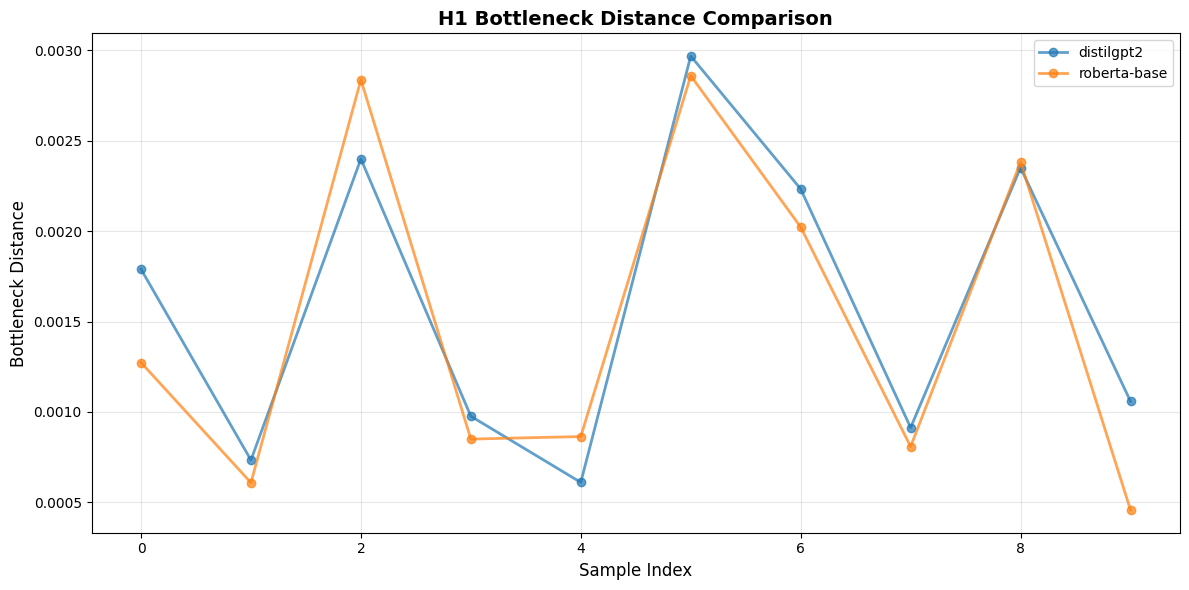

In [11]:
if __name__ == "__main__":
    # testing two comparisons
    compare_experiments([
        "/workspace/experiments/distilgpt2",
        "/workspace/experiments/roberta-base",
    ], labels=["distilgpt2", "roberta-base"])

ADVANCED TDA VISUALIZATION NOTEBOOK

Loading experiment from: distilgpt2

Loading data from: /workspace/experiments/distilgpt2
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

2. CONTOUR OVERLAYS
Plotting filled contours to show overlap and spread...



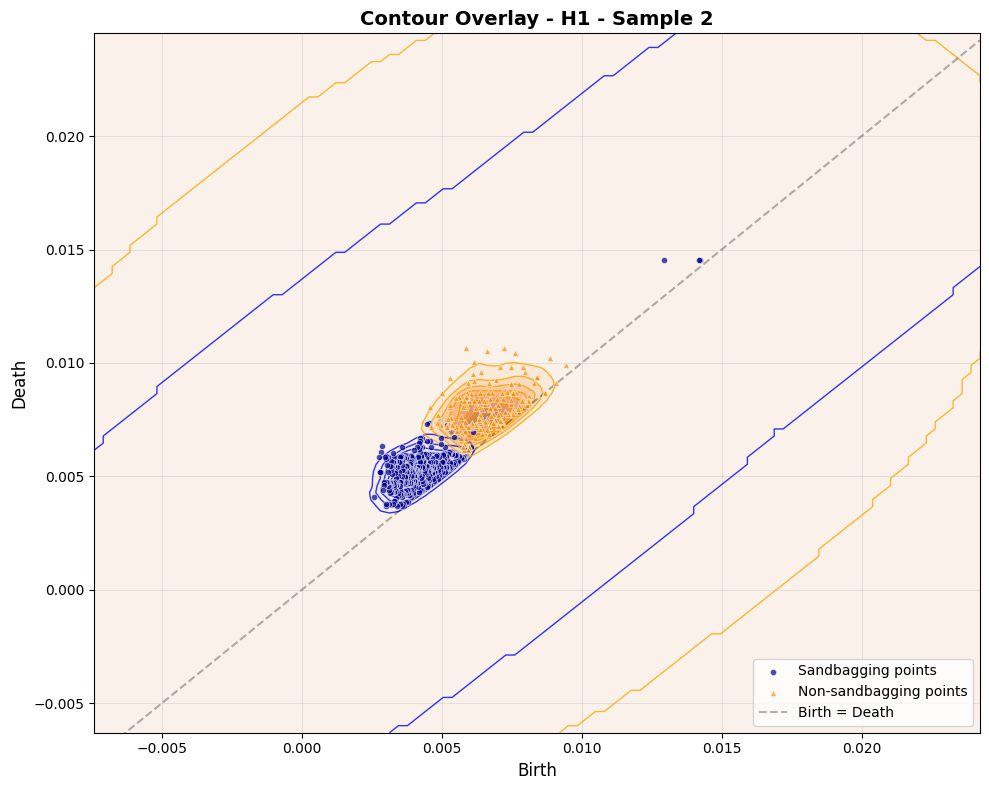

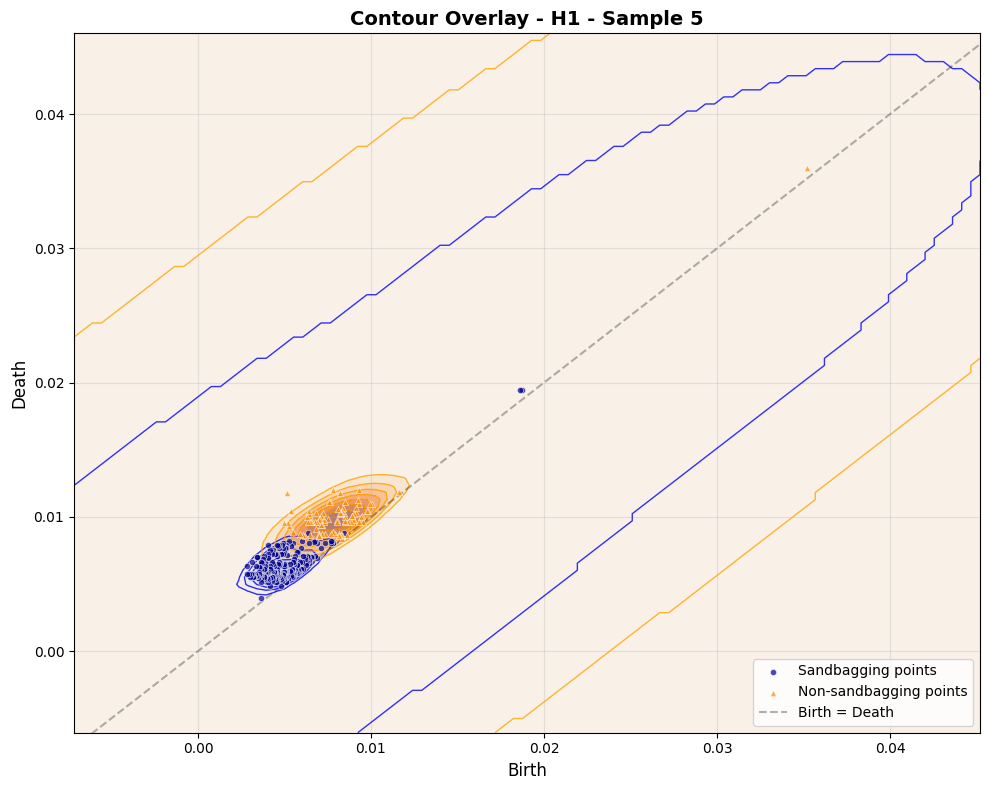

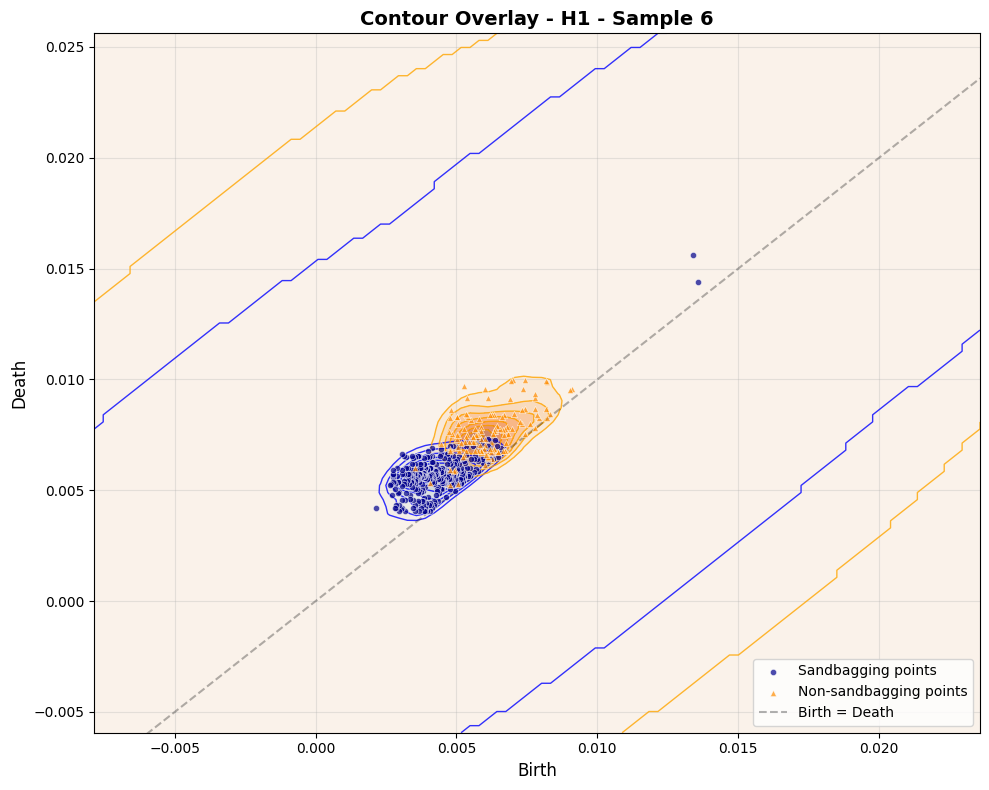

ADVANCED TDA VISUALIZATION NOTEBOOK

Loading experiment from: google_electra-small-discriminator

Loading data from: /workspace/experiments/google_electra-small-discriminator
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

2. CONTOUR OVERLAYS
Plotting filled contours to show overlap and spread...



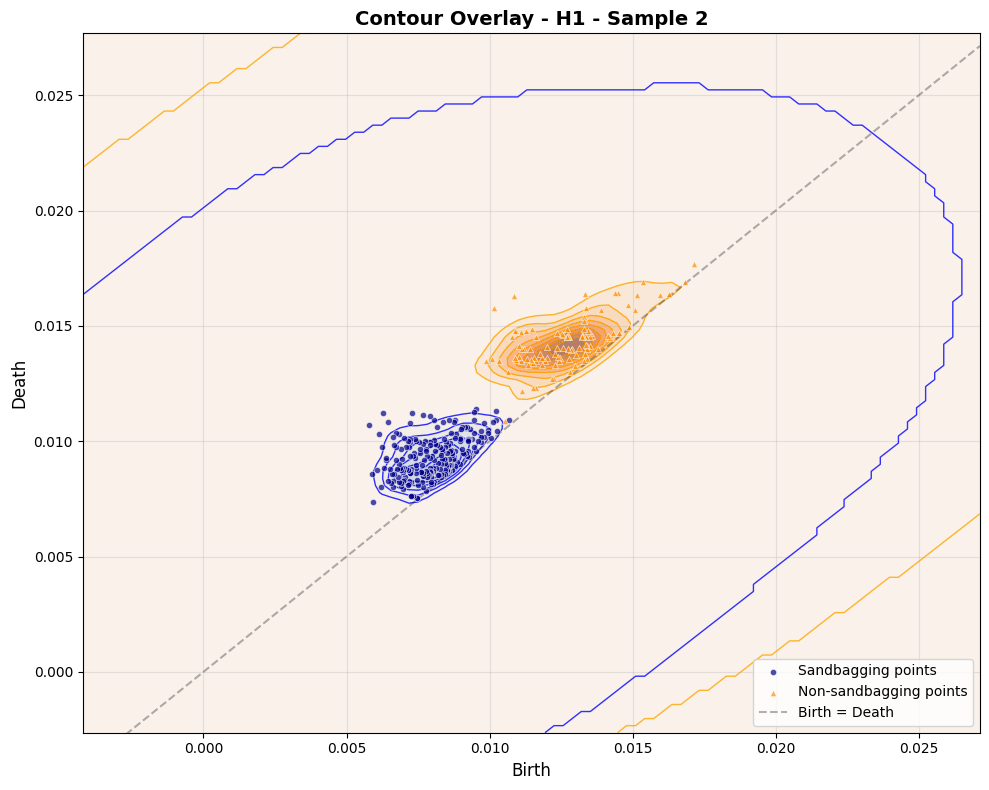

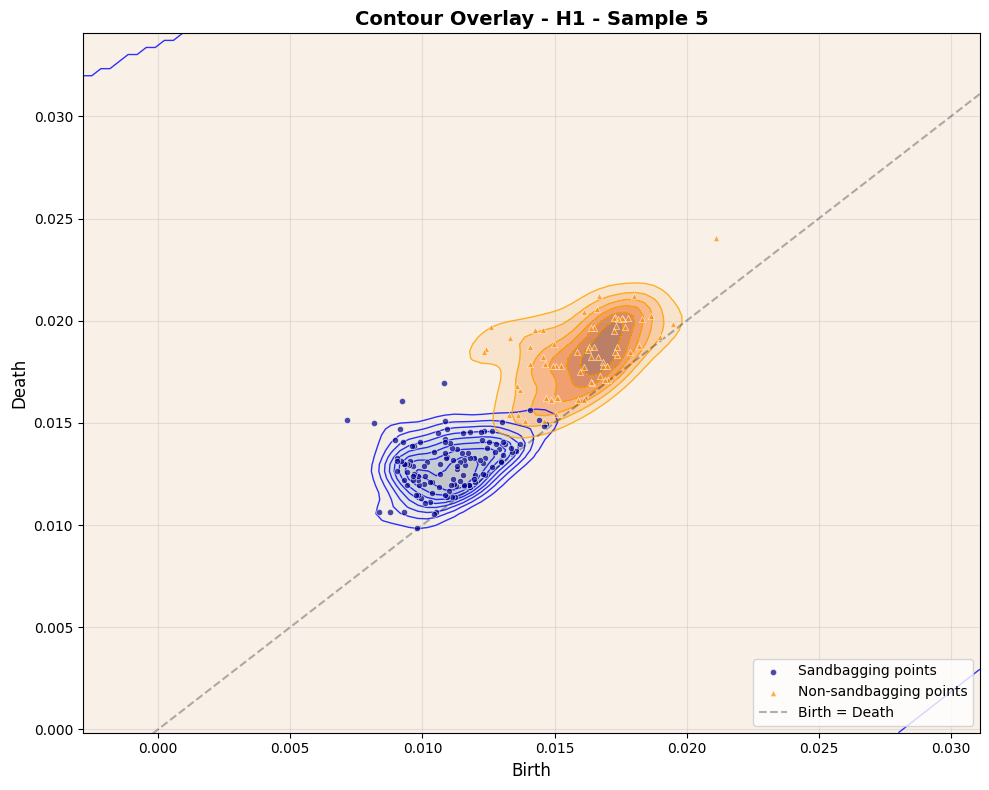

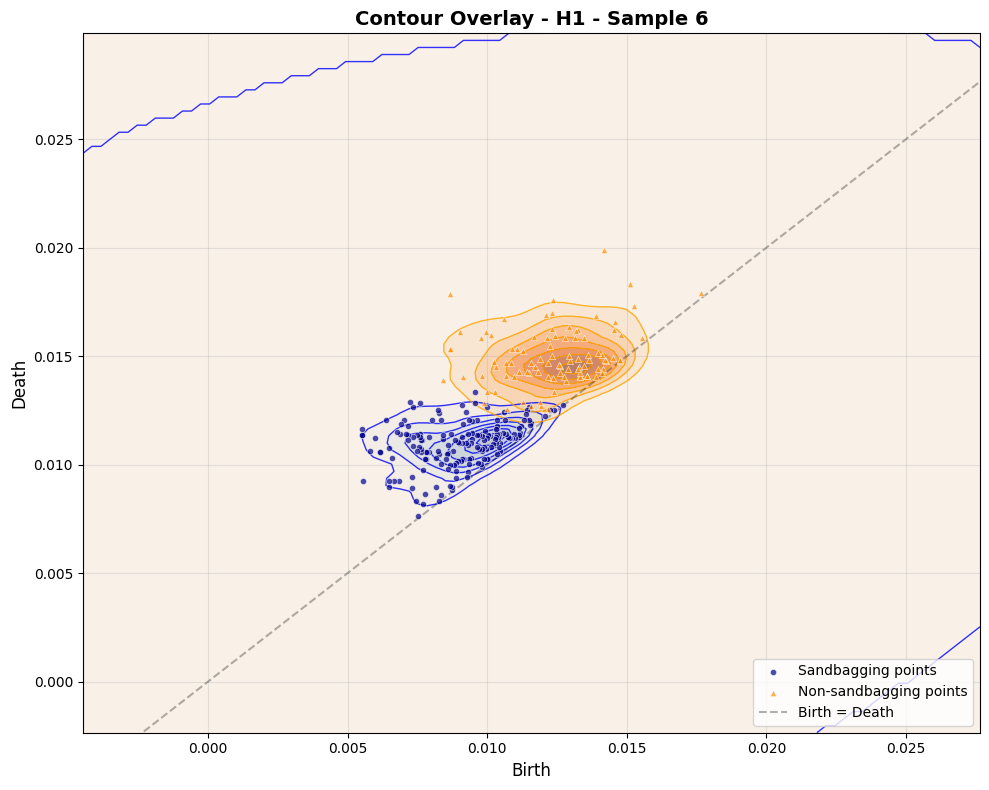

ADVANCED TDA VISUALIZATION NOTEBOOK

Loading experiment from: roberta-base

Loading data from: /workspace/experiments/roberta-base
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

2. CONTOUR OVERLAYS
Plotting filled contours to show overlap and spread...



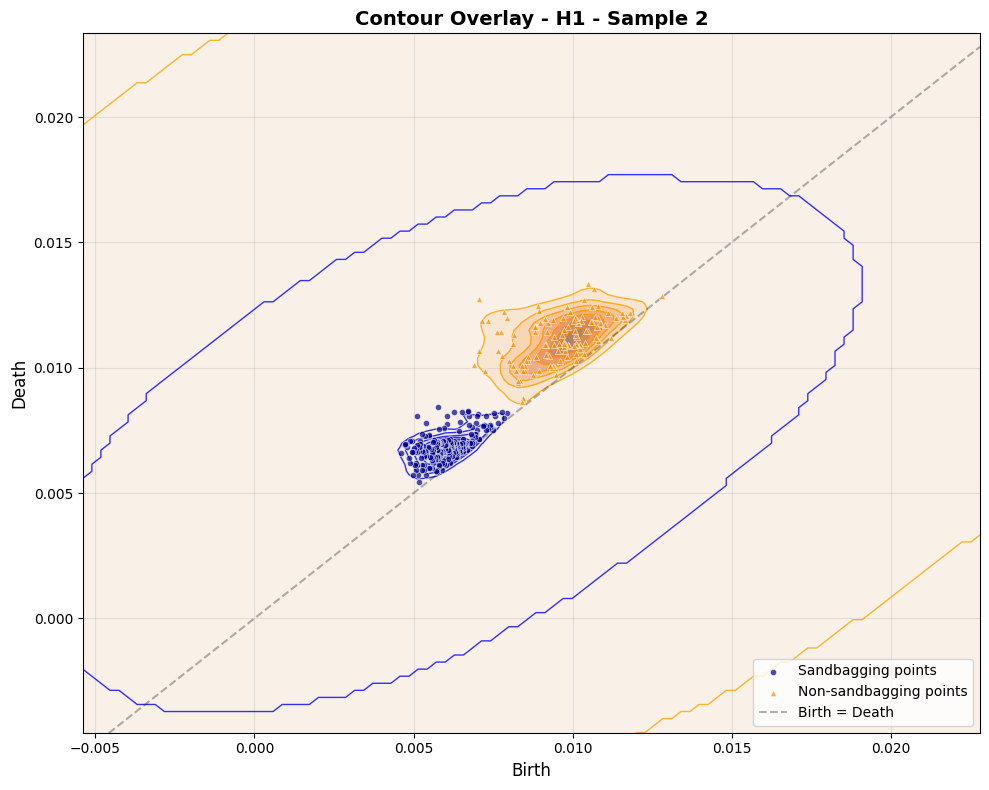

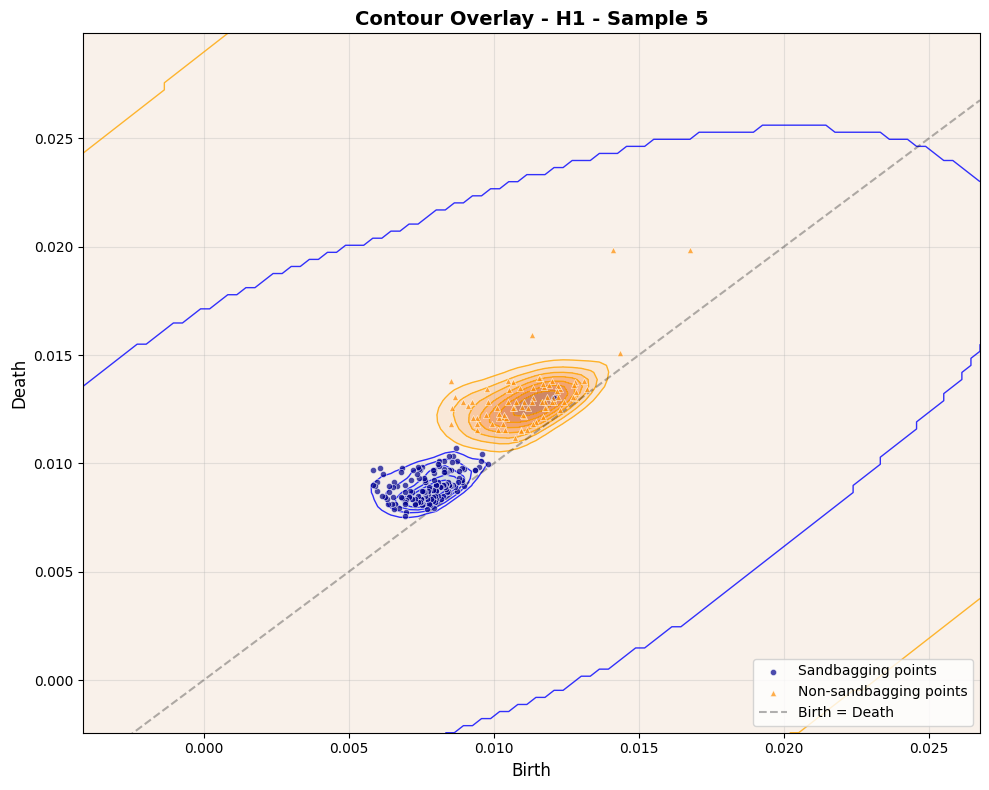

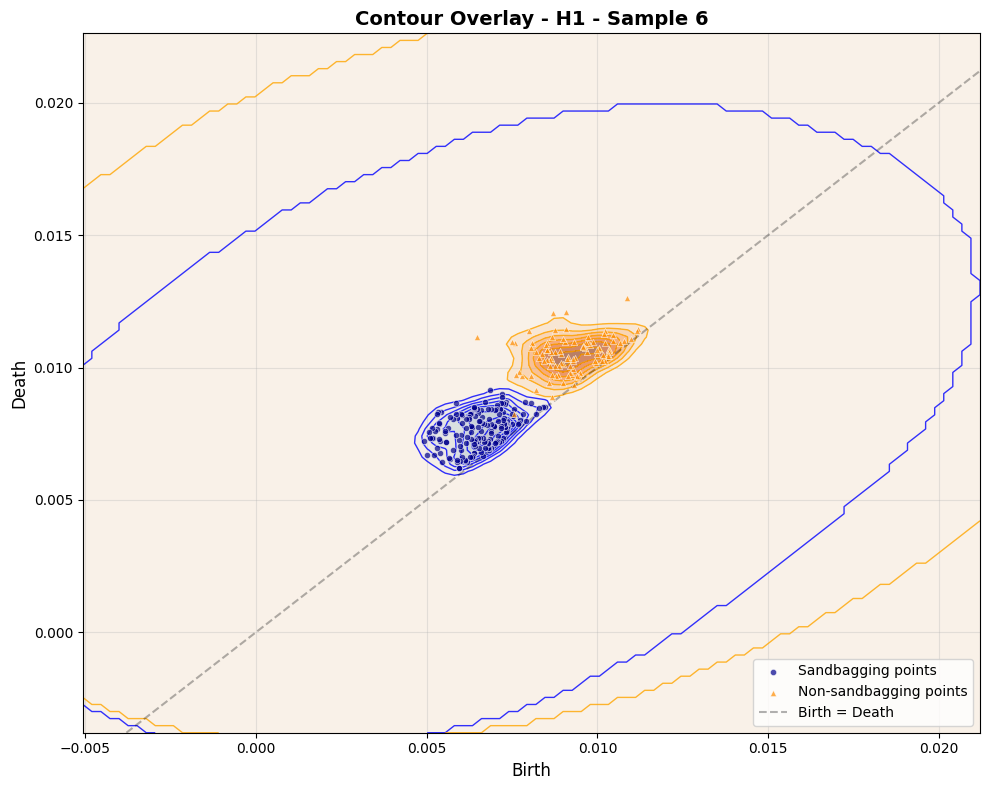

ADVANCED TDA VISUALIZATION NOTEBOOK

Loading experiment from: bert-base-uncased

Loading data from: /workspace/experiments/bert-base-uncased
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

2. CONTOUR OVERLAYS
Plotting filled contours to show overlap and spread...



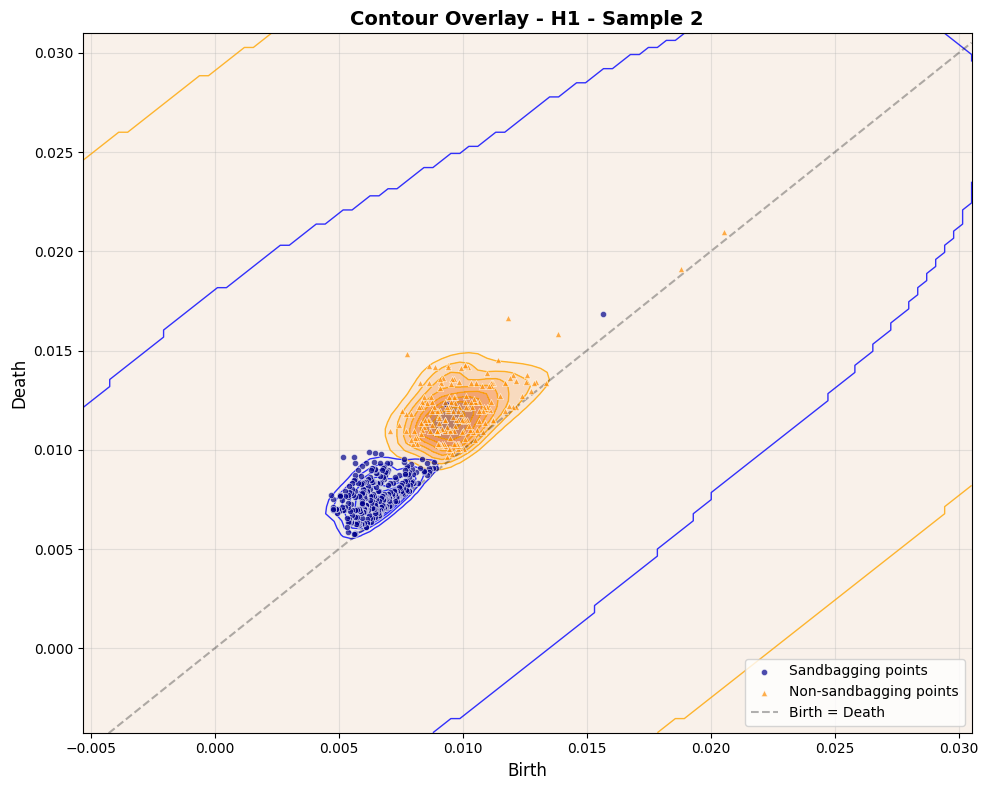

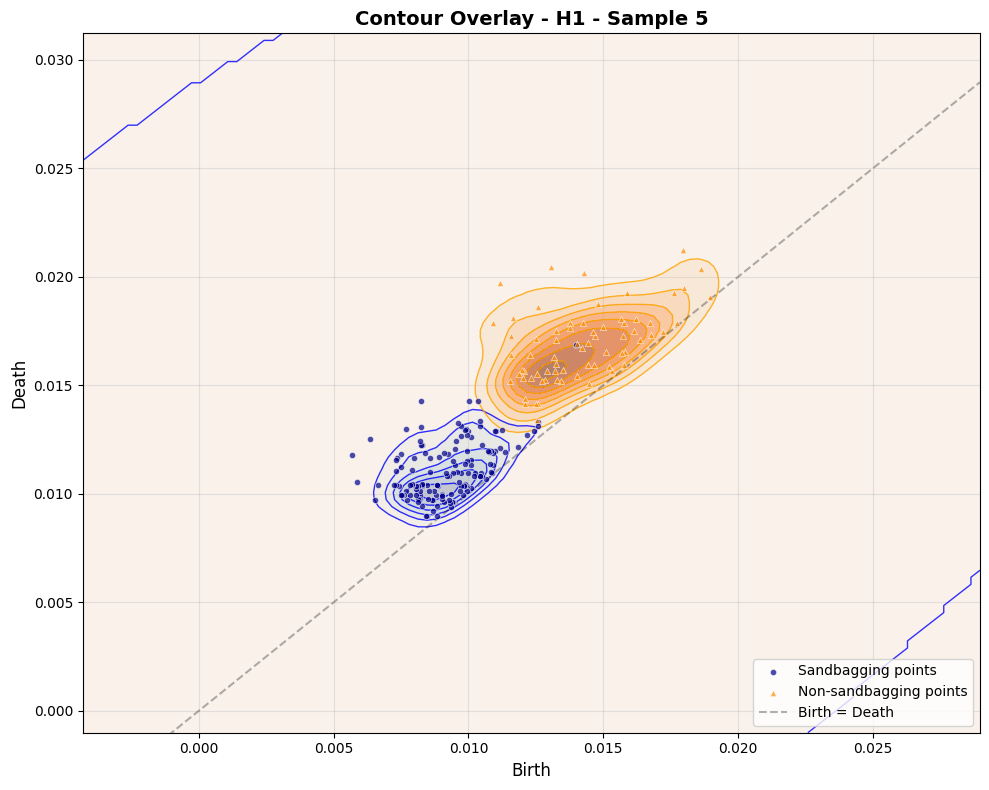

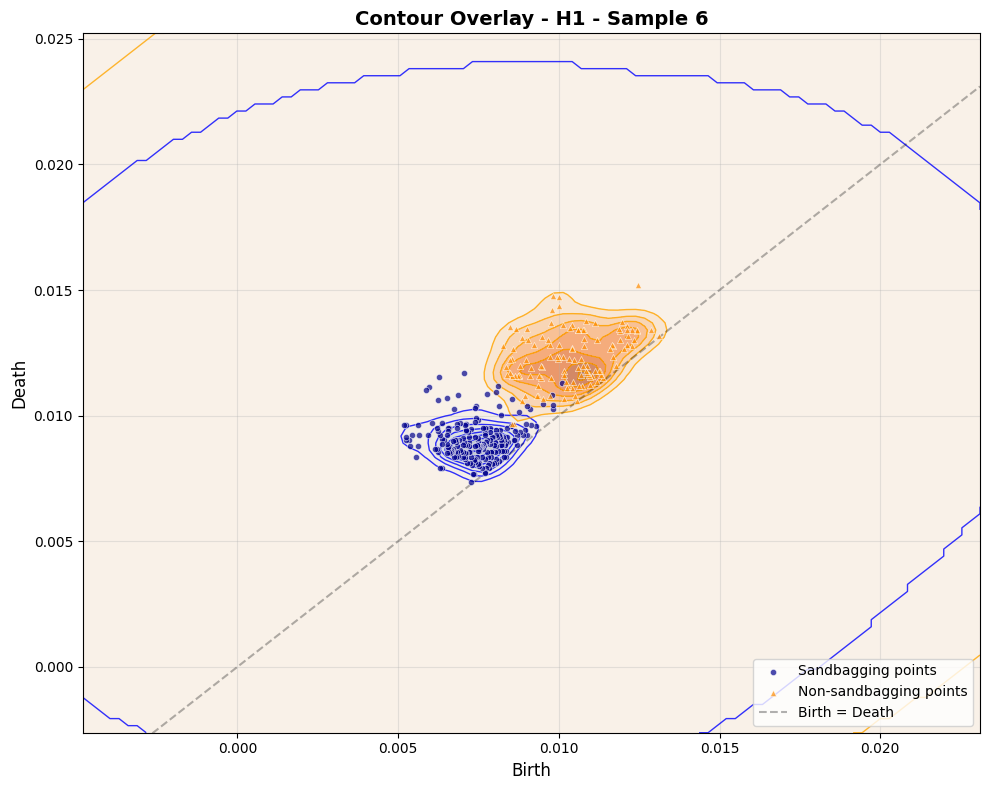

ADVANCED TDA VISUALIZATION NOTEBOOK

Loading experiment from: distilbert-base-uncased

Loading data from: /workspace/experiments/distilbert-base-uncased
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

2. CONTOUR OVERLAYS
Plotting filled contours to show overlap and spread...



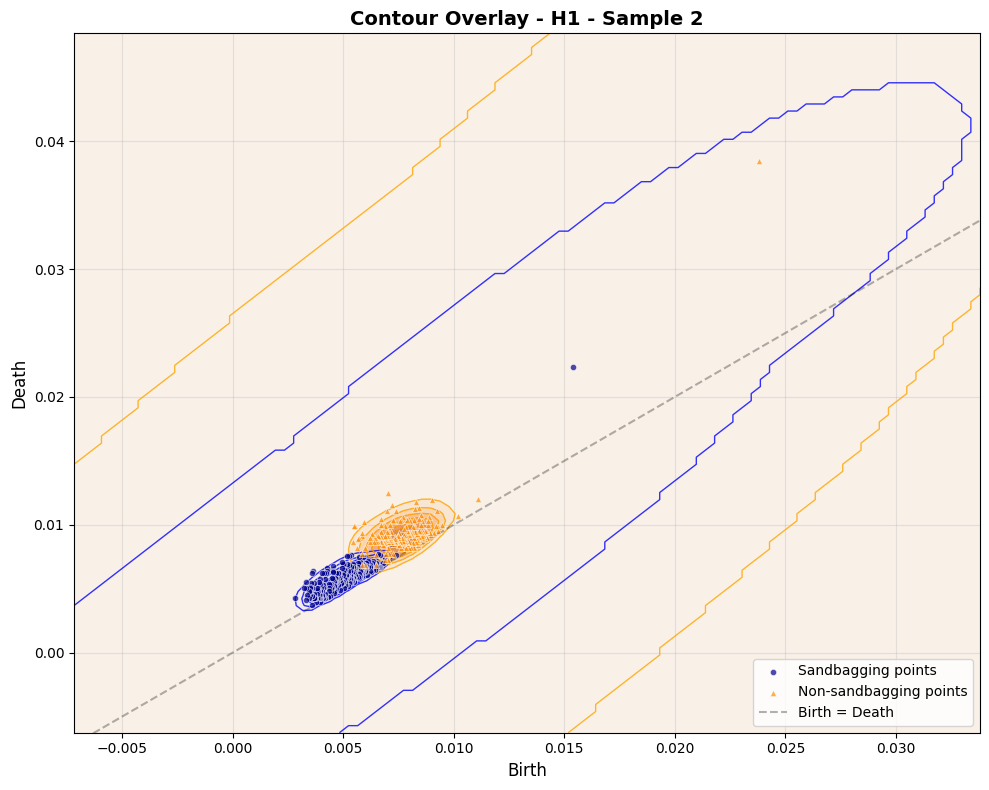

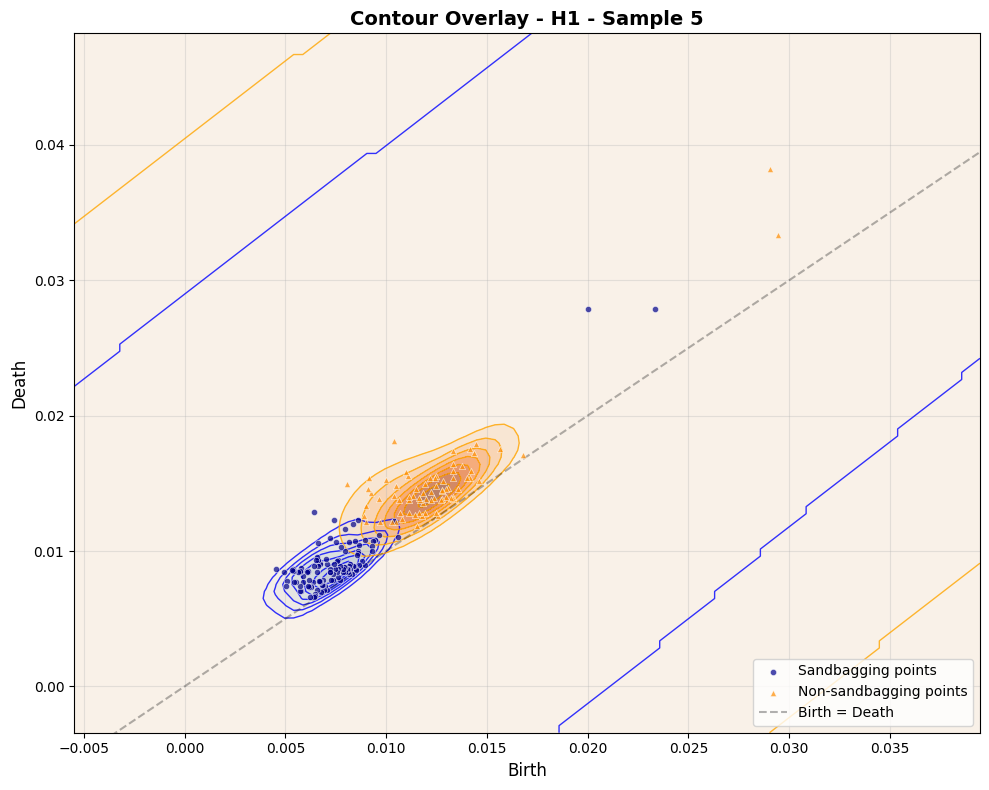

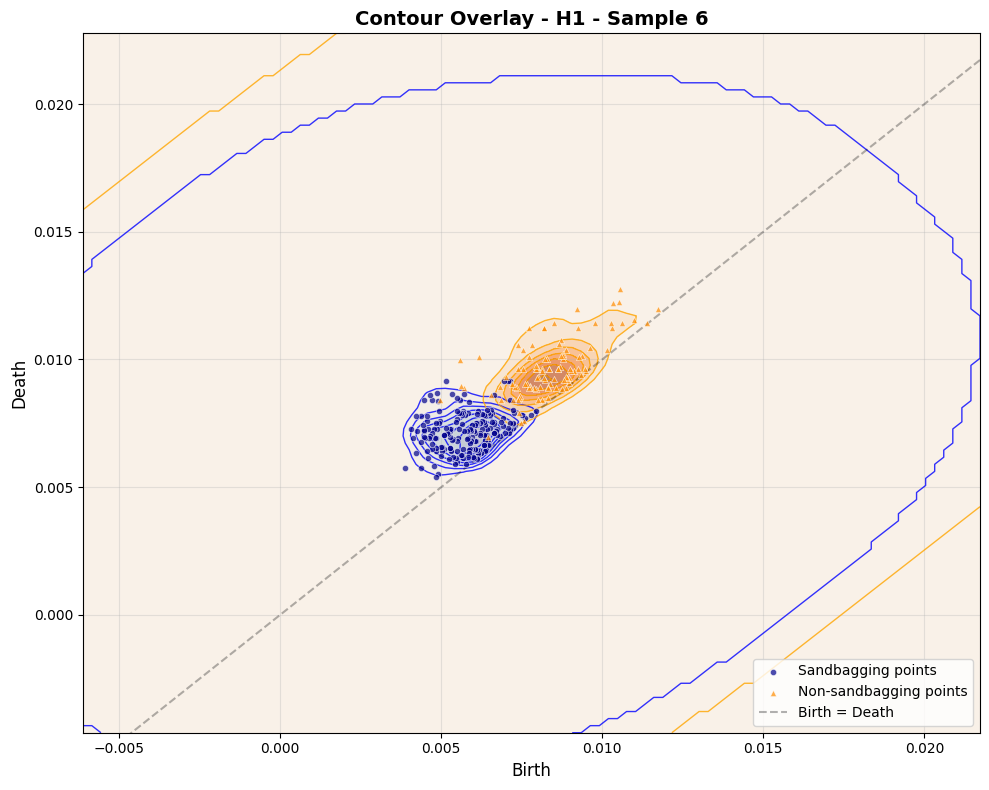

In [6]:
def main(expr_path):
    """
    Demonstrate all visualization techniques for a given experiment
    """
    import os
    
    print("="*60)
    print("ADVANCED TDA VISUALIZATION NOTEBOOK")
    print("="*60)
    
    # ========== SETUP ==========
    # TODO: Update this path to your experiment directory
    exp_dir = Path(expr_path)
    
    if not exp_dir.exists():
        print(f"\n⚠ Error: Experiment directory not found: {exp_dir}")
        print("\nPlease update the exp_dir variable with your experiment path.")
        print("\nAvailable experiments:")
        base_dir = Path("experiments")
        if base_dir.exists():
            for d in sorted(base_dir.iterdir()):
                if d.is_dir():
                    print(f"  - {d.name}")
        return
    
    # Load data
    print(f"\nLoading experiment from: {exp_dir.name}\n")
    viz = AdvancedTDAVisualizer(exp_dir)
    
# ========== VISUALIZATION 2: CONTOUR OVERLAYS ==========
    print("\n" + "="*60)
    print("2. CONTOUR OVERLAYS")
    print("="*60)
    print("Plotting filled contours to show overlap and spread...\n")
    
    plot_contour_overlay(viz, dim=1, sample_idx=2)
    plot_contour_overlay(viz, dim=1, sample_idx=5)
    plot_contour_overlay(viz, dim=1, sample_idx=6)


if __name__ == "__main__":
    # Run full demonstration
    paths = [
        "/workspace/experiments/distilgpt2",
        "/workspace/experiments/google_electra-small-discriminator",
        "/workspace/experiments/roberta-base",
        "/workspace/experiments/bert-base-uncased",
        "/workspace/experiments/distilbert-base-uncased"
    ]
    for path in paths:
        main(path)

In [19]:
# ==============================================================================
# MAIN DEMONSTRATION
# ==============================================================================

def main(expr_path):
    """
    Demonstrate all visualization techniques for a given experiment
    """
    import os
    
    print("="*60)
    print("ADVANCED TDA VISUALIZATION NOTEBOOK")
    print("="*60)
    
    # ========== SETUP ==========
    # TODO: Update this path to your experiment directory
    exp_dir = Path(expr_path)
    
    if not exp_dir.exists():
        print(f"\n⚠ Error: Experiment directory not found: {exp_dir}")
        print("\nPlease update the exp_dir variable with your experiment path.")
        print("\nAvailable experiments:")
        base_dir = Path("experiments")
        if base_dir.exists():
            for d in sorted(base_dir.iterdir()):
                if d.is_dir():
                    print(f"  - {d.name}")
        return
    
    # Load data
    print(f"\nLoading experiment from: {exp_dir.name}\n")
    viz = AdvancedTDAVisualizer(exp_dir)
    
    # ========== VISUALIZATION 1: KDE DIFFERENCE MAPS ==========
    print("\n" + "="*60)
    print("1. 2D KERNEL DENSITY DIFFERENCE MAPS")
    print("="*60)
    print("Computing KDE for sandbagging and non-sandbagging distributions...")
    print("Bright regions show where one distribution dominates.\n")
    
    plot_kde_difference_map(viz, dim=1, sample_idx=0)
    
    # Generate for multiple samples
    # plot_kde_difference_batch(viz, dim=1, n_samples=3, save_dir="viz_output/kde_diff")

    # ========== VISUALIZATION 2: CONTOUR OVERLAYS ==========
    print("\n" + "="*60)
    print("2. CONTOUR OVERLAYS")
    print("="*60)
    print("Plotting filled contours to show overlap and spread...\n")
    
    plot_contour_overlay(viz, dim=1, sample_idx=0)
    
    # Try for H0 as well
    print("\nH0 Contour Overlay:")
    # Check if H0 has data
    if len(viz.sb_data['res_list'][0]['dgms']) > 0:
        dgm_h0_sb = viz.sb_data['res_list'][0]['dgms'][0]
        dgm_h0_nsb = viz.nsb_data['res_list'][0]['dgms'][0]
        has_h0_data = (len(dgm_h0_sb) > 0 or len(dgm_h0_nsb) > 0)
        
        if has_h0_data:
            plot_contour_overlay(viz, dim=0, sample_idx=0)
        else:
            print("⚠ H0 has no data points to visualize, skipping...")
    else:
        print("⚠ H0 not computed, skipping...")
    
    # ========== VISUALIZATION 3: SUMMARY STATISTICS HEATMAP ==========
    print("\n" + "="*60)
    print("3. SUMMARY STATISTICS HEATMAP")
    print("="*60)
    print("Visualizing metrics across samples...\n")
    
    # Mean lifespan heatmap
    print("Mean H1 Lifespan:")
    create_summary_statistics_heatmap(viz, dim=1, metric='mean_lifespan')
    
    # Total persistence heatmap
    print("\nTotal Persistence:")
    create_summary_statistics_heatmap(viz, dim=1, metric='total_persistence')
    
    # Number of features heatmap
    print("\nNumber of Features:")
    create_summary_statistics_heatmap(viz, dim=1, metric='n_features')
    
    # ========== VISUALIZATION 4: DISTANCE BAR CHARTS ==========
    print("\n" + "="*60)
    print("4. BOTTLENECK / WASSERSTEIN DISTANCE BAR CHARTS")
    print("="*60)
    print("Quantifying topological distance between conditions...\n")
    
    if PERSIM_AVAILABLE:
        # Bottleneck distances
        print("Bottleneck Distance (H1):")
        distances_bn = plot_distance_bar_chart(viz, dim=1, metric='bottleneck')
        
        print("\nWasserstein Distance (H1):")
        distances_ws = plot_distance_bar_chart(viz, dim=1, metric='wasserstein')
        
        # Comparison plot
        print("\nDistance Comparison across H0 and H1:")
        plot_distance_comparison(viz, dims=[0, 1])
        
        # Print statistics
        print(f"\n📊 Distance Statistics (H1):")
        print(f"   Bottleneck - Mean: {np.mean(distances_bn):.4f}, Std: {np.std(distances_bn):.4f}")
        print(f"   Wasserstein - Mean: {np.mean(distances_ws):.4f}, Std: {np.std(distances_ws):.4f}")
    else:
        print("⚠ persim not available - using Hausdorff approximation")
        distances = plot_distance_bar_chart(viz, dim=1, metric='bottleneck')
        print(f"\n📊 Approx Distance - Mean: {np.mean(distances):.4f}, Std: {np.std(distances):.4f}")
    
    # ========== VISUALIZATION 5: LAYER-WISE ANALYSIS ==========
    print("\n" + "="*60)
    print("5. LAYER-WISE LINE PLOTS")
    print("="*60)
    print("Analyzing how topology changes across model layers...\n")
    
    # Check if we have multiple layer experiments
    base_exp_name = exp_dir.name.rsplit('_layer', 1)[0] if '_layer' in exp_dir.name else exp_dir.name
    layer_experiments = []
    
    # Look for experiments with different layers
    for d in exp_dir.parent.iterdir():
        if d.is_dir() and base_exp_name in d.name:
            # Try to extract layer number
            if 'layer' in d.name.lower():
                layer_experiments.append(d)
    
    if len(layer_experiments) > 1:
        print(f"Found {len(layer_experiments)} layer experiments!")
        layer_experiments = sorted(layer_experiments)
        
        # Plot layer-wise trends
        print("\nMean H1 Lifespan across Layers:")
        df_lifespan = plot_layerwise_analysis(
            layer_experiments,
            model_name="BERT",
            dim=1,
            metric='mean_lifespan'
        )
        
        print("\nBottleneck Distance across Layers:")
        df_distance = plot_layerwise_analysis(
            layer_experiments,
            model_name="BERT",
            dim=1,
            metric='bottleneck_distance'
        )
        
        # Find most vulnerable layer
        max_dist_layer = df_distance.loc[df_distance['sb_mean'].idxmax(), 'layer']
        print(f"\n🎯 Most vulnerable layer: Layer {int(max_dist_layer)}")
        print(f"   (Highest bottleneck distance: {df_distance['sb_mean'].max():.4f})")
    else:
        print("⚠ Only one layer experiment found.")
        print("To use layer-wise analysis, run experiments with different layer indices:")
        print("  Example: layer=0, layer=1, layer=2, etc.")
        print("\nShowing single-layer analysis instead...\n")
        
        # Single layer analysis - compare metrics
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        metrics = ['mean_lifespan', 'total_persistence', 'n_features', 'max_lifespan']
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx // 2, idx % 2]
            
            n_samples = min(len(viz.sb_data['res_list']), 
                          len(viz.nsb_data['res_list']))
            
            sb_values = []
            nsb_values = []
            
            for i in range(n_samples):
                dgm_sb = viz.sb_data['res_list'][i]['dgms'][1]
                dgm_nsb = viz.nsb_data['res_list'][i]['dgms'][1]
                
                stats_sb = compute_persistence_statistics(dgm_sb)
                stats_nsb = compute_persistence_statistics(dgm_nsb)
                
                sb_values.append(stats_sb[metric])
                nsb_values.append(stats_nsb[metric])
            
            x = np.arange(n_samples)
            ax.plot(x, sb_values, marker='o', label='Sandbagging', color='blue', linewidth=2)
            ax.plot(x, nsb_values, marker='s', label='Non-Sandbagging', color='orange', linewidth=2)
            
            ax.set_xlabel('Sample Index', fontsize=10)
            ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=10)
            ax.set_title(f'H1 {metric.replace("_", " ").title()}', fontsize=11, fontweight='bold')
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
        
        plt.suptitle('H1 Metrics Across Samples', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # ========== SUMMARY REPORT ==========
    print("\n" + "="*60)
    print("📊 SUMMARY REPORT")
    print("="*60)
    
    n_samples = min(len(viz.sb_data['res_list']), len(viz.nsb_data['res_list']))
    
    print(f"\nExperiment: {exp_dir.name}")
    print(f"Total samples: {n_samples}")
    
    # Compute overall statistics
    all_sb_stats = []
    all_nsb_stats = []
    all_distances = []
    
    for i in range(n_samples):
        dgm_sb = viz.sb_data['res_list'][i]['dgms'][1]
        dgm_nsb = viz.nsb_data['res_list'][i]['dgms'][1]
        
        stats_sb = compute_persistence_statistics(dgm_sb)
        stats_nsb = compute_persistence_statistics(dgm_nsb)
        
        all_sb_stats.append(stats_sb)
        all_nsb_stats.append(stats_nsb)
        
        if PERSIM_AVAILABLE:
            dist = compute_diagram_distance(dgm_sb, dgm_nsb, 'bottleneck')
            all_distances.append(dist)
    
    # Average statistics
    print("\n🔹 Average H1 Statistics:")
    print("\n  Sandbagging:")
    for key in ['mean_lifespan', 'n_features', 'total_persistence']:
        avg = np.mean([s[key] for s in all_sb_stats])
        print(f"    {key.replace('_', ' ').title()}: {avg:.4f}")
    
    print("\n  Non-Sandbagging:")
    for key in ['mean_lifespan', 'n_features', 'total_persistence']:
        avg = np.mean([s[key] for s in all_nsb_stats])
        print(f"    {key.replace('_', ' ').title()}: {avg:.4f}")
    
    if all_distances:
        print(f"\n🔹 Average Topological Distance:")
        print(f"    Bottleneck Distance: {np.mean(all_distances):.4f} ± {np.std(all_distances):.4f}")
    
    # Key findings
    print("\n🔍 Key Findings:")
    
    avg_sb_lifespan = np.mean([s['mean_lifespan'] for s in all_sb_stats])
    avg_nsb_lifespan = np.mean([s['mean_lifespan'] for s in all_nsb_stats])
    
    if avg_sb_lifespan > avg_nsb_lifespan:
        print(f"   • Sandbagging produces {((avg_sb_lifespan/avg_nsb_lifespan - 1) * 100):.1f}% longer H1 lifespans")
    else:
        print(f"   • Non-sandbagging produces {((avg_nsb_lifespan/avg_sb_lifespan - 1) * 100):.1f}% longer H1 lifespans")
    
    avg_sb_features = np.mean([s['n_features'] for s in all_sb_stats])
    avg_nsb_features = np.mean([s['n_features'] for s in all_nsb_stats])
    
    print(f"   • Average H1 features: Sandbagging={avg_sb_features:.1f}, Non-sandbagging={avg_nsb_features:.1f}")
    
    if all_distances:
        max_dist_idx = np.argmax(all_distances)
        print(f"   • Sample {max_dist_idx} shows largest topological change (distance={all_distances[max_dist_idx]:.4f})")
    
    print("\n✅ Analysis complete!")
    print("\nTo save visualizations, uncomment the save_dir parameters in the plotting functions.")


ADVANCED TDA VISUALIZATION NOTEBOOK

Loading experiment from: distilgpt2

Loading data from: /workspace/experiments/distilgpt2
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

1. 2D KERNEL DENSITY DIFFERENCE MAPS
Computing KDE for sandbagging and non-sandbagging distributions...
Bright regions show where one distribution dominates.



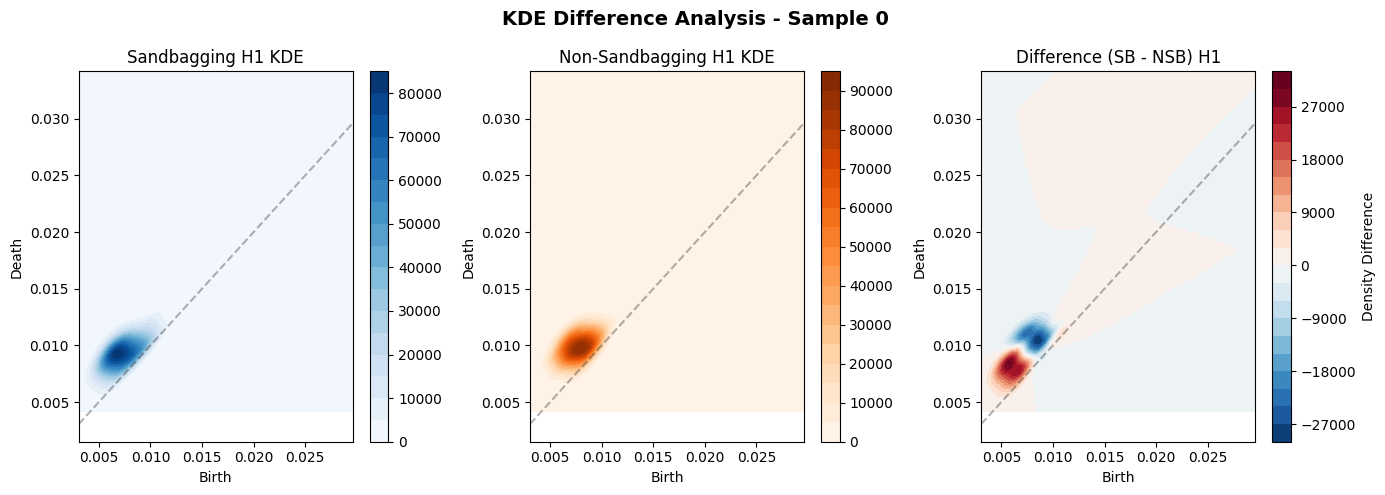


2. CONTOUR OVERLAYS
Plotting filled contours to show overlap and spread...



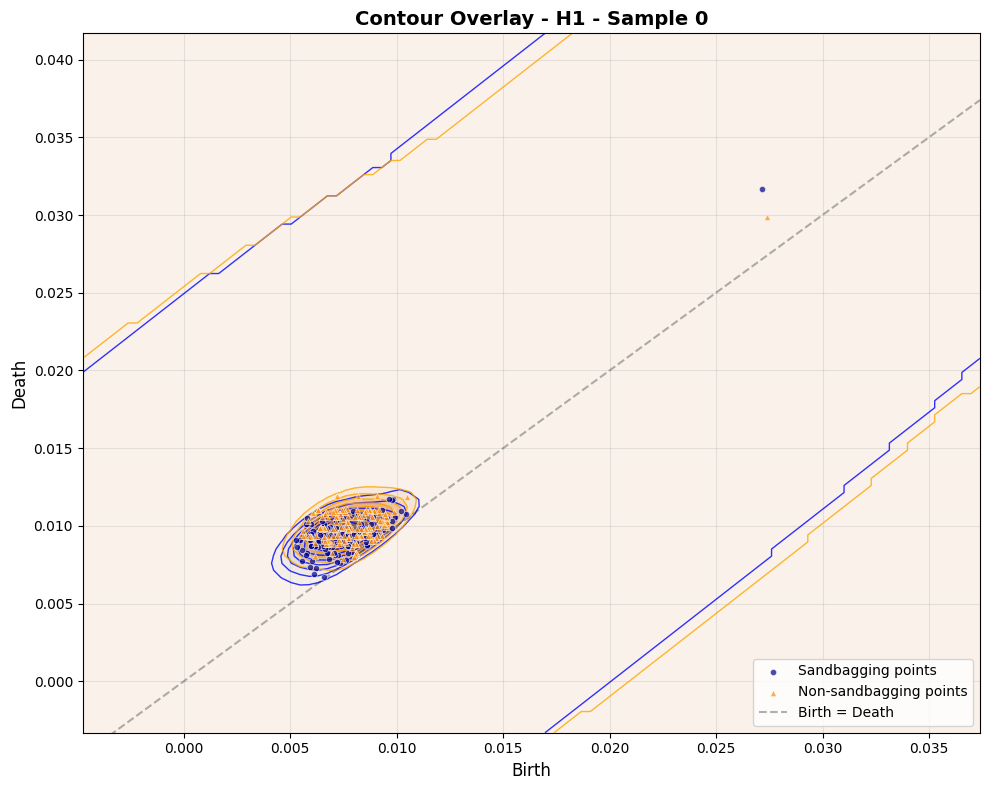


H0 Contour Overlay:
⚠ Warning: No finite points found for H0 in sample 0


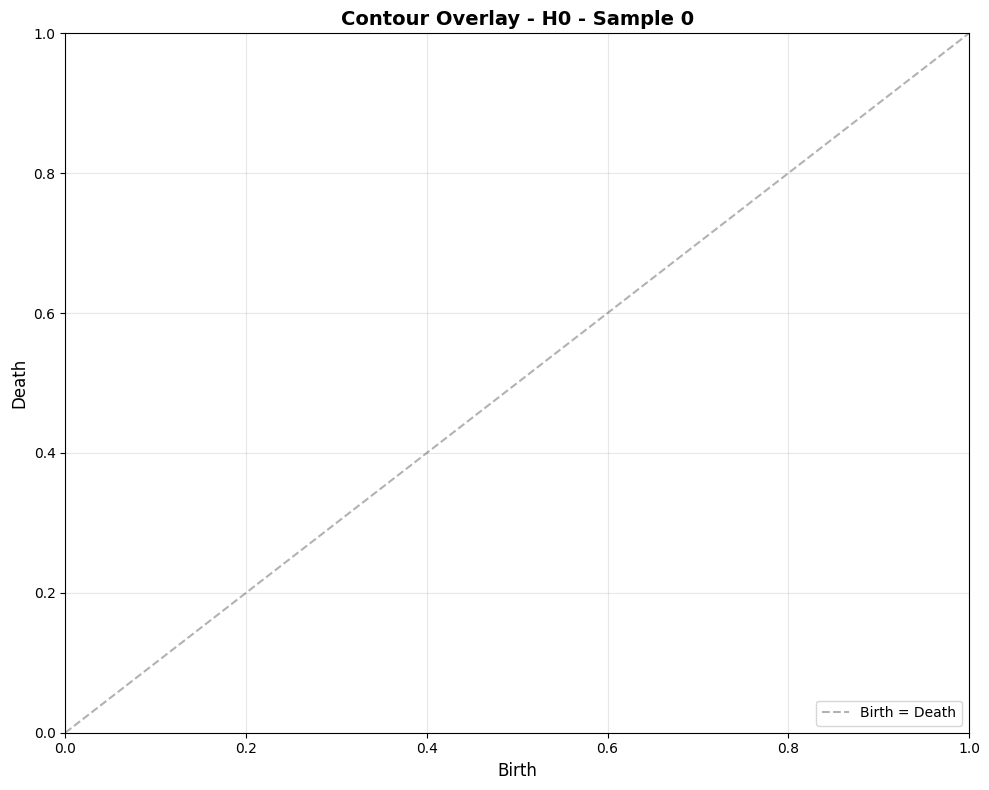


3. SUMMARY STATISTICS HEATMAP
Visualizing metrics across samples...

Mean H1 Lifespan:


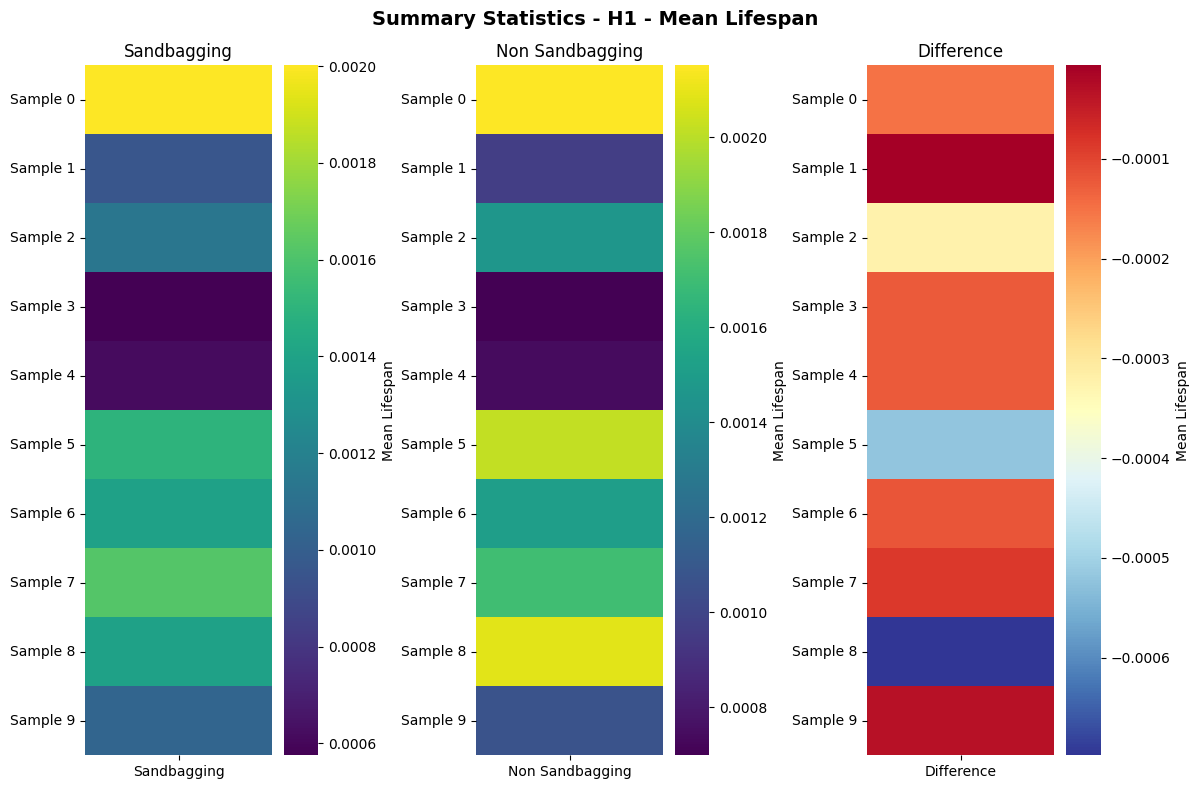


Total Persistence:


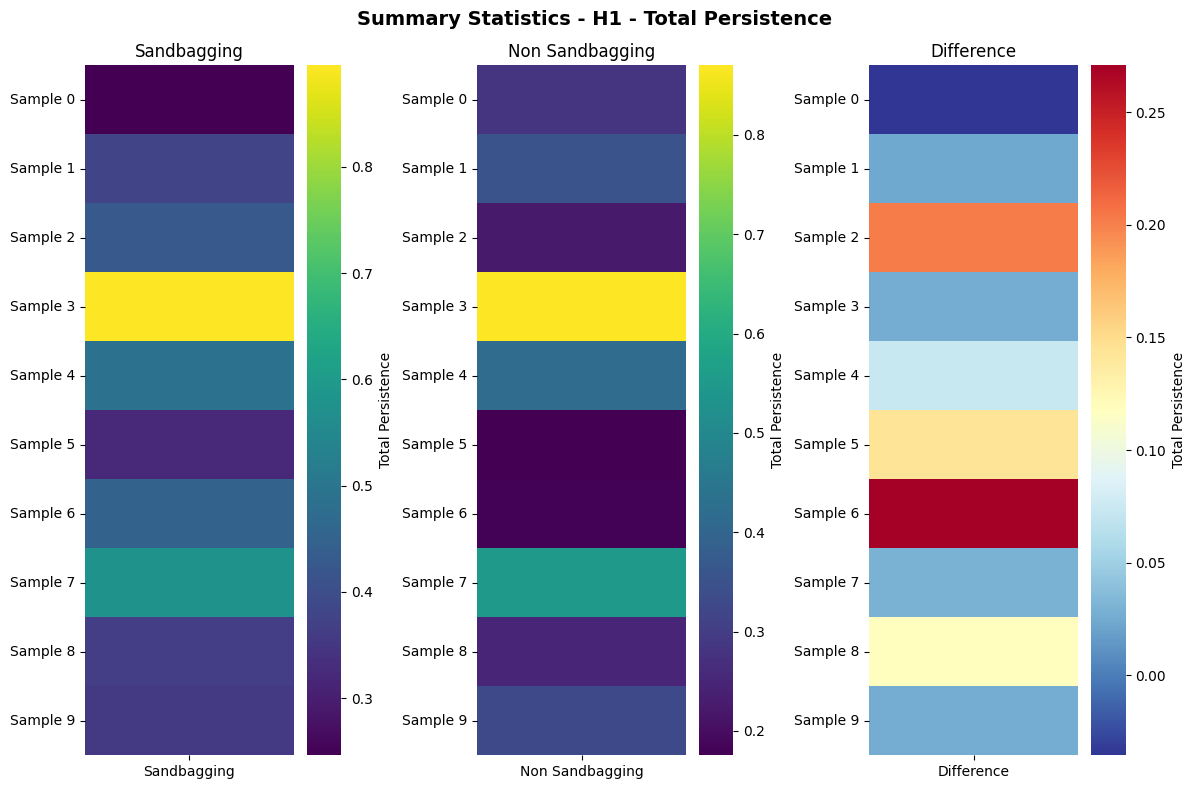


Number of Features:


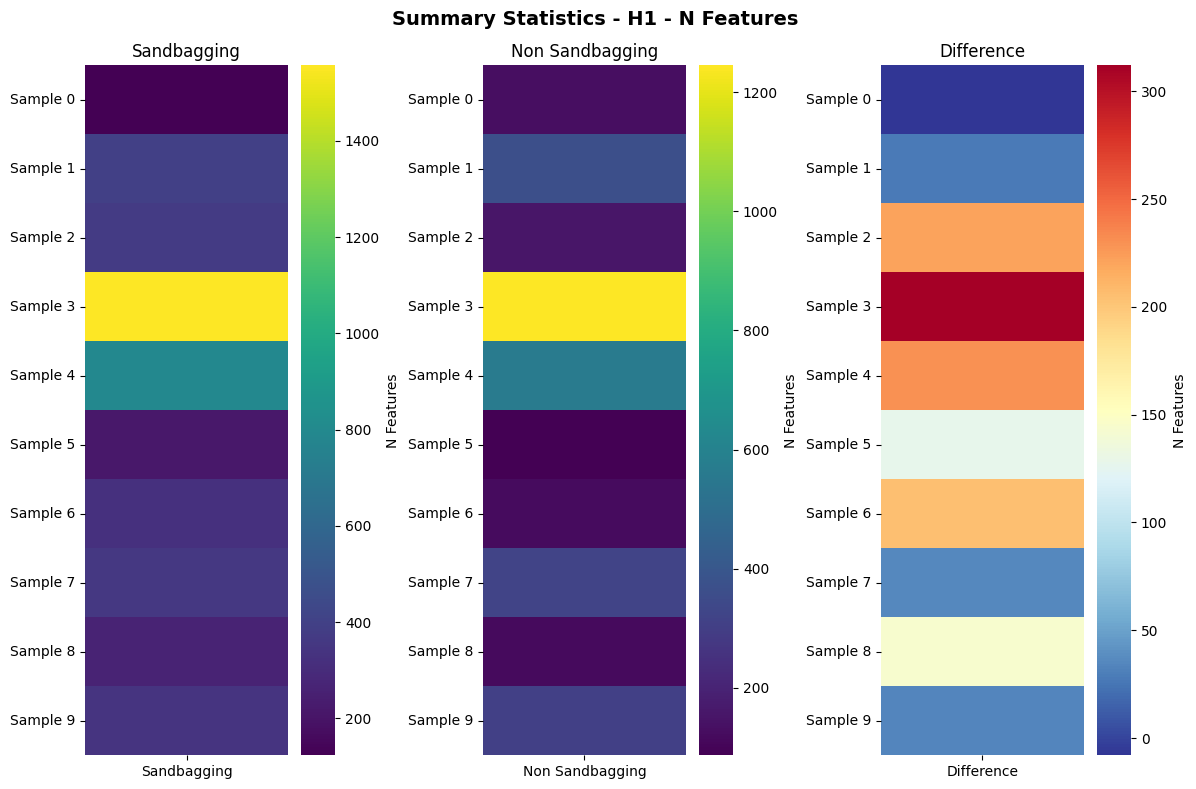


4. BOTTLENECK / WASSERSTEIN DISTANCE BAR CHARTS
Quantifying topological distance between conditions...

Bottleneck Distance (H1):


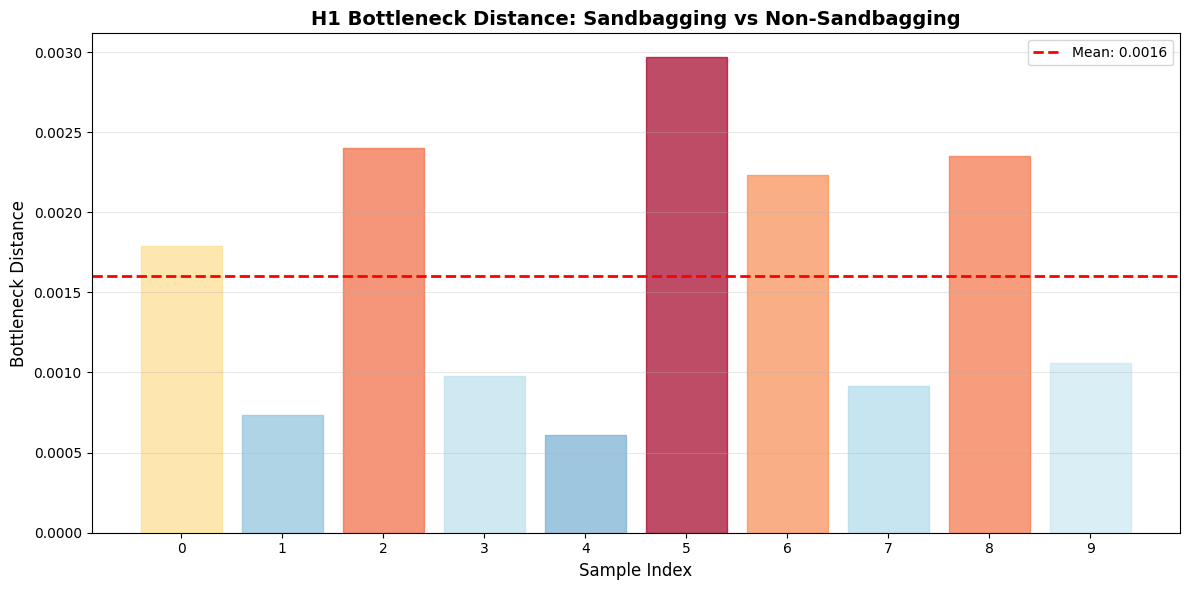


Wasserstein Distance (H1):


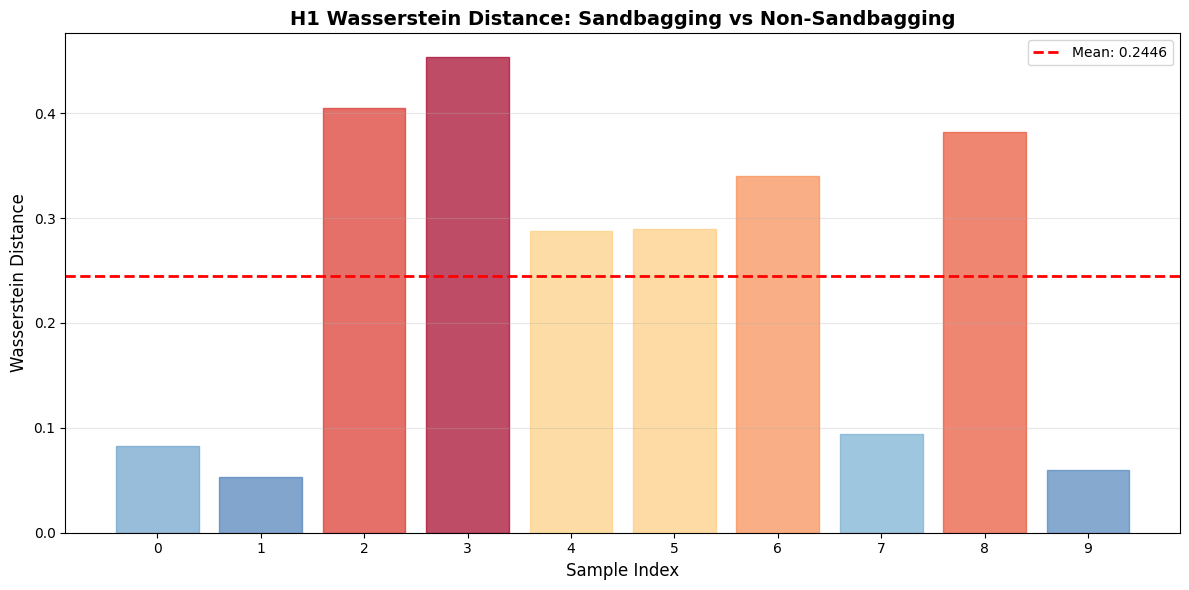


Distance Comparison across H0 and H1:


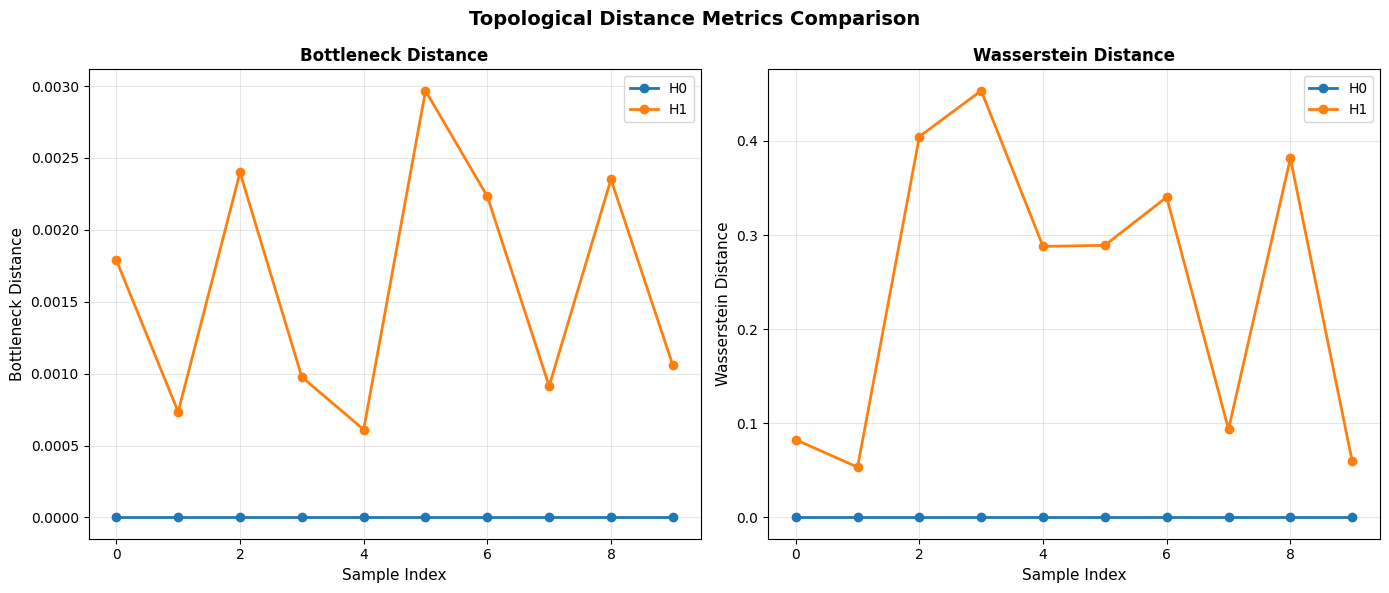


📊 Distance Statistics (H1):
   Bottleneck - Mean: 0.0016, Std: 0.0008
   Wasserstein - Mean: 0.2446, Std: 0.1486

5. LAYER-WISE LINE PLOTS
Analyzing how topology changes across model layers...

⚠ Only one layer experiment found.
To use layer-wise analysis, run experiments with different layer indices:
  Example: layer=0, layer=1, layer=2, etc.

Showing single-layer analysis instead...



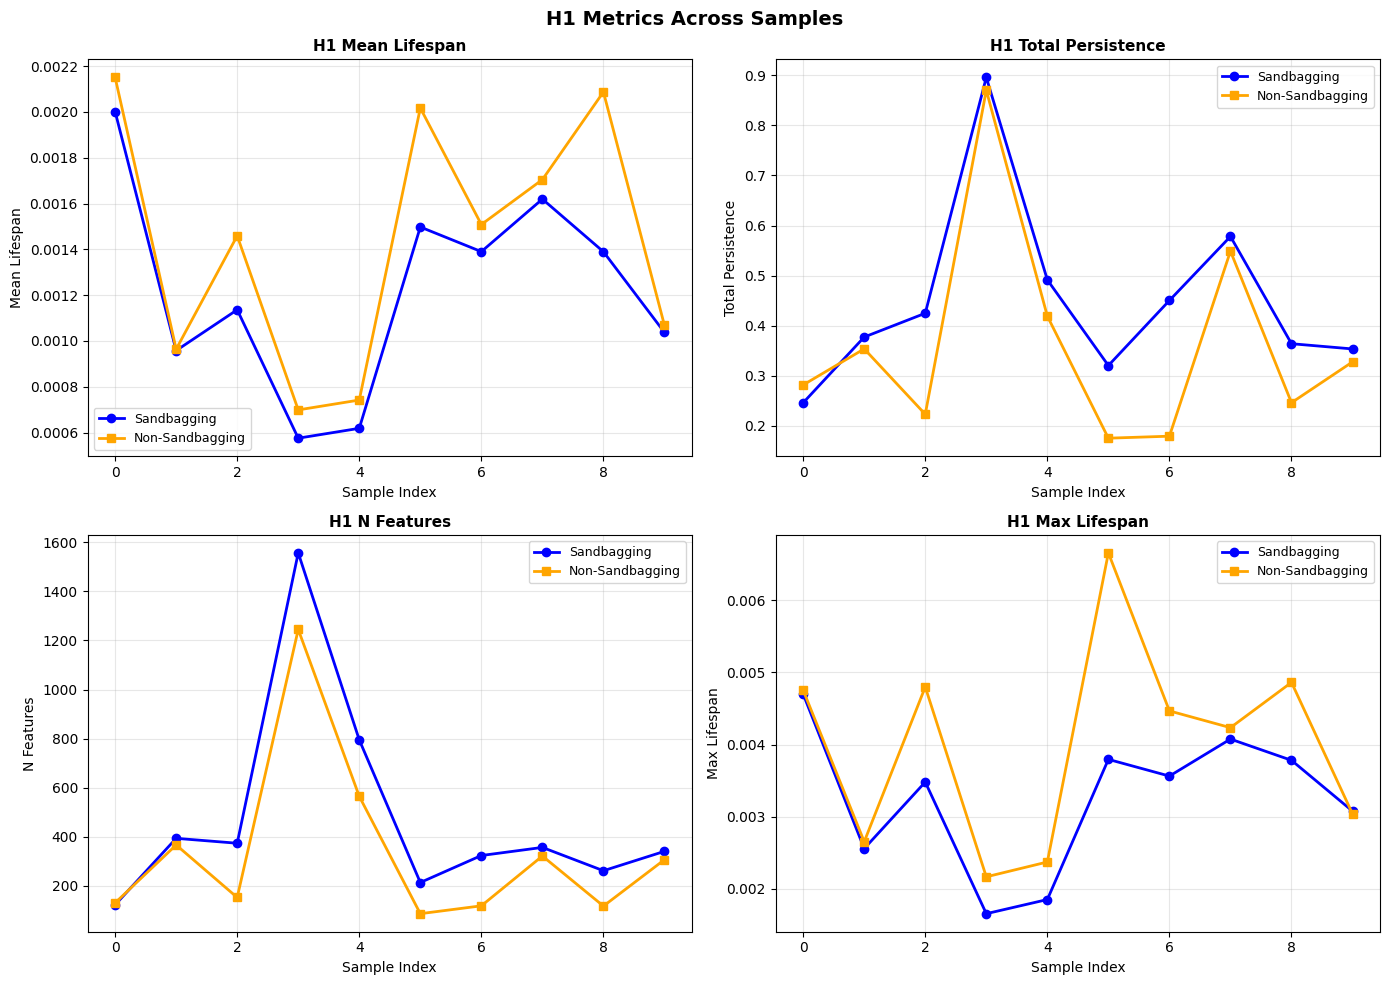


📊 SUMMARY REPORT

Experiment: distilgpt2
Total samples: 10

🔹 Average H1 Statistics:

  Sandbagging:
    Mean Lifespan: 0.0012
    N Features: 474.1000
    Total Persistence: 0.4502

  Non-Sandbagging:
    Mean Lifespan: 0.0014
    N Features: 341.4000
    Total Persistence: 0.3626

🔹 Average Topological Distance:
    Bottleneck Distance: 0.0016 ± 0.0008

🔍 Key Findings:
   • Non-sandbagging produces 17.8% longer H1 lifespans
   • Average H1 features: Sandbagging=474.1, Non-sandbagging=341.4
   • Sample 5 shows largest topological change (distance=0.0030)

✅ Analysis complete!

To save visualizations, uncomment the save_dir parameters in the plotting functions.


In [17]:
# ==============================================================================
# RUN MAIN
# ==============================================================================

if __name__ == "__main__":
    # Run full demonstration
    main("/workspace/experiments/distilgpt2")
    
    # Alternative: Quick analysis of specific experiment
    # quick_analysis("experiments/YOUR_EXPERIMENT_DIR")
    
    # Alternative: Batch export
    # batch_export_visualizations("experiments/YOUR_EXPERIMENT_DIR")
    
    # Alternative: Compare multiple experiments
    # compare_experiments([
    #     "experiments/exp1",
    #     "experiments/exp2"
    # ], labels=["Model A", "Model B"])

ADVANCED TDA VISUALIZATION NOTEBOOK

Loading experiment from: google_electra-small-discriminator

Loading data from: /workspace/experiments/google_electra-small-discriminator
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

1. 2D KERNEL DENSITY DIFFERENCE MAPS
Computing KDE for sandbagging and non-sandbagging distributions...
Bright regions show where one distribution dominates.



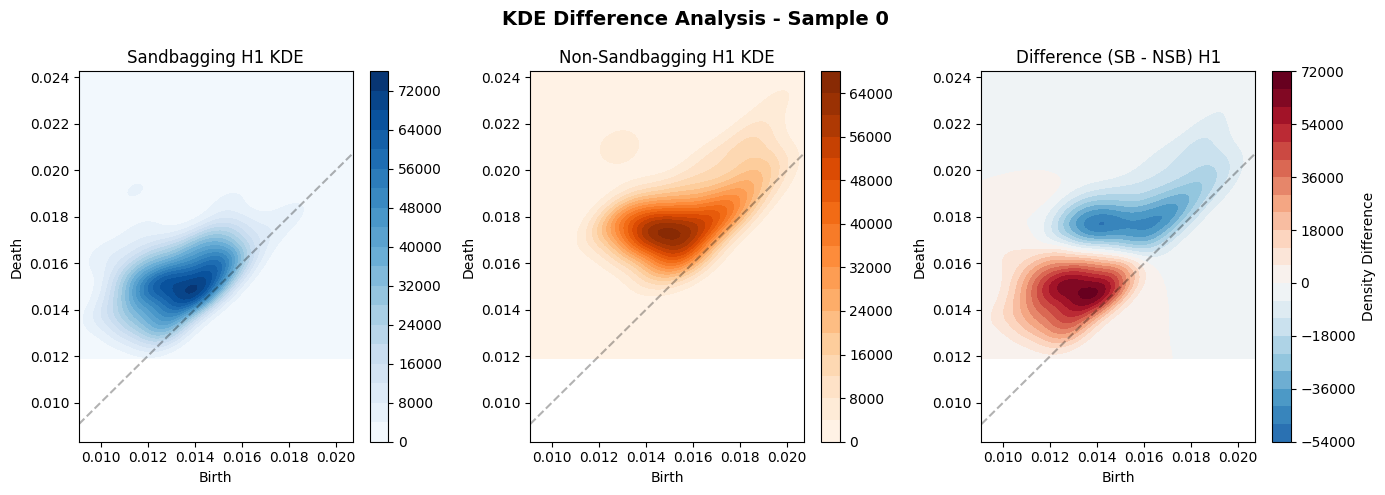


2. CONTOUR OVERLAYS
Plotting filled contours to show overlap and spread...



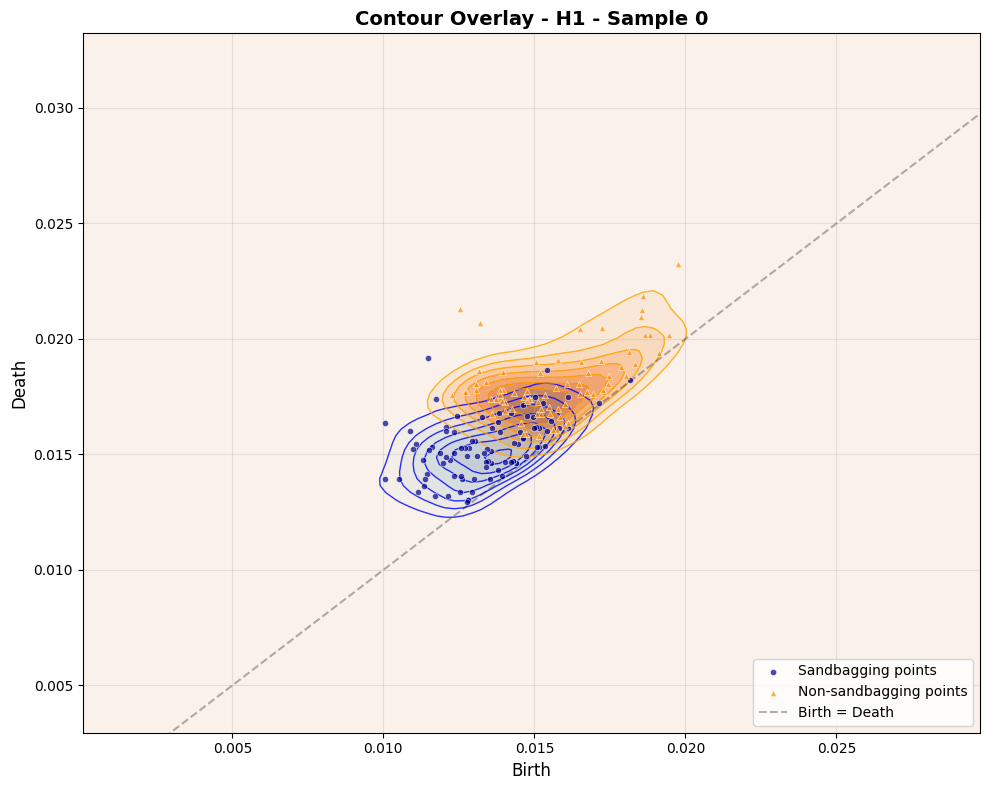


H0 Contour Overlay:


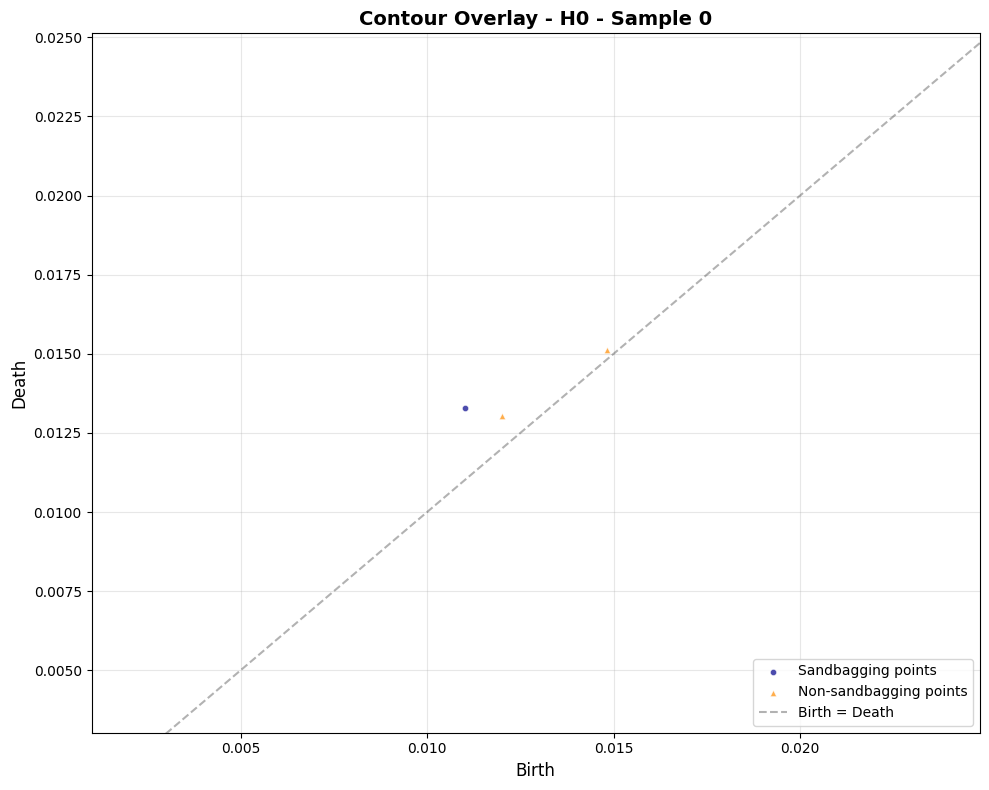


3. SUMMARY STATISTICS HEATMAP
Visualizing metrics across samples...

Mean H1 Lifespan:


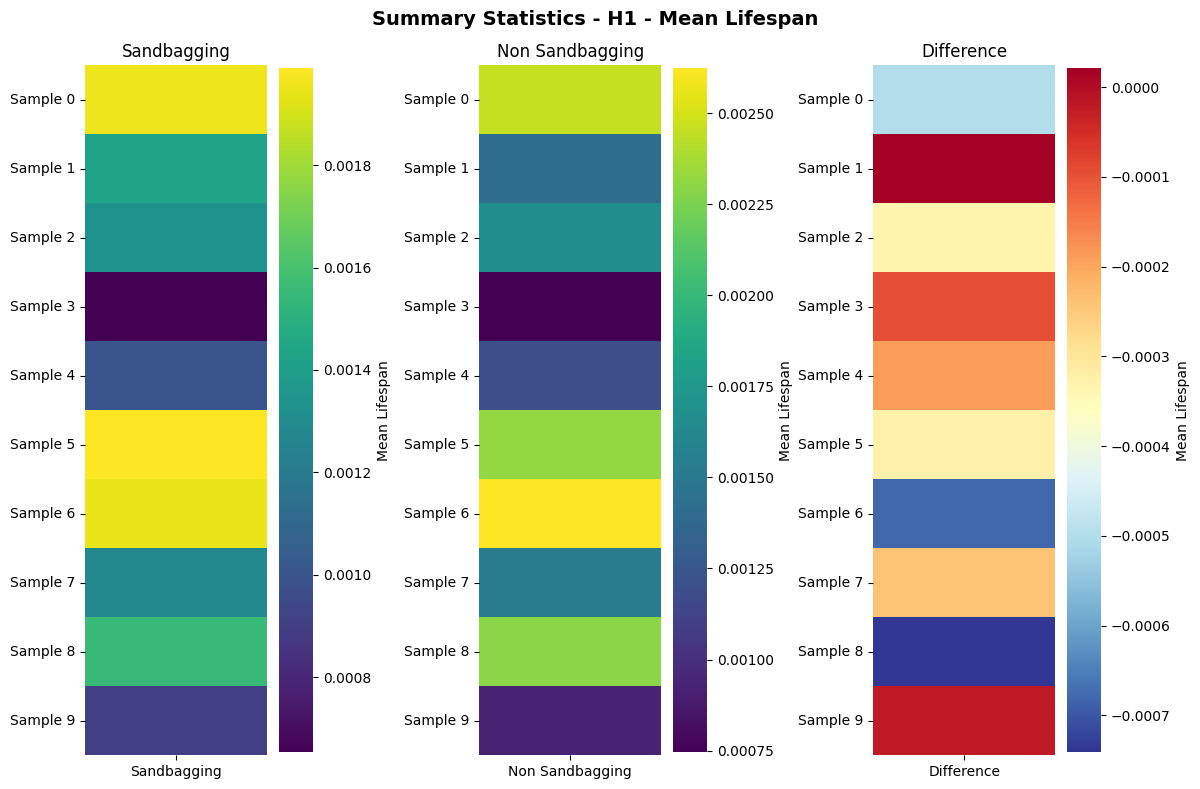


Total Persistence:


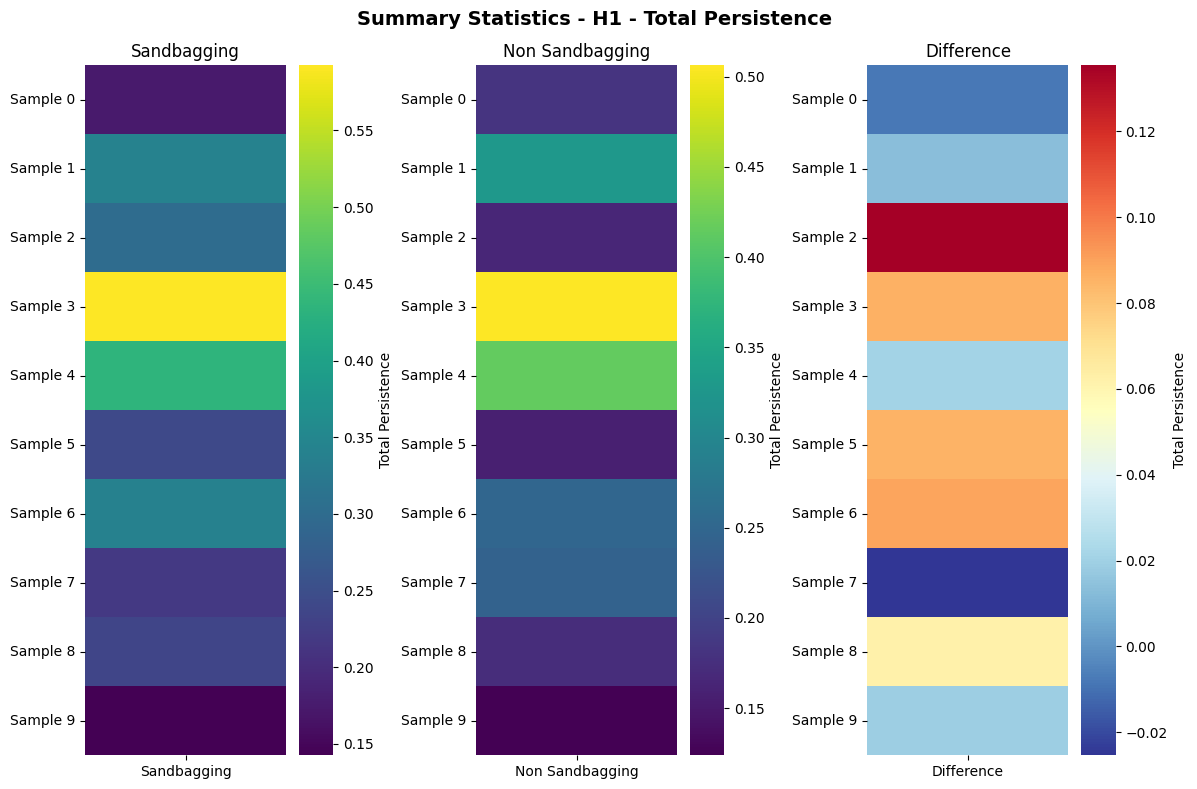


Number of Features:


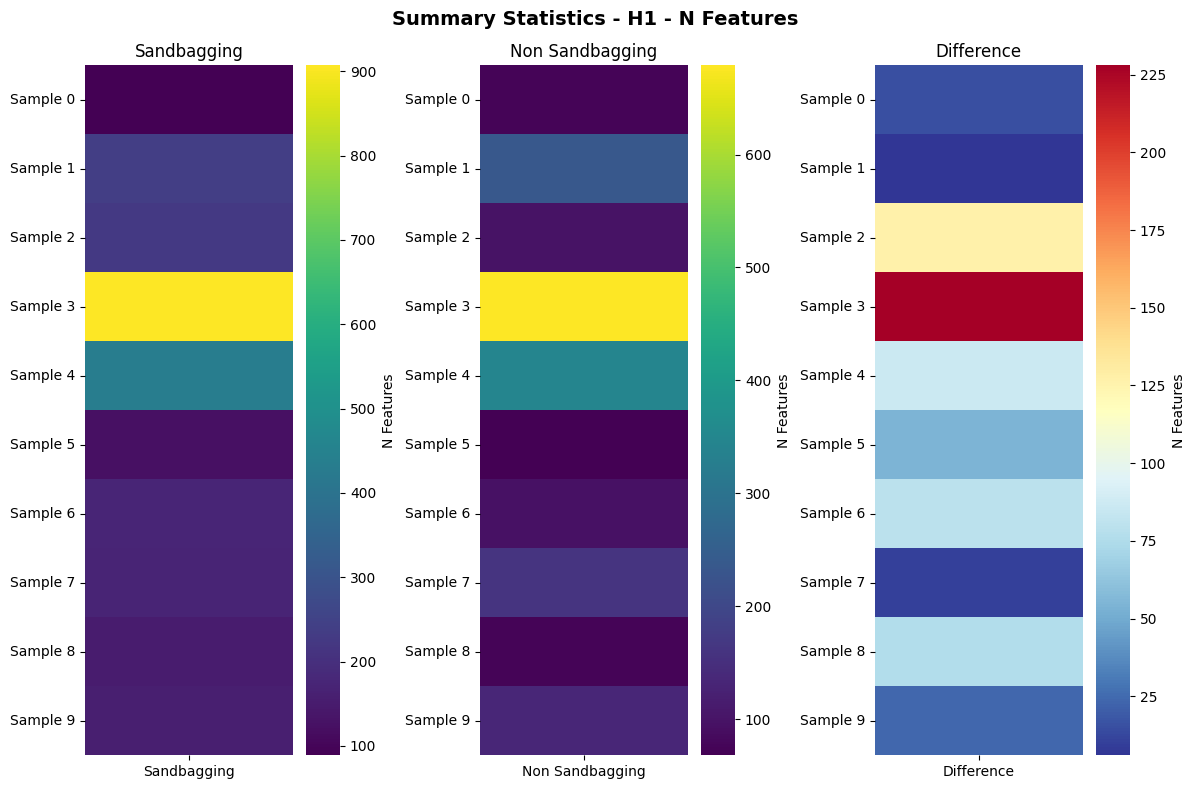


4. BOTTLENECK / WASSERSTEIN DISTANCE BAR CHARTS
Quantifying topological distance between conditions...

Bottleneck Distance (H1):


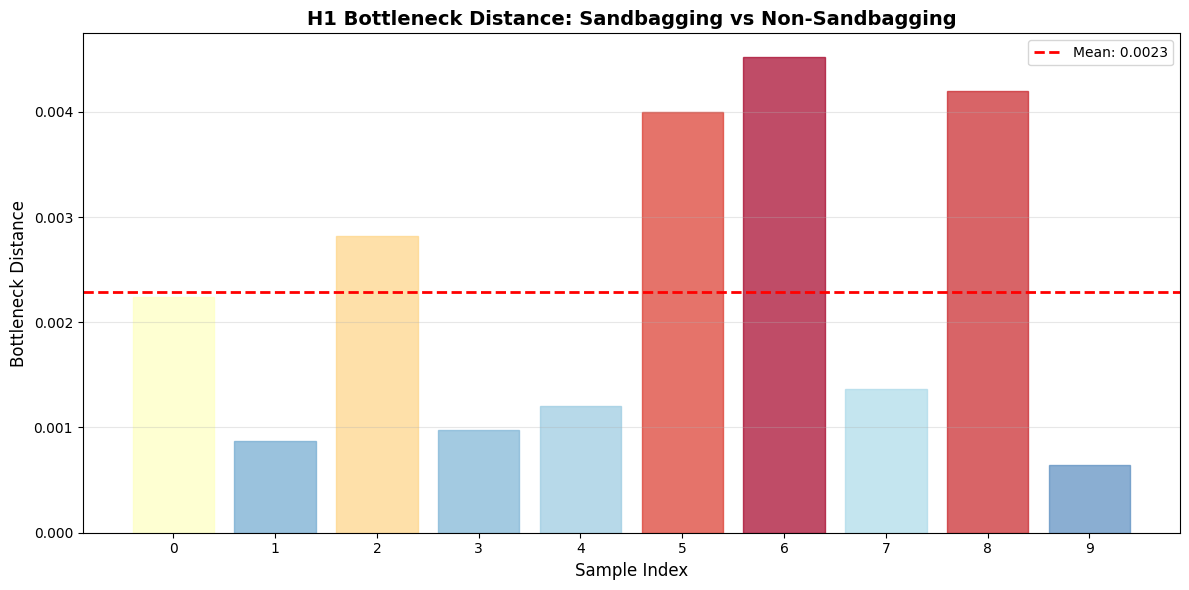


Wasserstein Distance (H1):


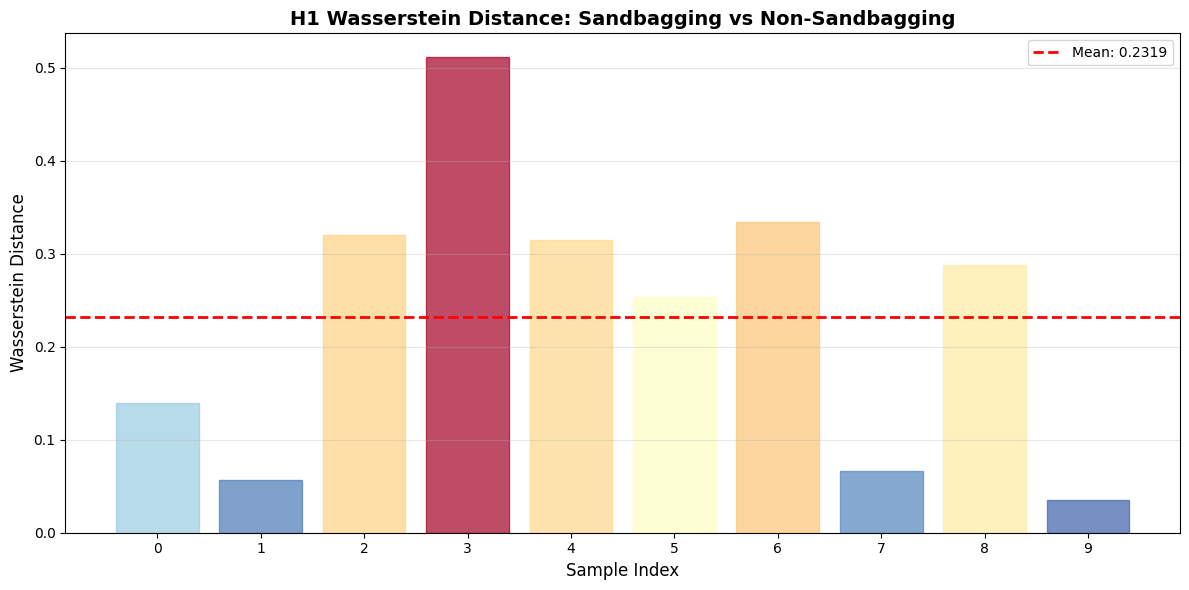


Distance Comparison across H0 and H1:


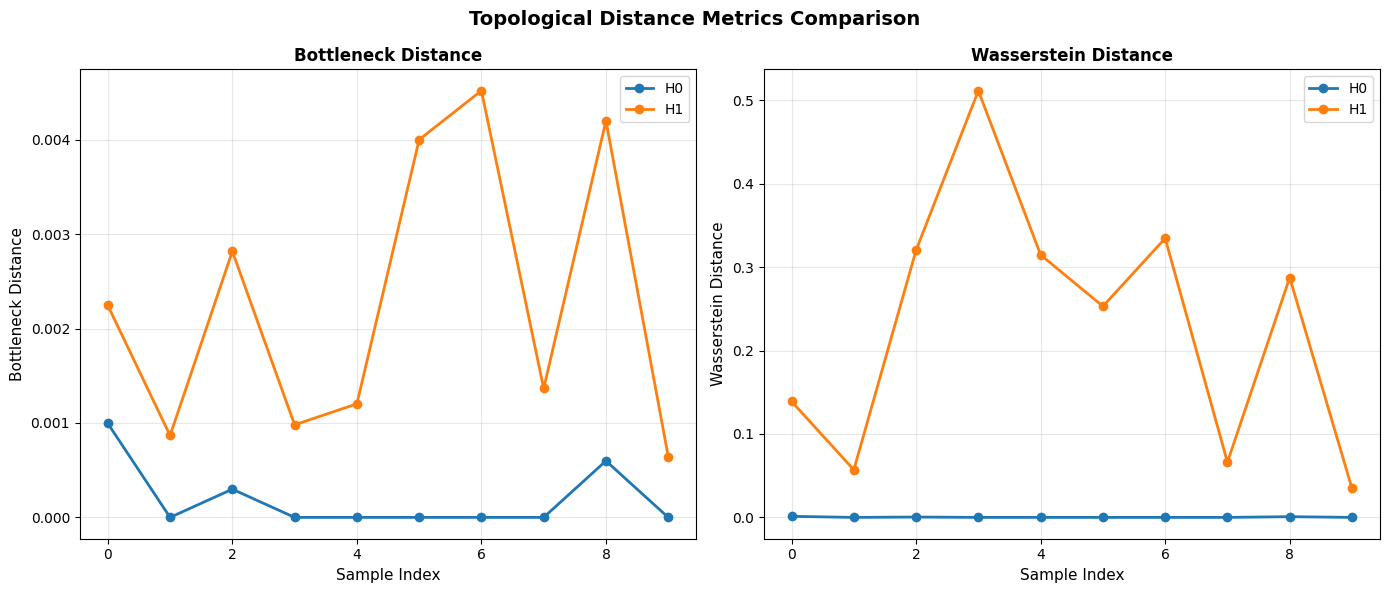


📊 Distance Statistics (H1):
   Bottleneck - Mean: 0.0023, Std: 0.0014
   Wasserstein - Mean: 0.2319, Std: 0.1458

5. LAYER-WISE LINE PLOTS
Analyzing how topology changes across model layers...

⚠ Only one layer experiment found.
To use layer-wise analysis, run experiments with different layer indices:
  Example: layer=0, layer=1, layer=2, etc.

Showing single-layer analysis instead...



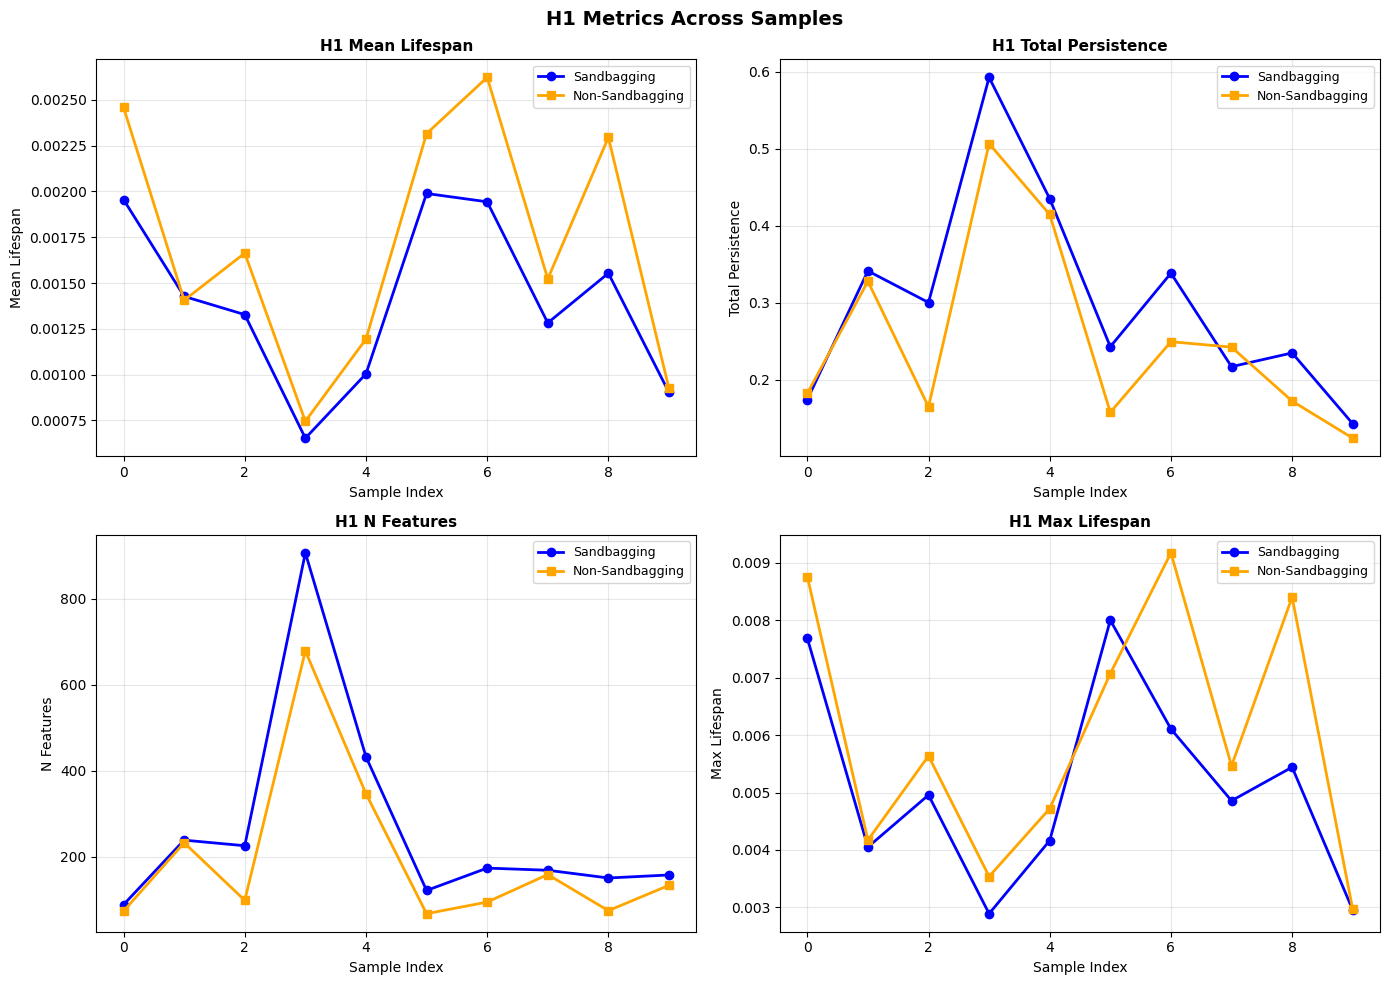


📊 SUMMARY REPORT

Experiment: google_electra-small-discriminator
Total samples: 10

🔹 Average H1 Statistics:

  Sandbagging:
    Mean Lifespan: 0.0014
    N Features: 266.8000
    Total Persistence: 0.3017

  Non-Sandbagging:
    Mean Lifespan: 0.0017
    N Features: 196.3000
    Total Persistence: 0.2540

🔹 Average Topological Distance:
    Bottleneck Distance: 0.0023 ± 0.0014

🔍 Key Findings:
   • Non-sandbagging produces 22.1% longer H1 lifespans
   • Average H1 features: Sandbagging=266.8, Non-sandbagging=196.3
   • Sample 6 shows largest topological change (distance=0.0045)

✅ Analysis complete!

To save visualizations, uncomment the save_dir parameters in the plotting functions.


In [21]:
if __name__ == "__main__":
    # Run full demonstration on specified experiment
    # main takes in a path name with that has the data previously generated by text_to_attention_save.ipynb
    main("/workspace/experiments/google_electra-small-discriminator")

ADVANCED TDA VISUALIZATION NOTEBOOK

Loading experiment from: distilbert-base-uncased

Loading data from: /workspace/experiments/distilbert-base-uncased
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

1. 2D KERNEL DENSITY DIFFERENCE MAPS
Computing KDE for sandbagging and non-sandbagging distributions...
Bright regions show where one distribution dominates.



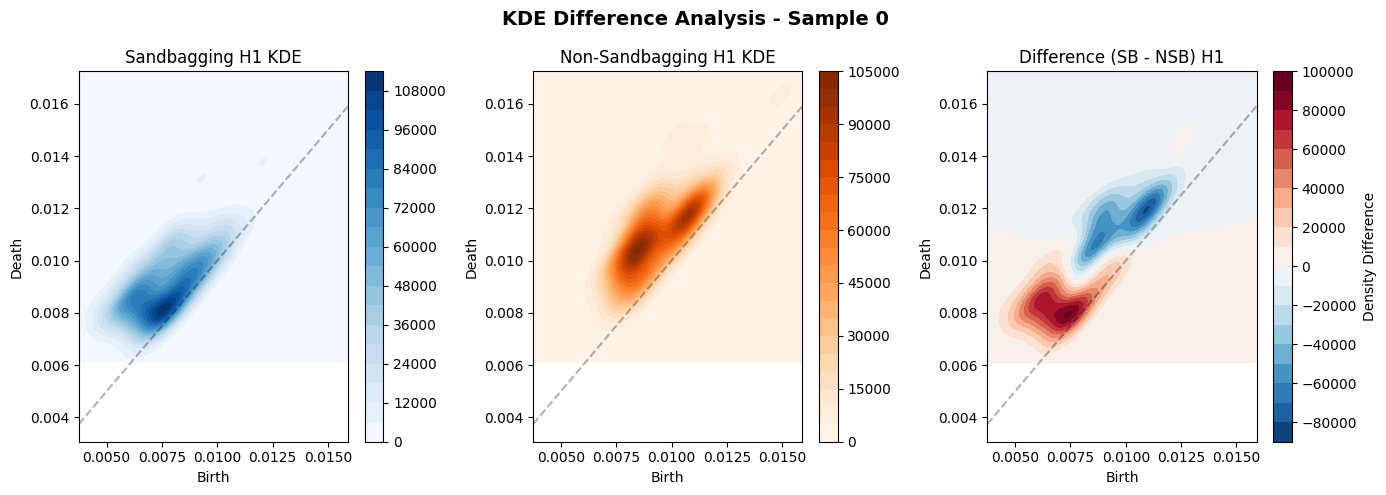


2. CONTOUR OVERLAYS
Plotting filled contours to show overlap and spread...



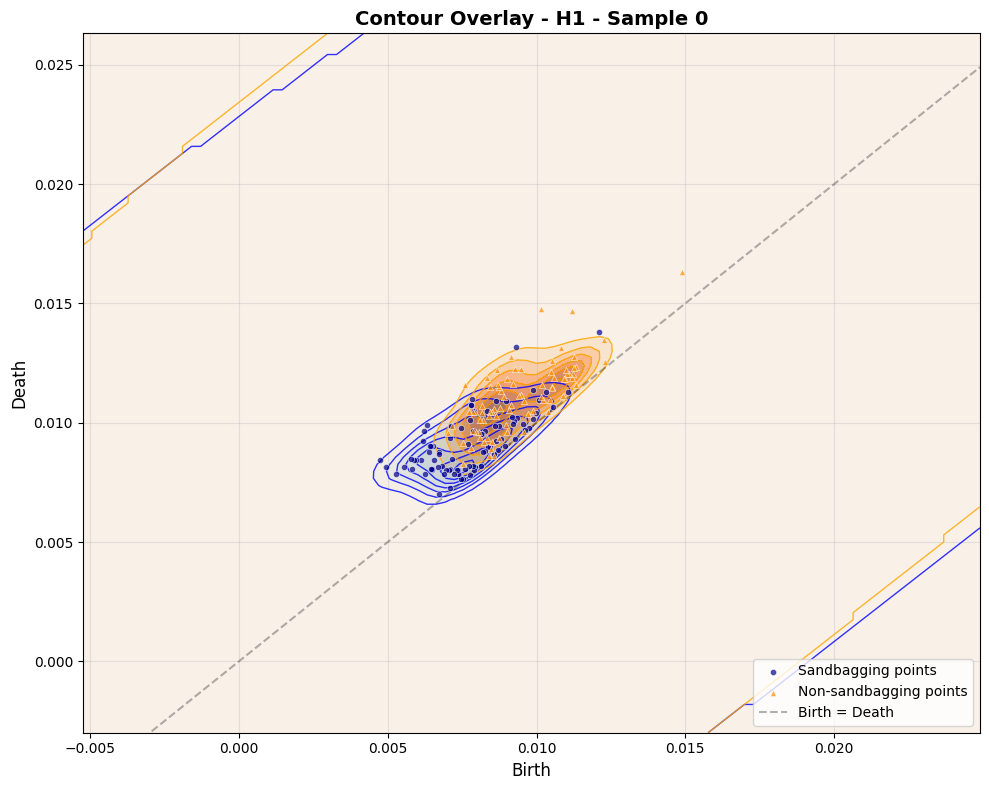


H0 Contour Overlay:
⚠ Warning: No finite points found for H0 in sample 0


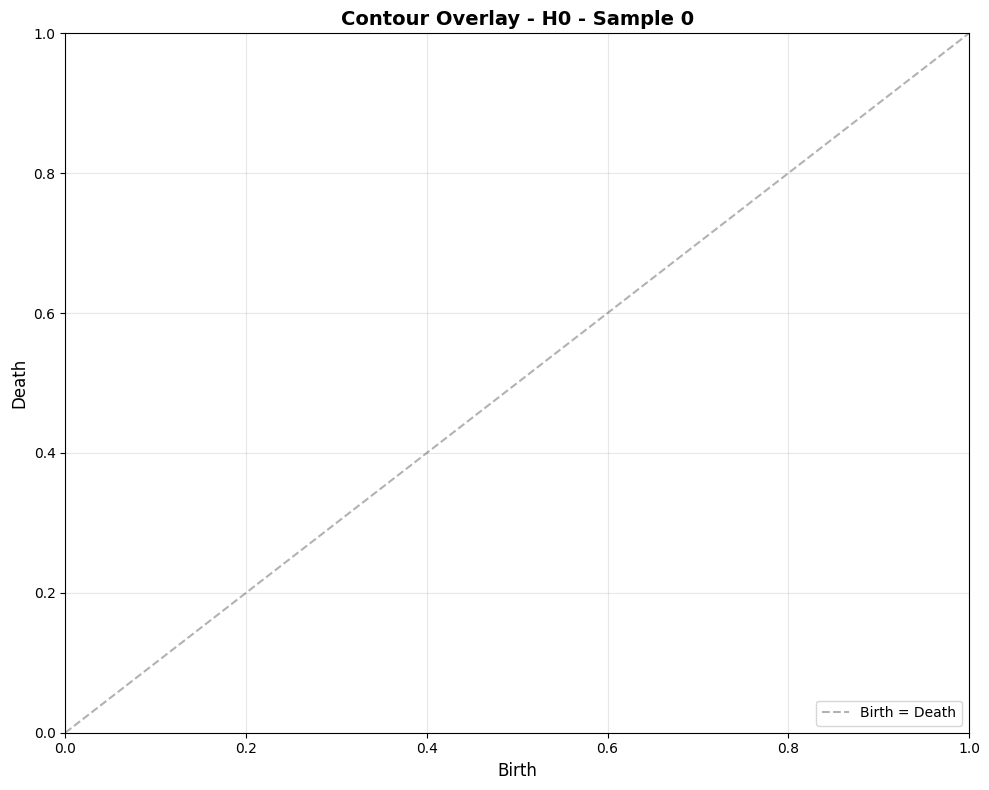


3. SUMMARY STATISTICS HEATMAP
Visualizing metrics across samples...

Mean H1 Lifespan:


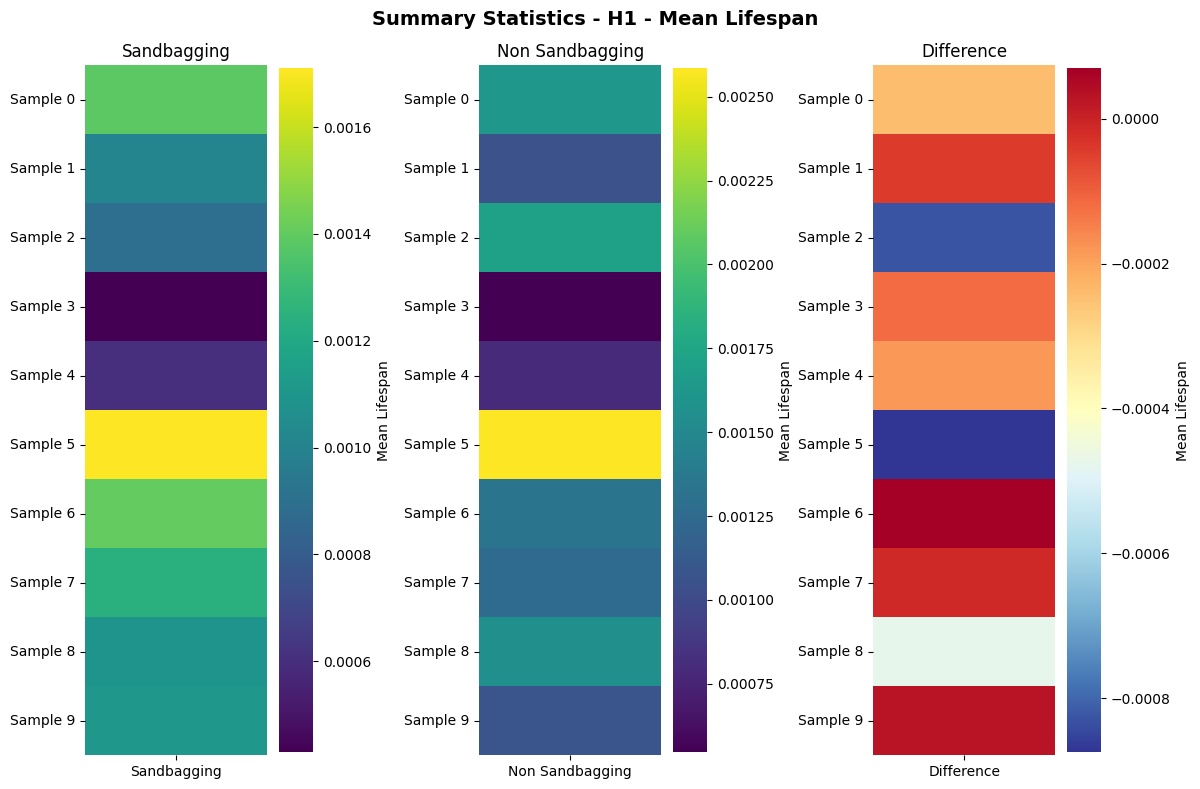


Total Persistence:


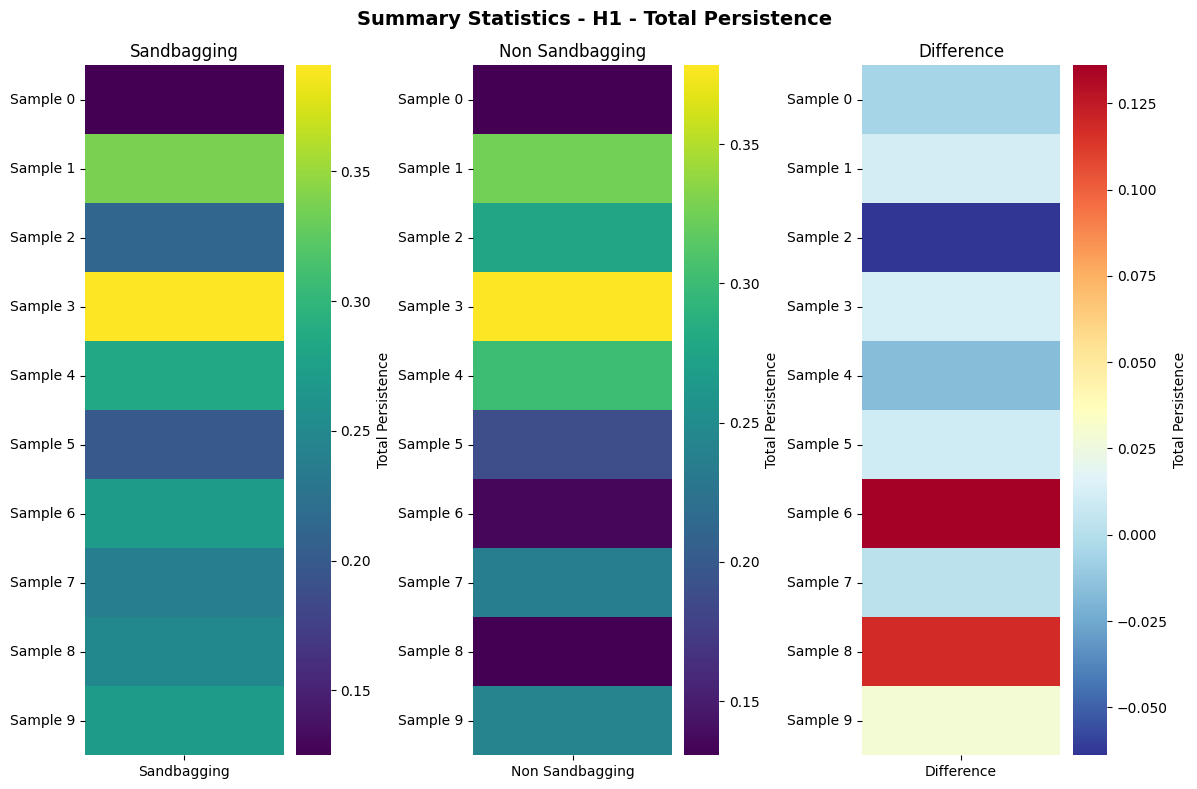


Number of Features:


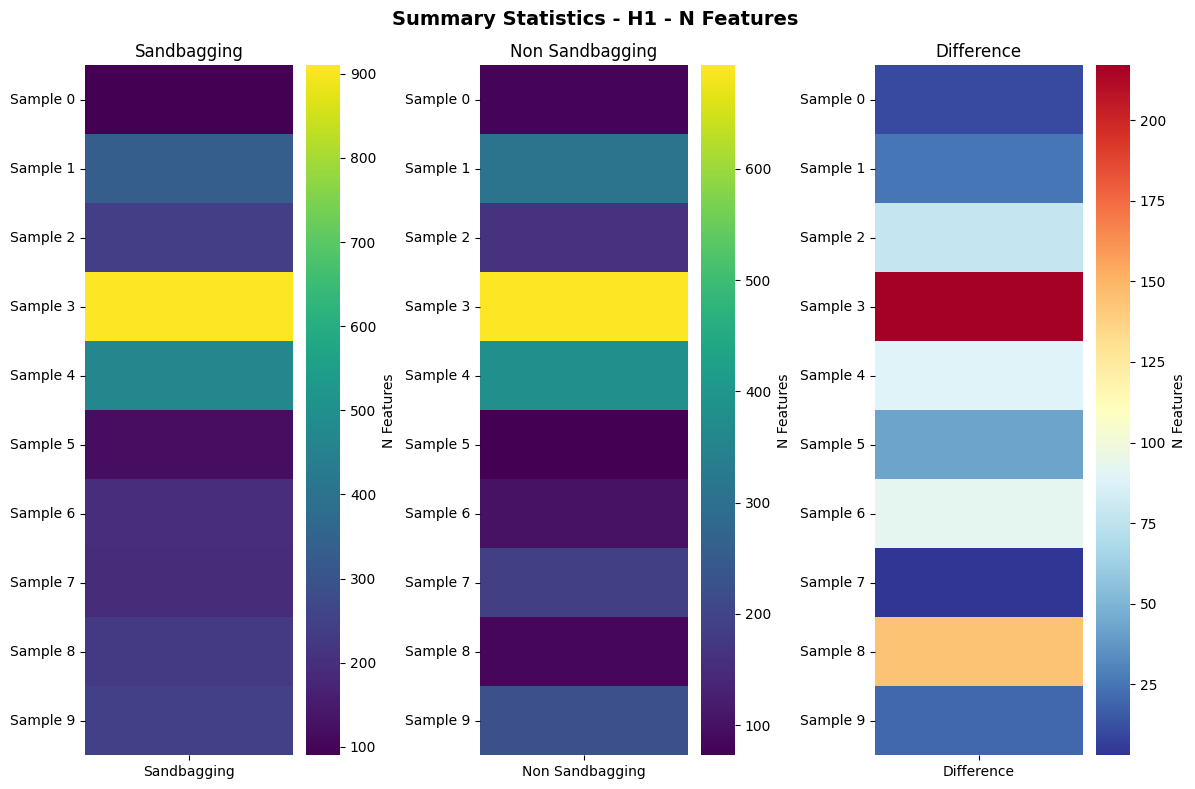


4. BOTTLENECK / WASSERSTEIN DISTANCE BAR CHARTS
Quantifying topological distance between conditions...

Bottleneck Distance (H1):


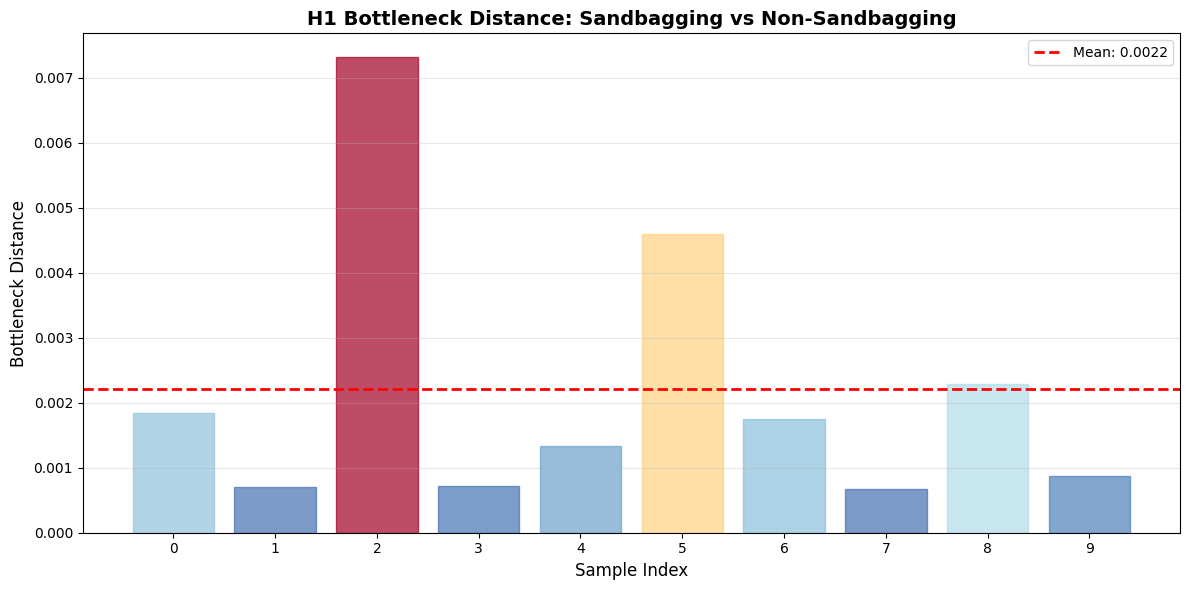


Wasserstein Distance (H1):


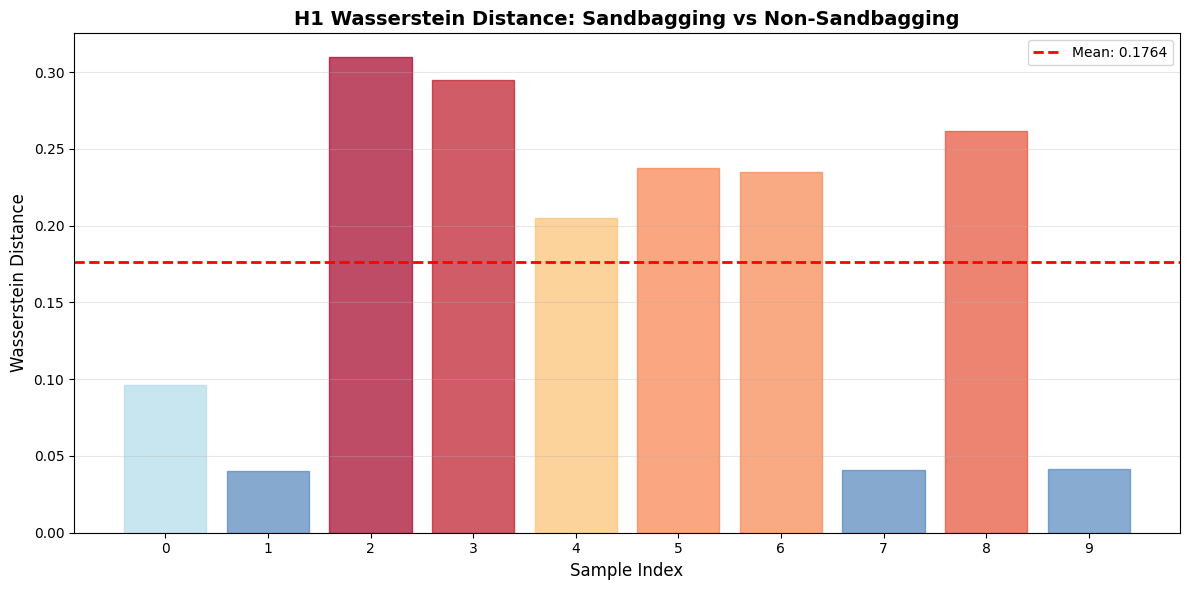


Distance Comparison across H0 and H1:


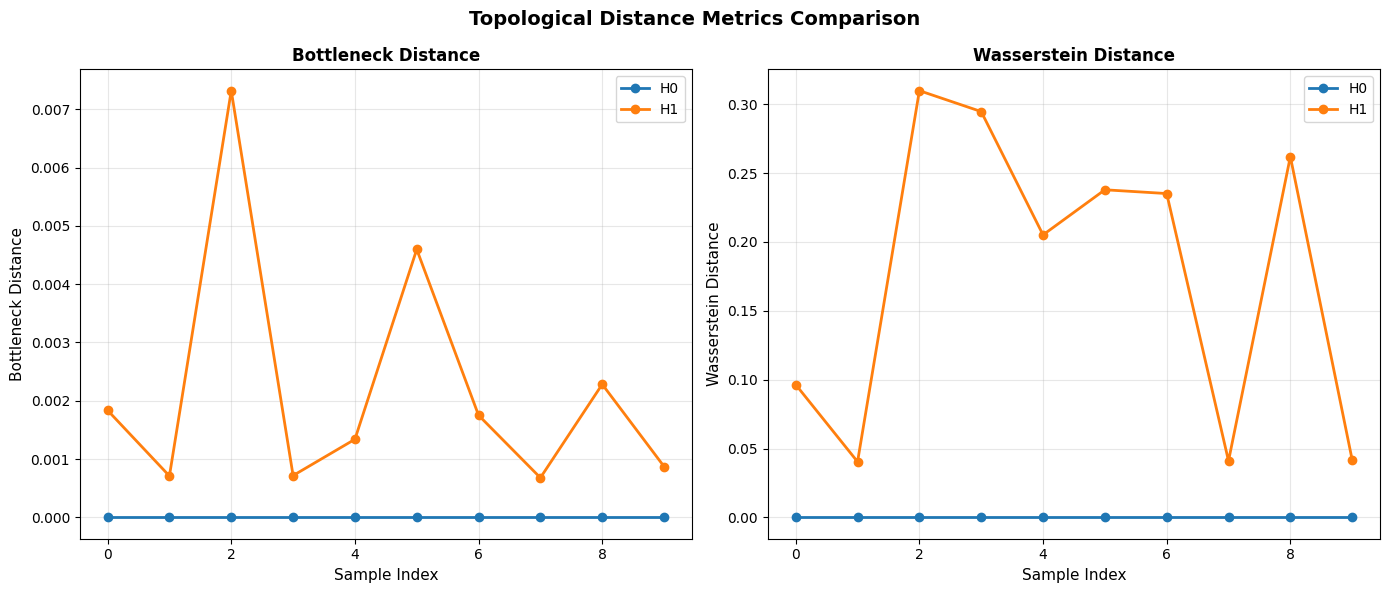


📊 Distance Statistics (H1):
   Bottleneck - Mean: 0.0022, Std: 0.0020
   Wasserstein - Mean: 0.1764, Std: 0.1042

5. LAYER-WISE LINE PLOTS
Analyzing how topology changes across model layers...

⚠ Only one layer experiment found.
To use layer-wise analysis, run experiments with different layer indices:
  Example: layer=0, layer=1, layer=2, etc.

Showing single-layer analysis instead...



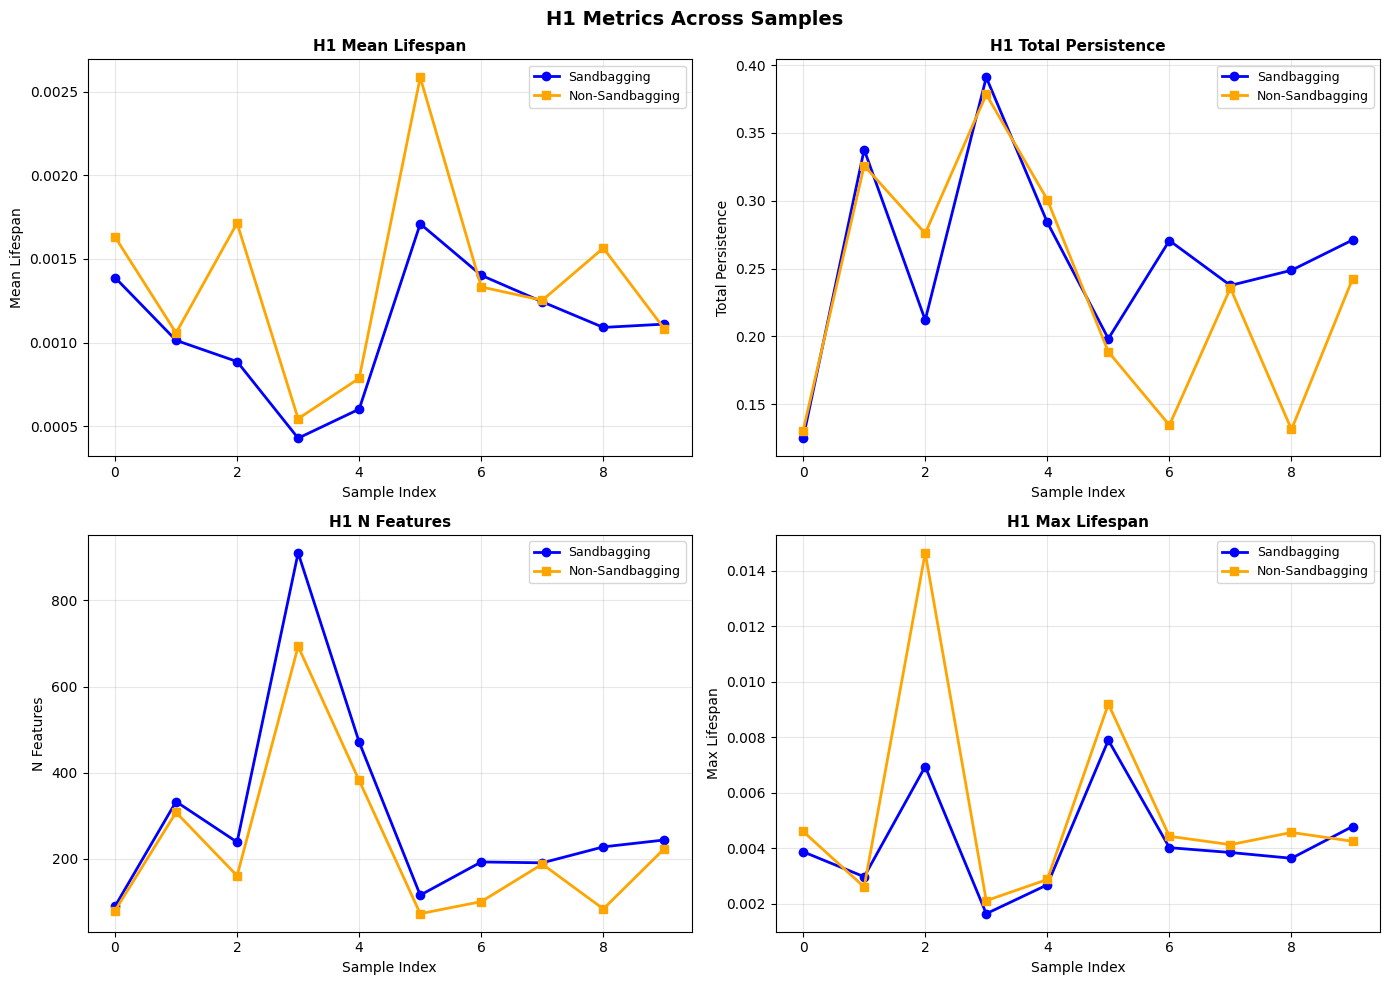


📊 SUMMARY REPORT

Experiment: distilbert-base-uncased
Total samples: 10

🔹 Average H1 Statistics:

  Sandbagging:
    Mean Lifespan: 0.0011
    N Features: 301.5000
    Total Persistence: 0.2576

  Non-Sandbagging:
    Mean Lifespan: 0.0014
    N Features: 229.4000
    Total Persistence: 0.2344

🔹 Average Topological Distance:
    Bottleneck Distance: 0.0022 ± 0.0020

🔍 Key Findings:
   • Non-sandbagging produces 24.6% longer H1 lifespans
   • Average H1 features: Sandbagging=301.5, Non-sandbagging=229.4
   • Sample 2 shows largest topological change (distance=0.0073)

✅ Analysis complete!

To save visualizations, uncomment the save_dir parameters in the plotting functions.


In [22]:
if __name__ == "__main__":
    # Run full demonstration on specified experiment
    # main takes in a path name with that has the data previously generated by text_to_attention_save.ipynb
    main("/workspace/experiments/distilbert-base-uncased")

ADVANCED TDA VISUALIZATION NOTEBOOK

Loading experiment from: bert-base-uncased

Loading data from: /workspace/experiments/bert-base-uncased
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

1. 2D KERNEL DENSITY DIFFERENCE MAPS
Computing KDE for sandbagging and non-sandbagging distributions...
Bright regions show where one distribution dominates.



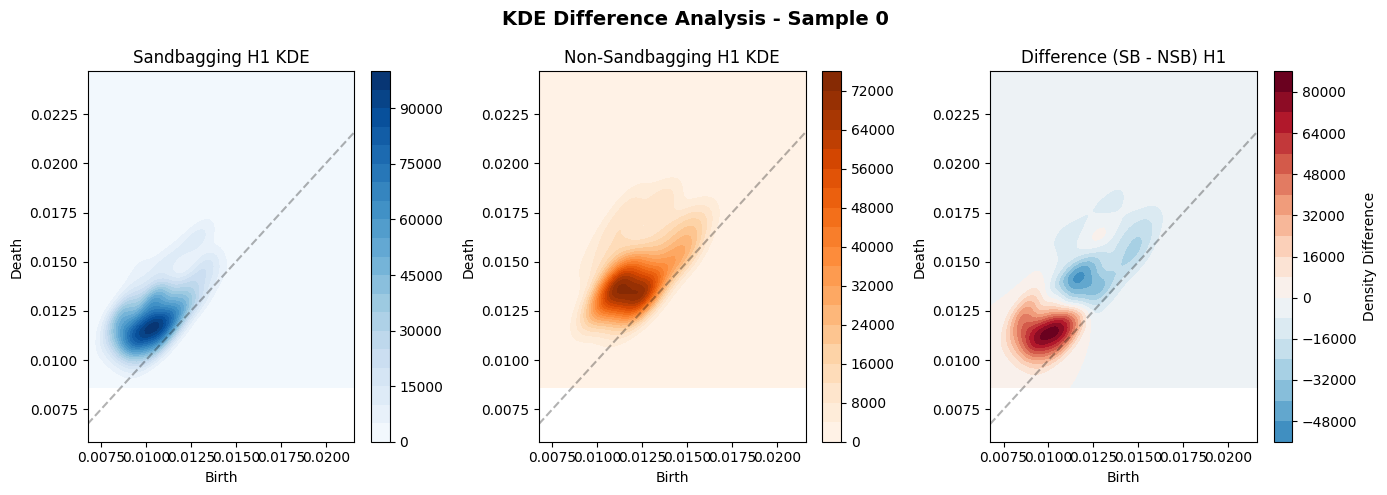


2. CONTOUR OVERLAYS
Plotting filled contours to show overlap and spread...



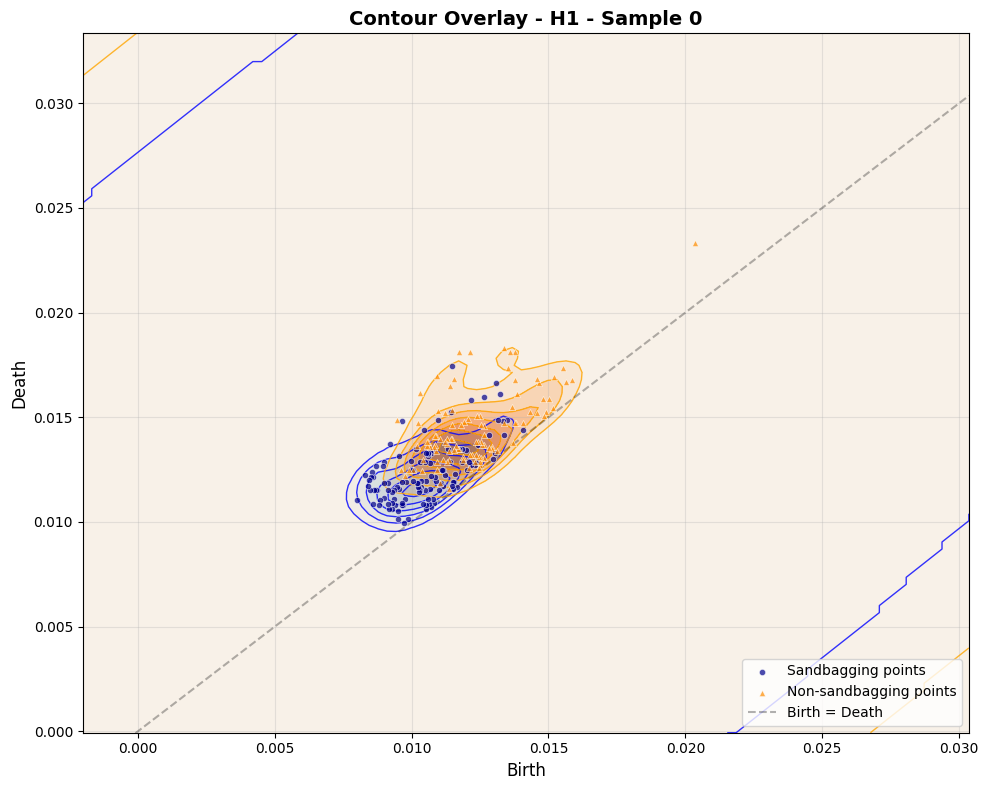


H0 Contour Overlay:
⚠ Warning: No finite points found for H0 in sample 0


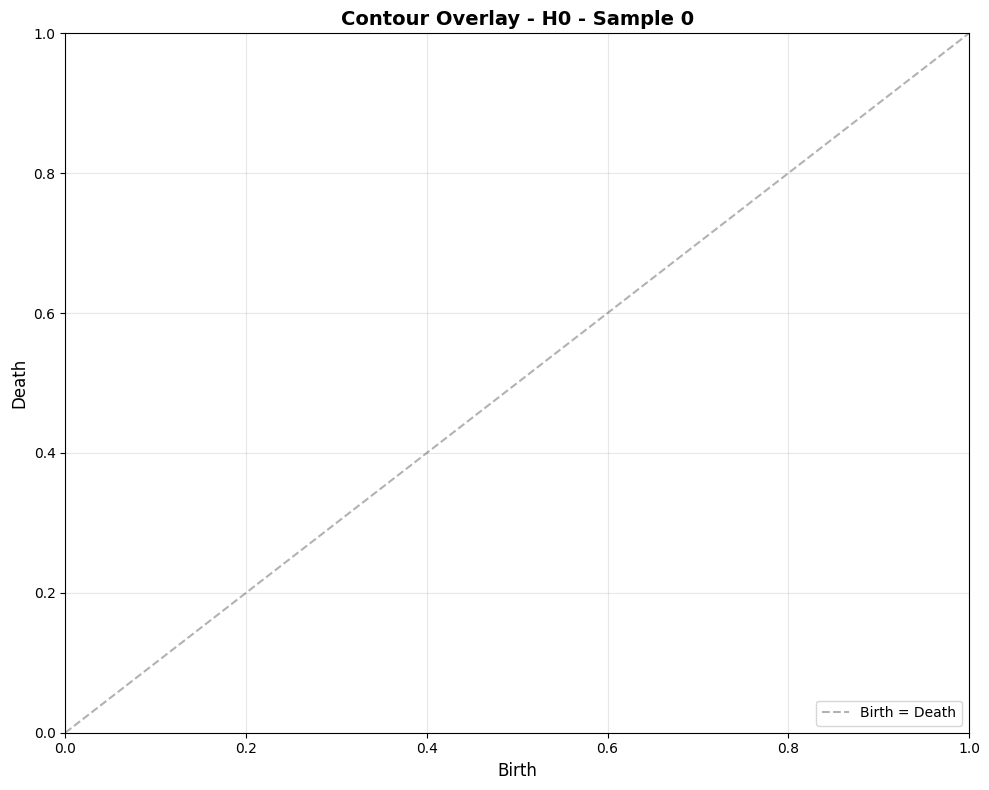


3. SUMMARY STATISTICS HEATMAP
Visualizing metrics across samples...

Mean H1 Lifespan:


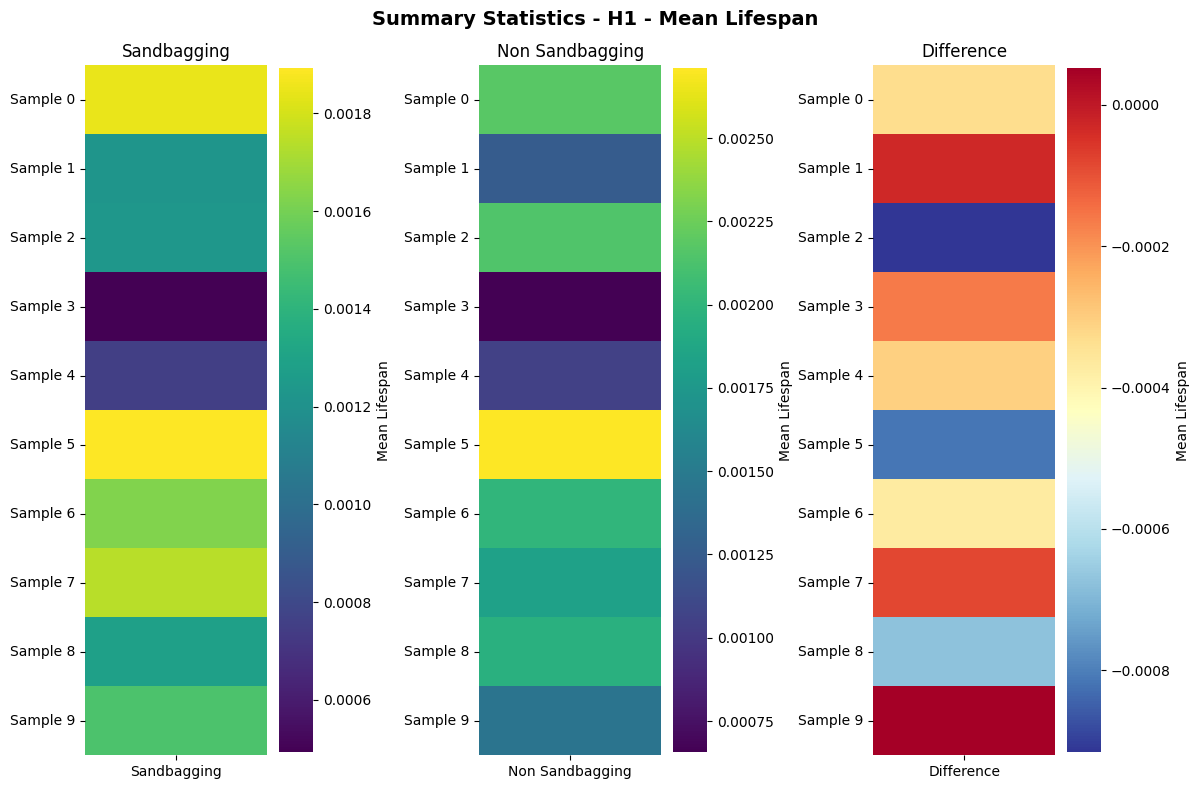


Total Persistence:


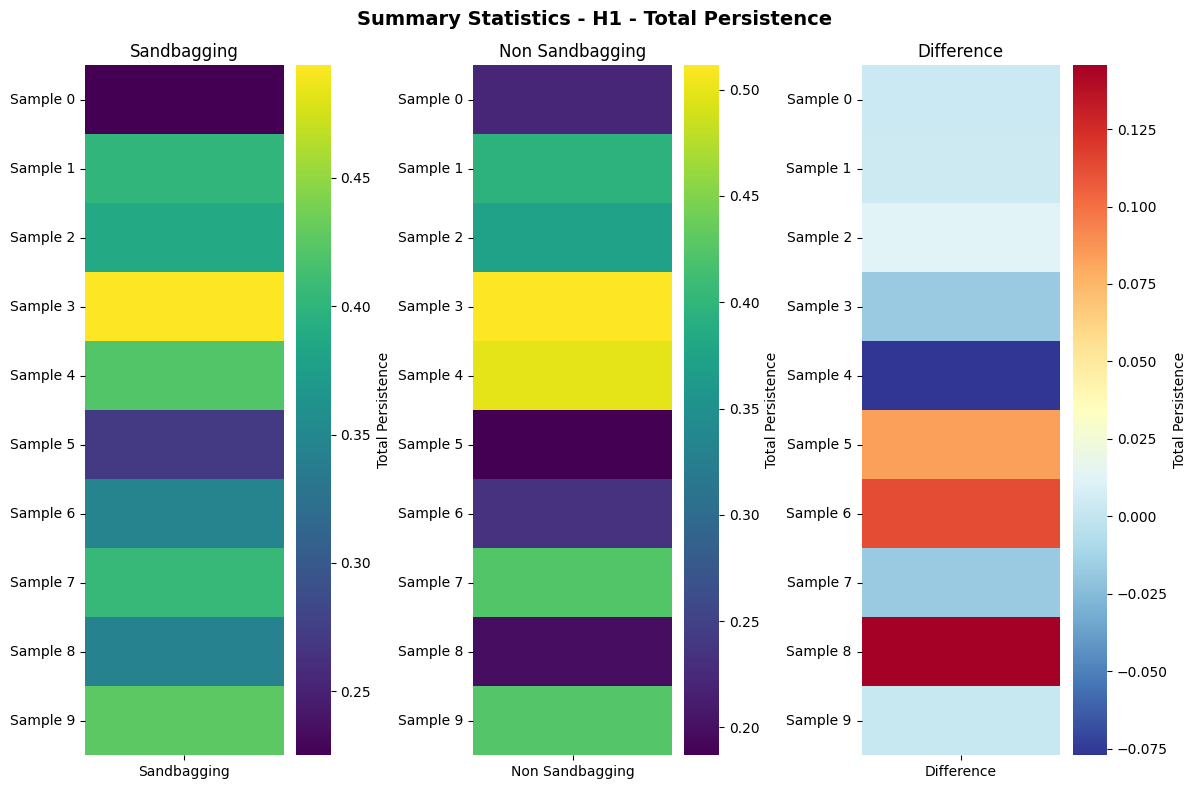


Number of Features:


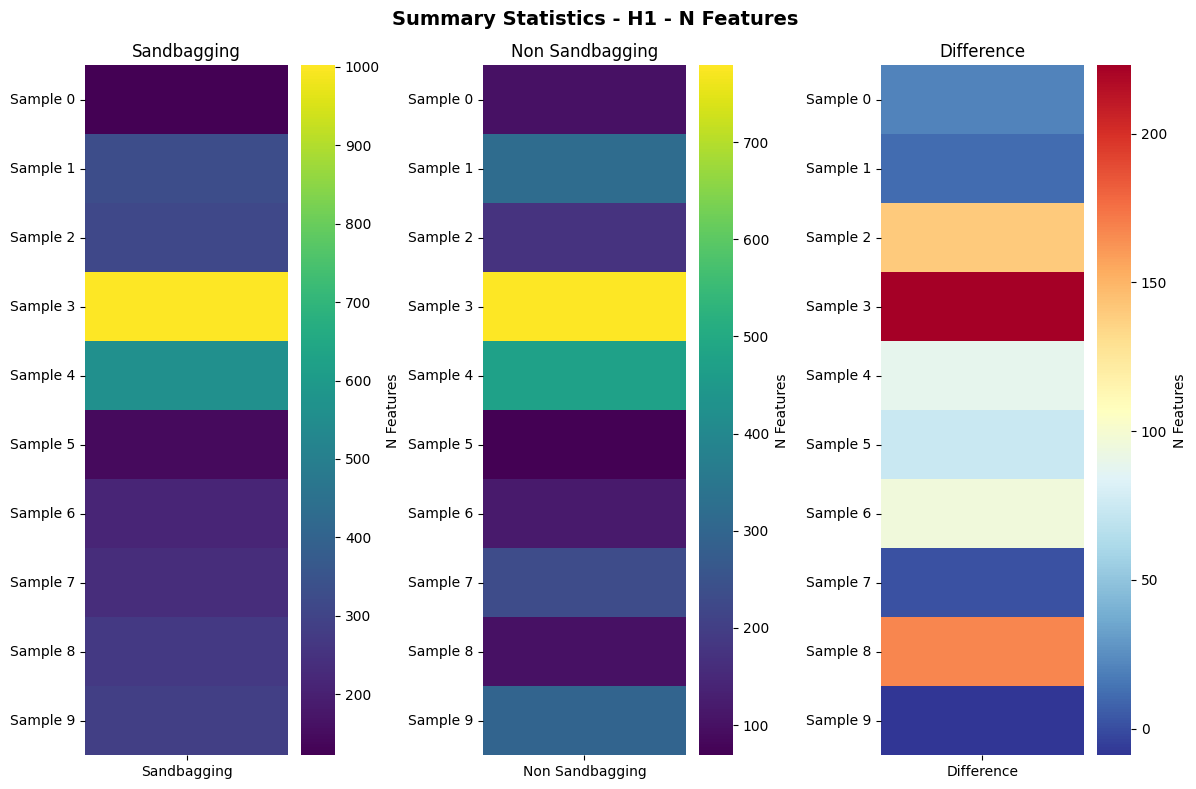


4. BOTTLENECK / WASSERSTEIN DISTANCE BAR CHARTS
Quantifying topological distance between conditions...

Bottleneck Distance (H1):


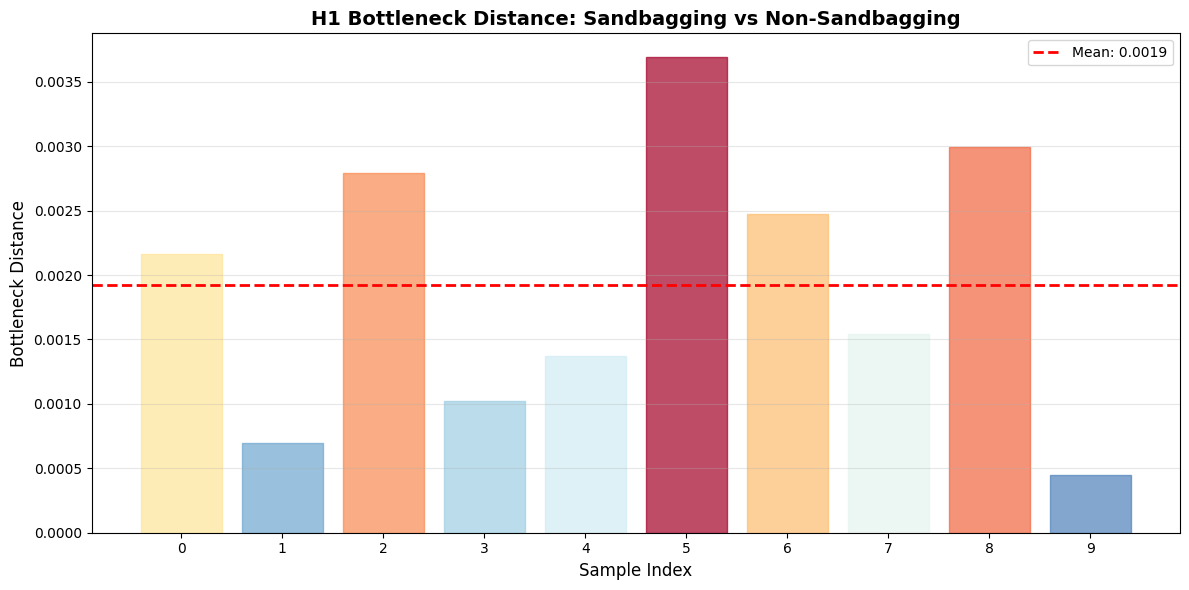


Wasserstein Distance (H1):


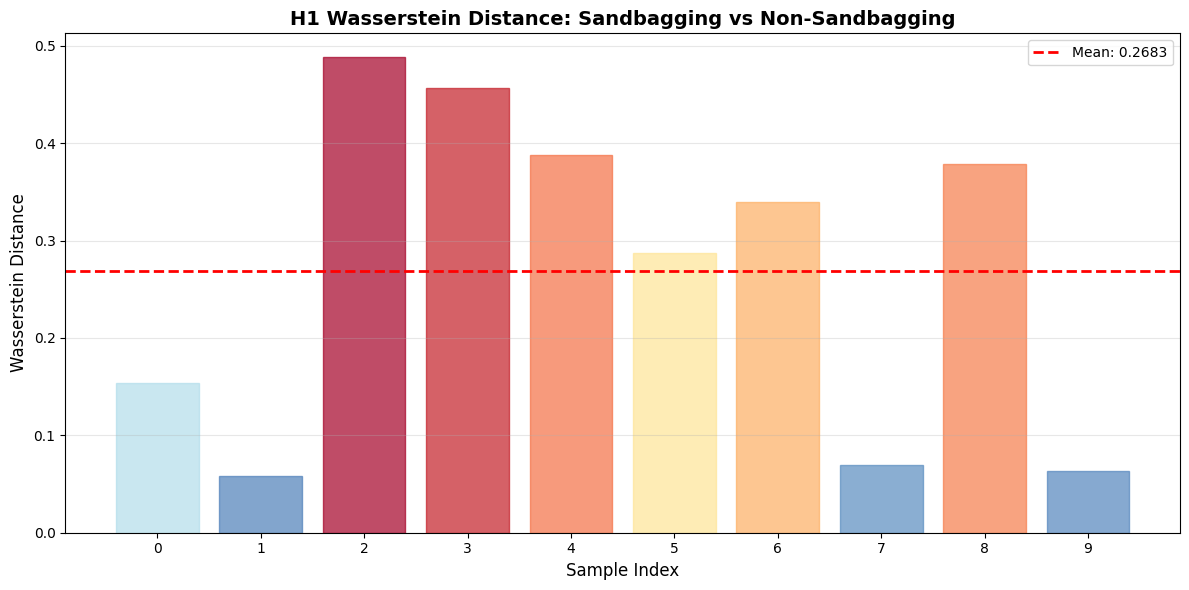


Distance Comparison across H0 and H1:


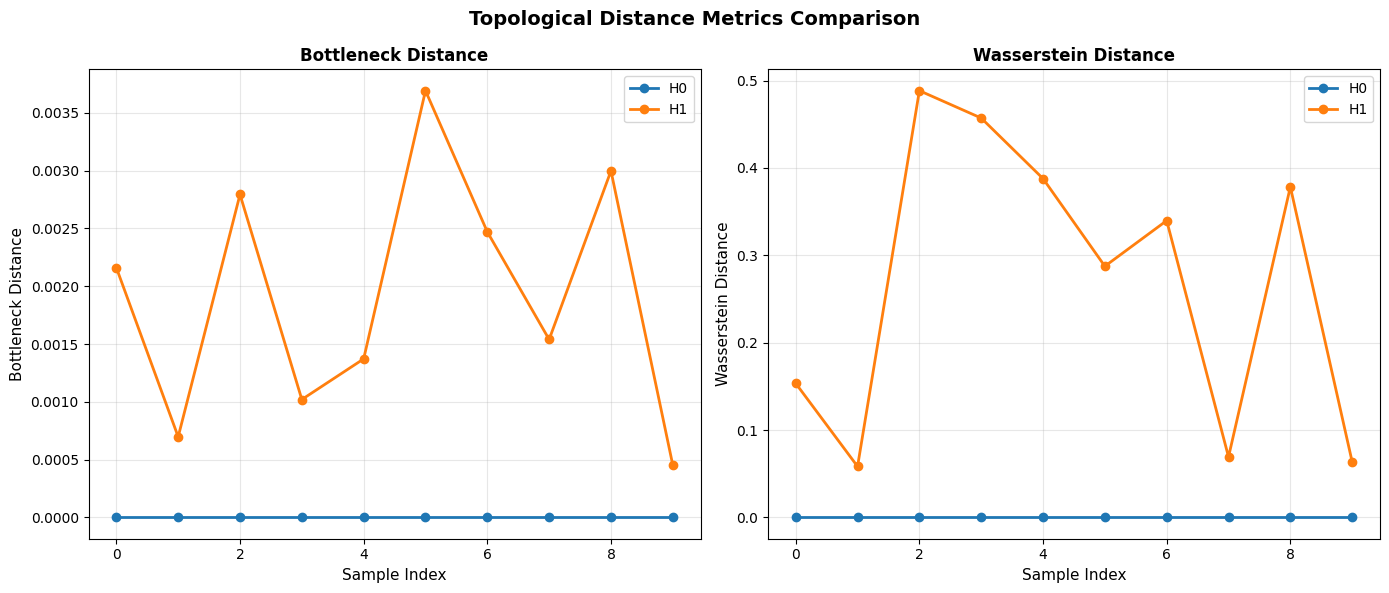


📊 Distance Statistics (H1):
   Bottleneck - Mean: 0.0019, Std: 0.0010
   Wasserstein - Mean: 0.2683, Std: 0.1596

5. LAYER-WISE LINE PLOTS
Analyzing how topology changes across model layers...

⚠ Only one layer experiment found.
To use layer-wise analysis, run experiments with different layer indices:
  Example: layer=0, layer=1, layer=2, etc.

Showing single-layer analysis instead...



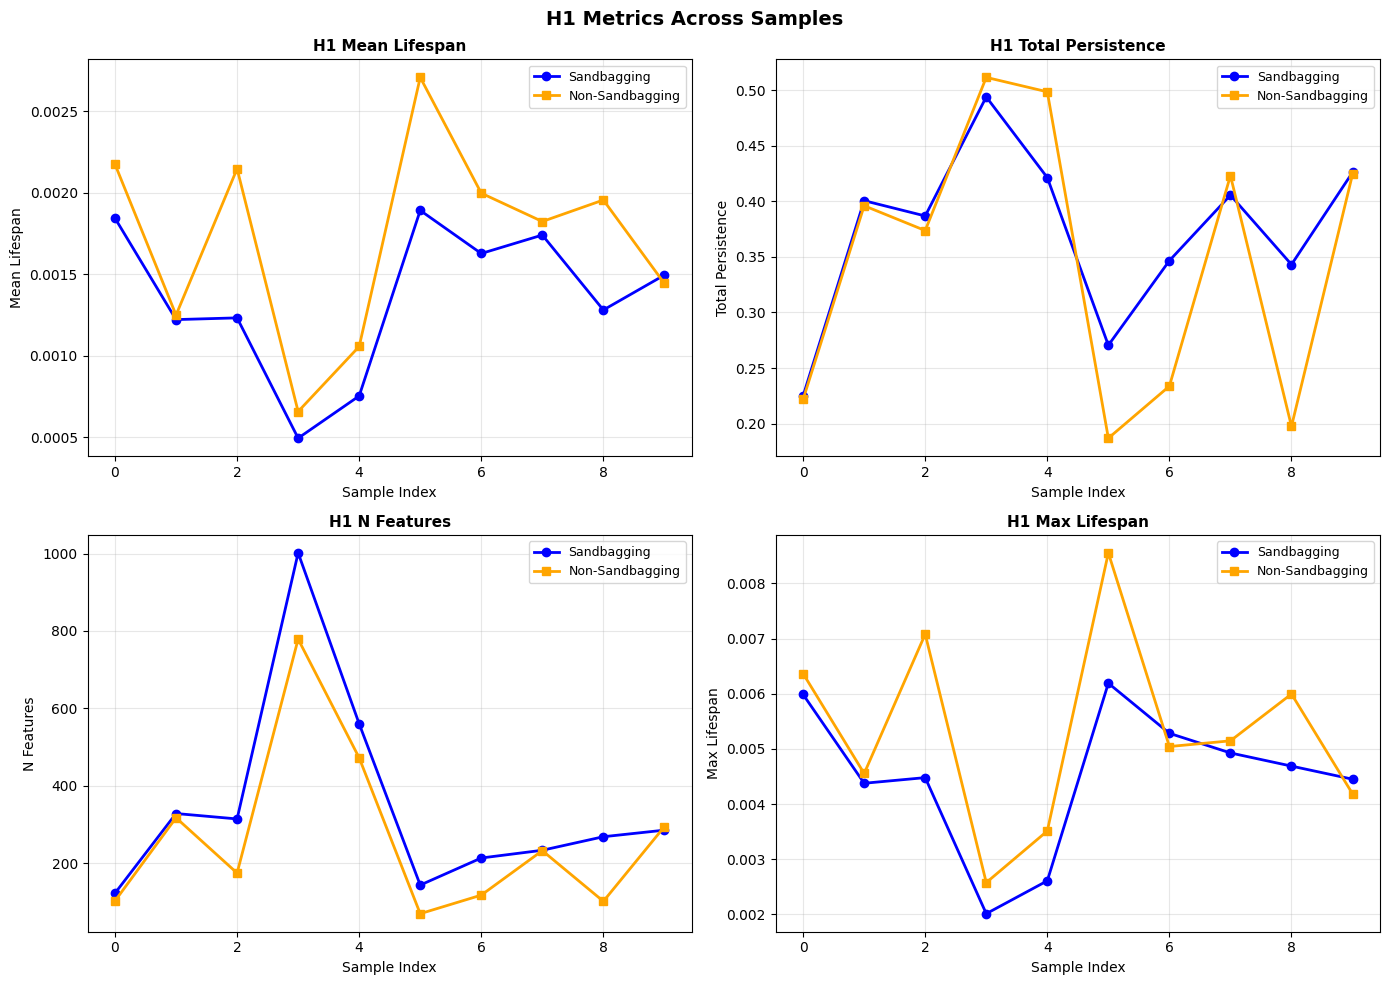


📊 SUMMARY REPORT

Experiment: bert-base-uncased
Total samples: 10

🔹 Average H1 Statistics:

  Sandbagging:
    Mean Lifespan: 0.0014
    N Features: 346.8000
    Total Persistence: 0.3719

  Non-Sandbagging:
    Mean Lifespan: 0.0017
    N Features: 265.7000
    Total Persistence: 0.3467

🔹 Average Topological Distance:
    Bottleneck Distance: 0.0019 ± 0.0010

🔍 Key Findings:
   • Non-sandbagging produces 26.8% longer H1 lifespans
   • Average H1 features: Sandbagging=346.8, Non-sandbagging=265.7
   • Sample 5 shows largest topological change (distance=0.0037)

✅ Analysis complete!

To save visualizations, uncomment the save_dir parameters in the plotting functions.


In [23]:
if __name__ == "__main__":
    # Run full demonstration on specified experiment
    # main takes in a path name with that has the data previously generated by text_to_attention_save.ipynb
    main("/workspace/experiments/bert-base-uncased")

ADVANCED TDA VISUALIZATION NOTEBOOK

Loading experiment from: roberta-base

Loading data from: /workspace/experiments/roberta-base
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

1. 2D KERNEL DENSITY DIFFERENCE MAPS
Computing KDE for sandbagging and non-sandbagging distributions...
Bright regions show where one distribution dominates.



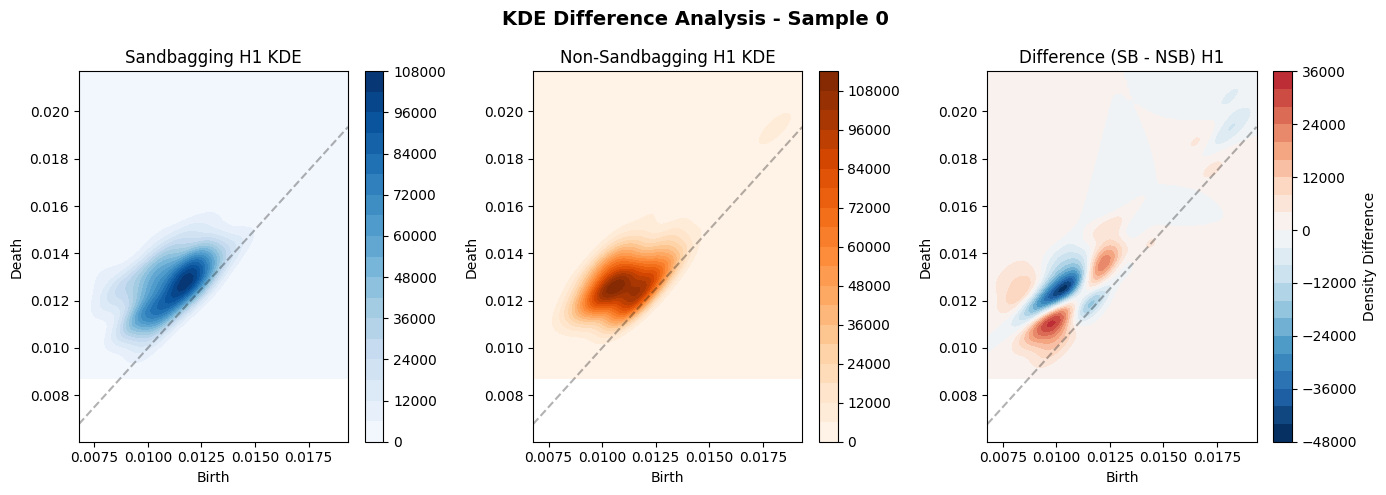


2. CONTOUR OVERLAYS
Plotting filled contours to show overlap and spread...



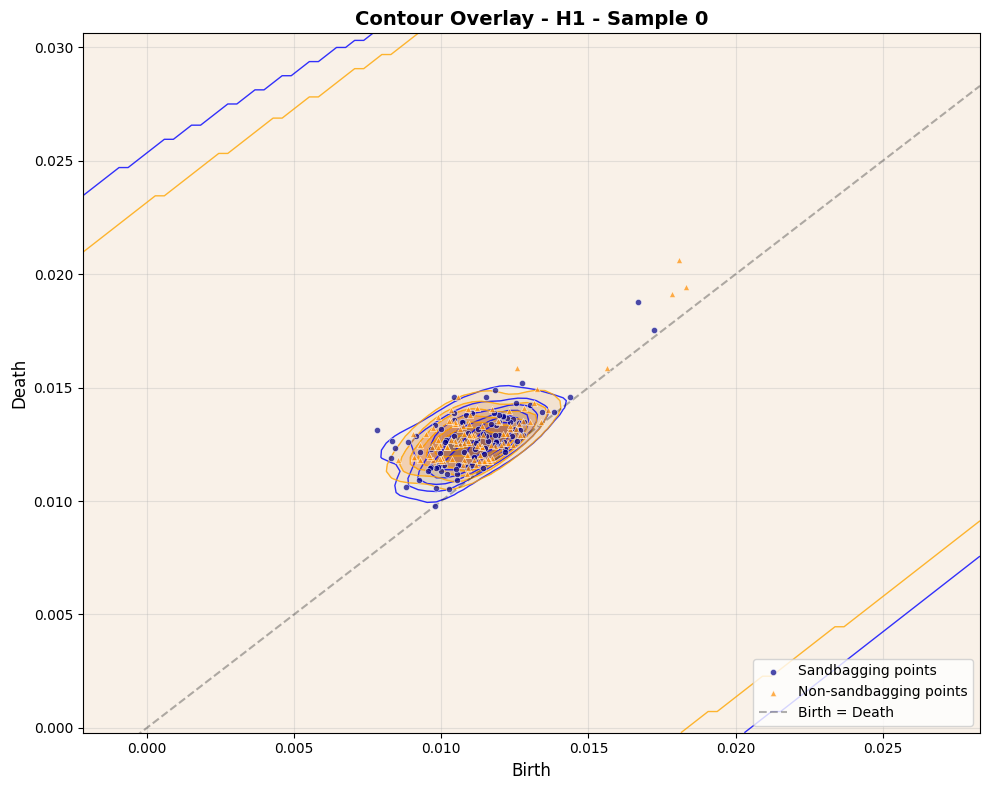


H0 Contour Overlay:
⚠ Warning: No finite points found for H0 in sample 0


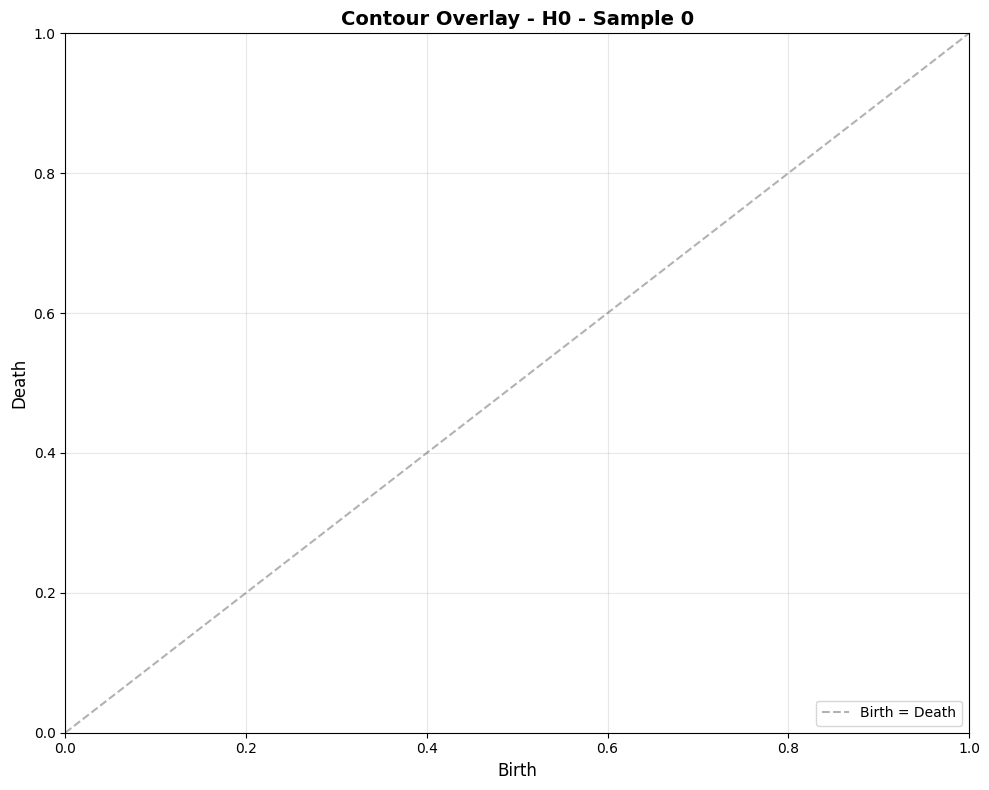


3. SUMMARY STATISTICS HEATMAP
Visualizing metrics across samples...

Mean H1 Lifespan:


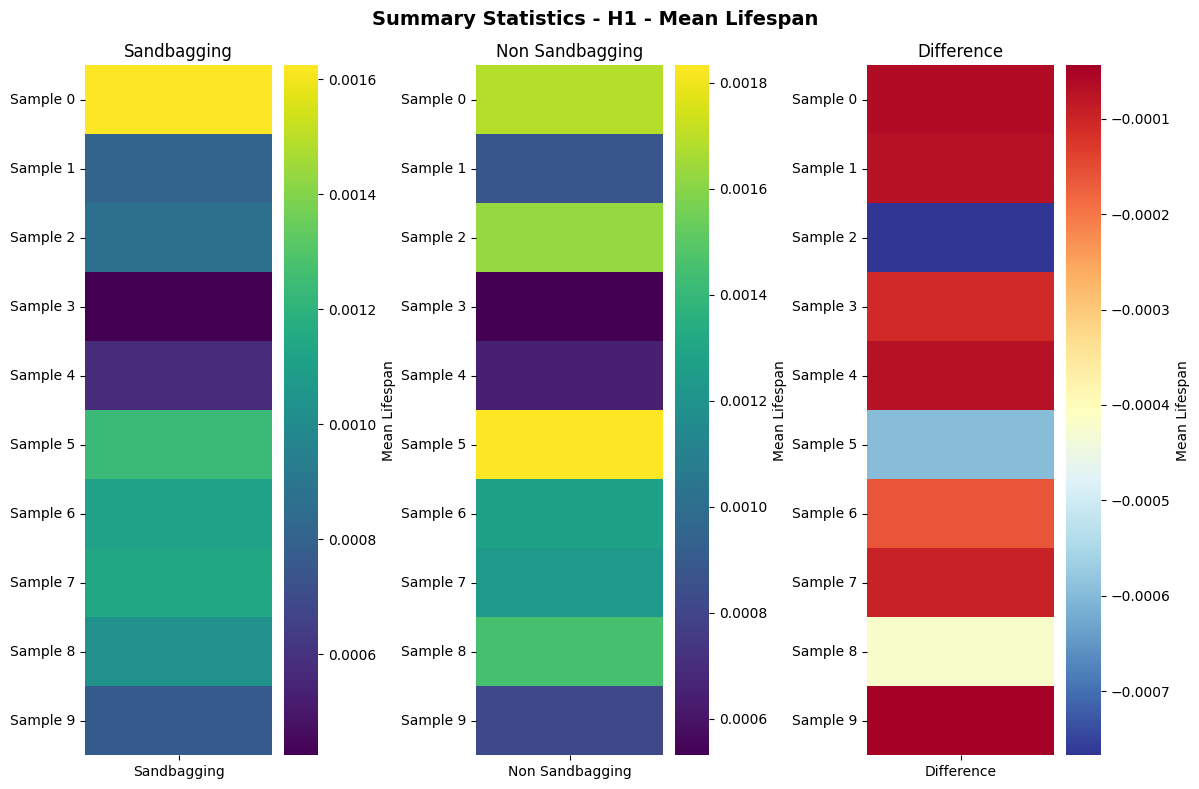


Total Persistence:


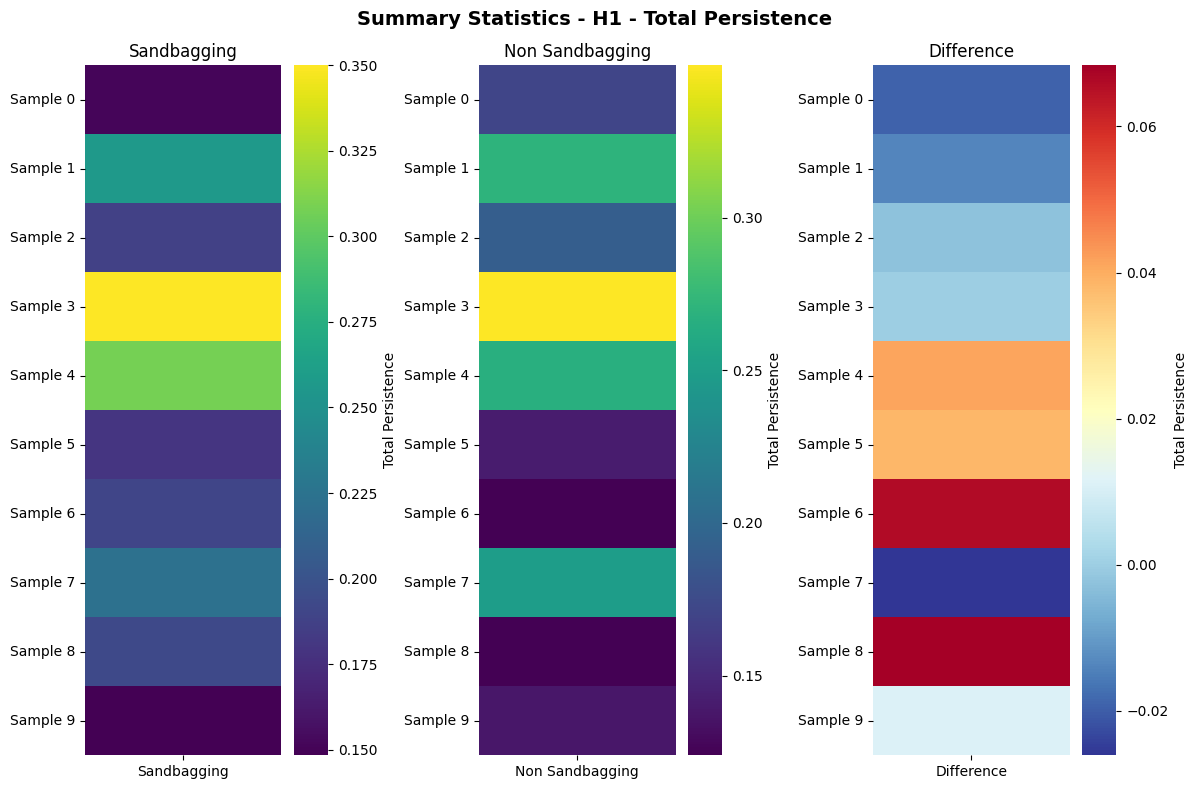


Number of Features:


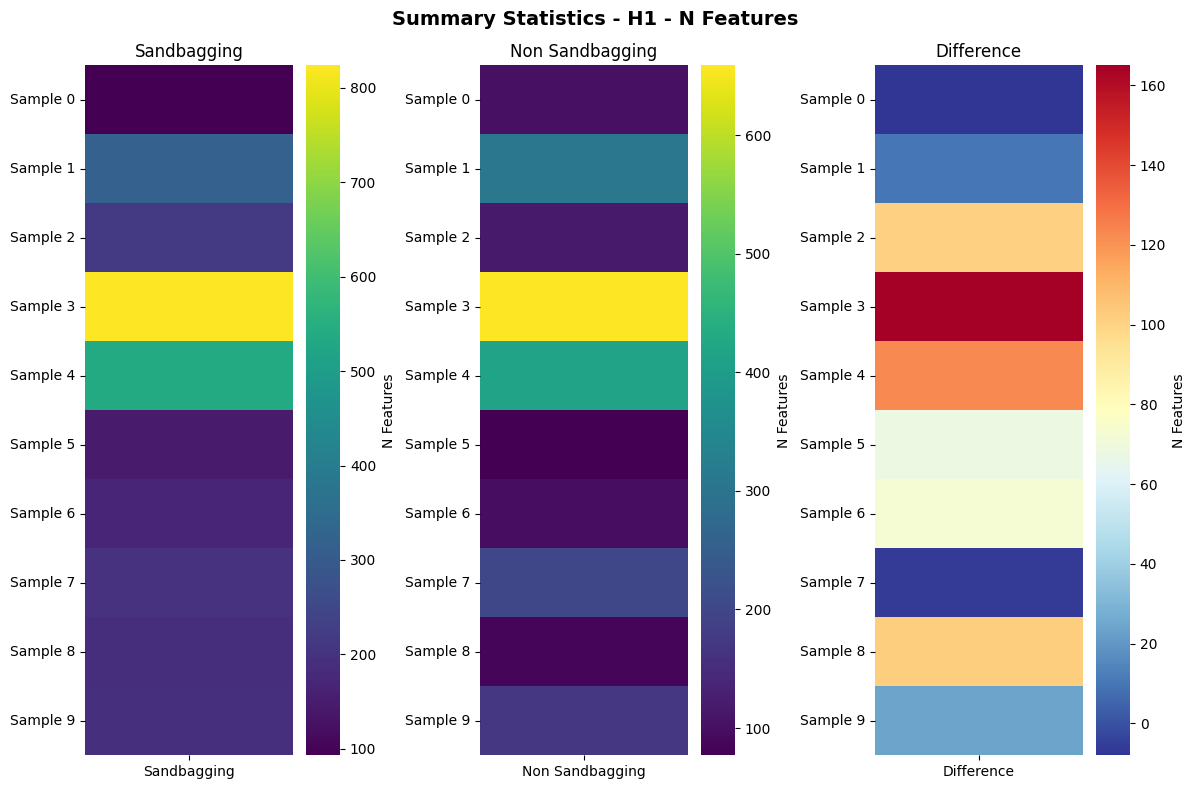


4. BOTTLENECK / WASSERSTEIN DISTANCE BAR CHARTS
Quantifying topological distance between conditions...

Bottleneck Distance (H1):


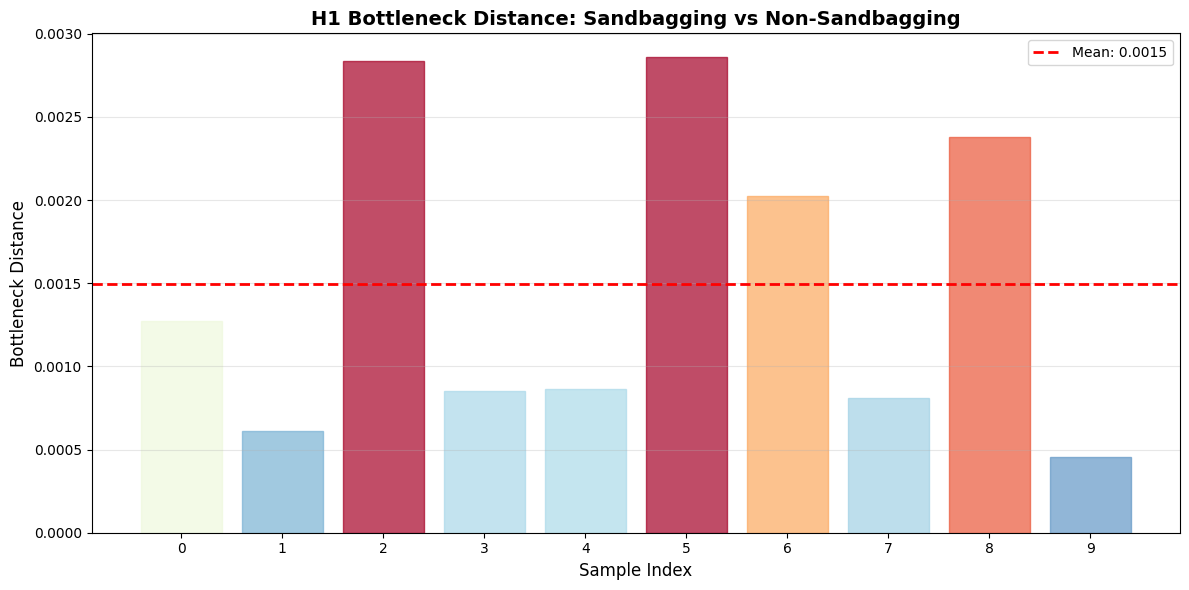


Wasserstein Distance (H1):


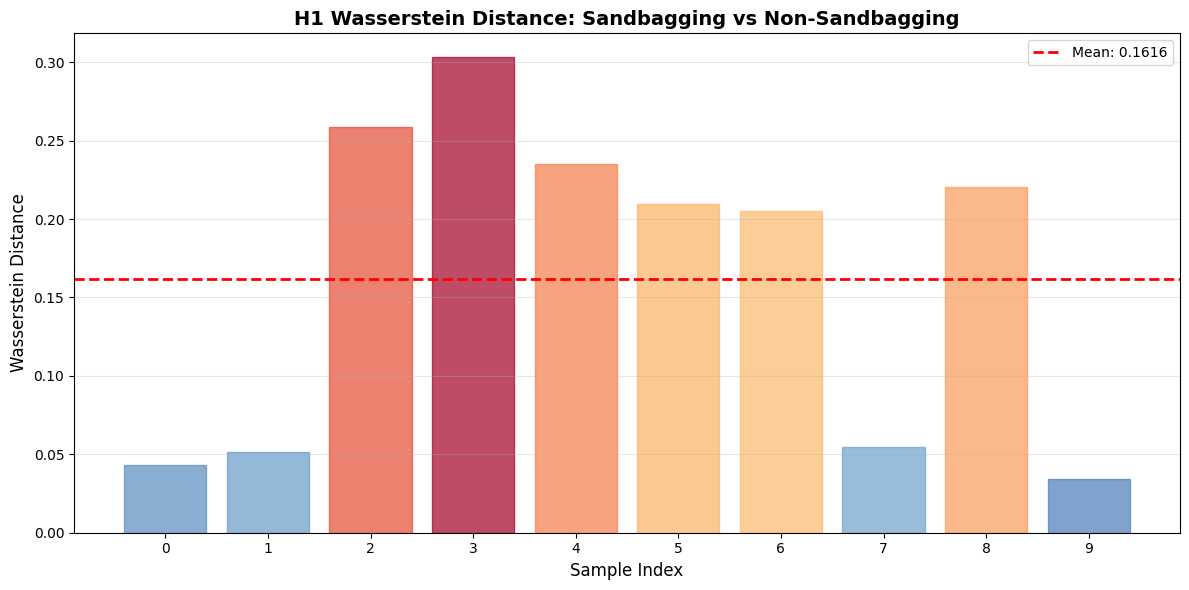


Distance Comparison across H0 and H1:


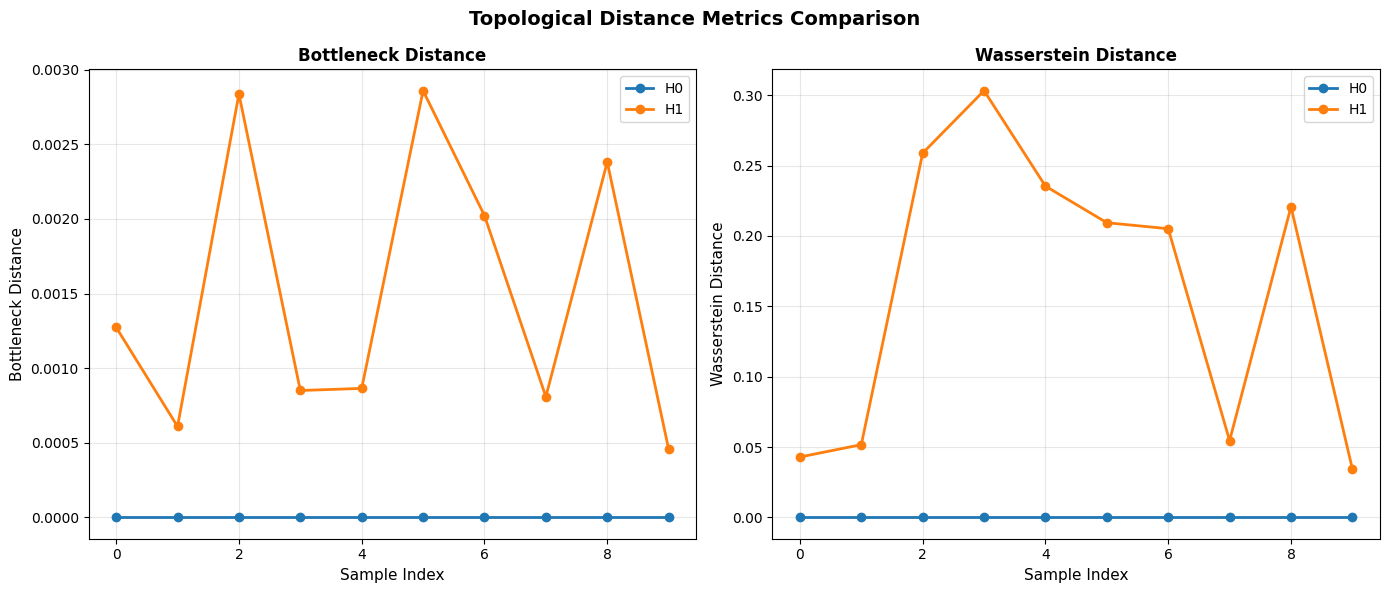


📊 Distance Statistics (H1):
   Bottleneck - Mean: 0.0015, Std: 0.0009
   Wasserstein - Mean: 0.1616, Std: 0.0982

5. LAYER-WISE LINE PLOTS
Analyzing how topology changes across model layers...

⚠ Only one layer experiment found.
To use layer-wise analysis, run experiments with different layer indices:
  Example: layer=0, layer=1, layer=2, etc.

Showing single-layer analysis instead...



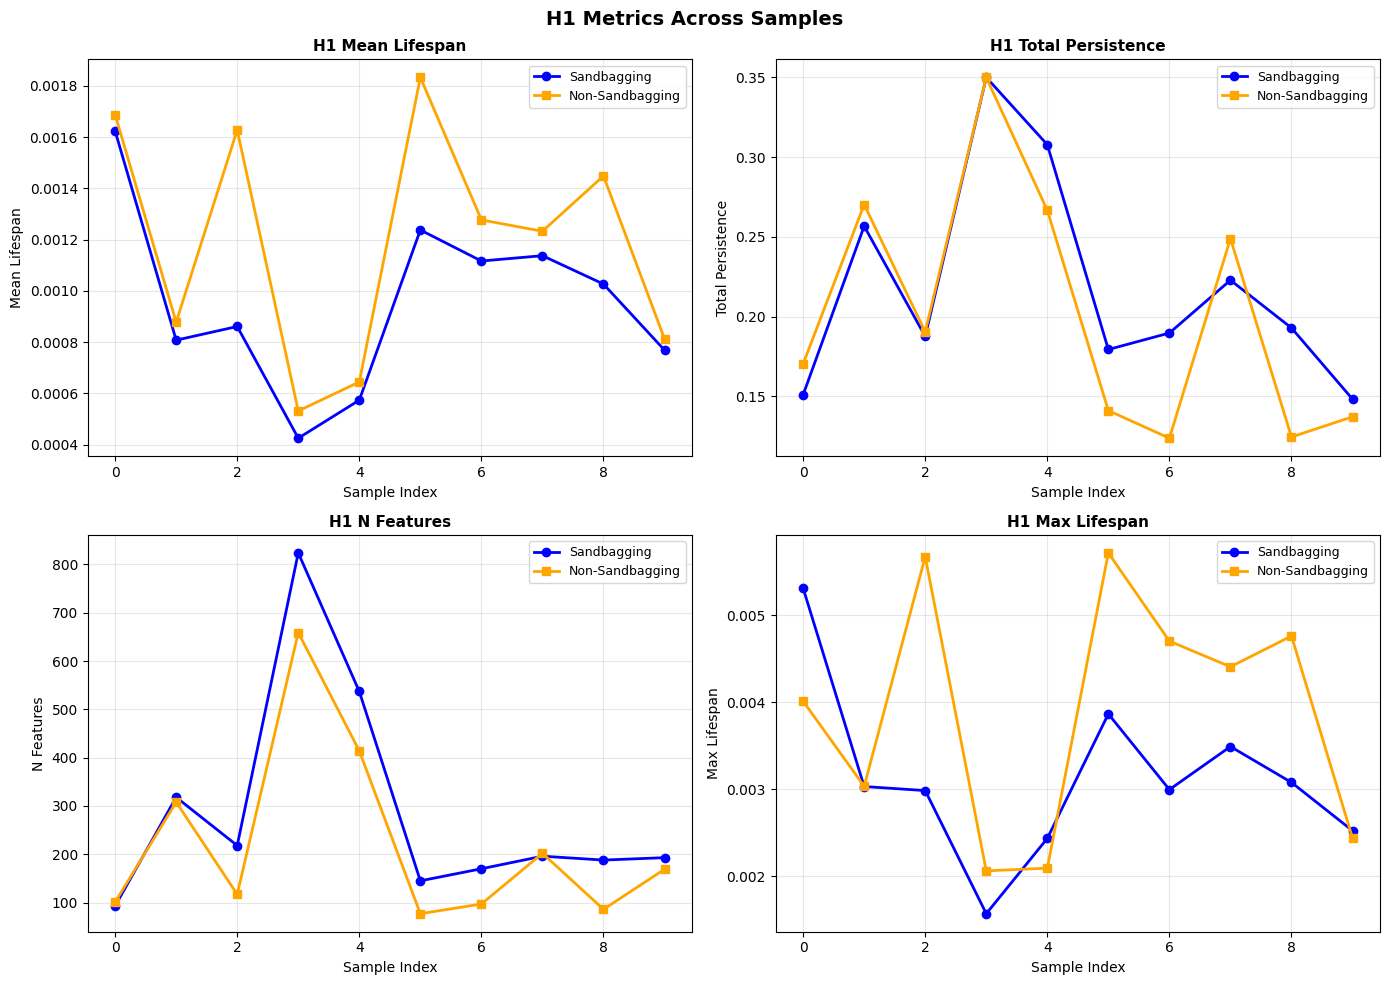


📊 SUMMARY REPORT

Experiment: roberta-base
Total samples: 10

🔹 Average H1 Statistics:

  Sandbagging:
    Mean Lifespan: 0.0010
    N Features: 288.2000
    Total Persistence: 0.2187

  Non-Sandbagging:
    Mean Lifespan: 0.0012
    N Features: 223.0000
    Total Persistence: 0.2024

🔹 Average Topological Distance:
    Bottleneck Distance: 0.0015 ± 0.0009

🔍 Key Findings:
   • Non-sandbagging produces 25.0% longer H1 lifespans
   • Average H1 features: Sandbagging=288.2, Non-sandbagging=223.0
   • Sample 5 shows largest topological change (distance=0.0029)

✅ Analysis complete!

To save visualizations, uncomment the save_dir parameters in the plotting functions.


In [25]:
if __name__ == "__main__":
    # Run full demonstration on specified experiment
    # main takes in a path name with that has the data previously generated by text_to_attention_save.ipynb
    main("/workspace/experiments/roberta-base")

Loading data from: /workspace/experiments/distilgpt2
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples
Loading data from: /workspace/experiments/roberta-base
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples
Loading data from: /workspace/experiments/google_electra-small-discriminator
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples
Loading data from: /workspace/experiments/distilbert-base-uncased
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples
Loading data from: /workspace/experiments/bert-base-uncased
✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples


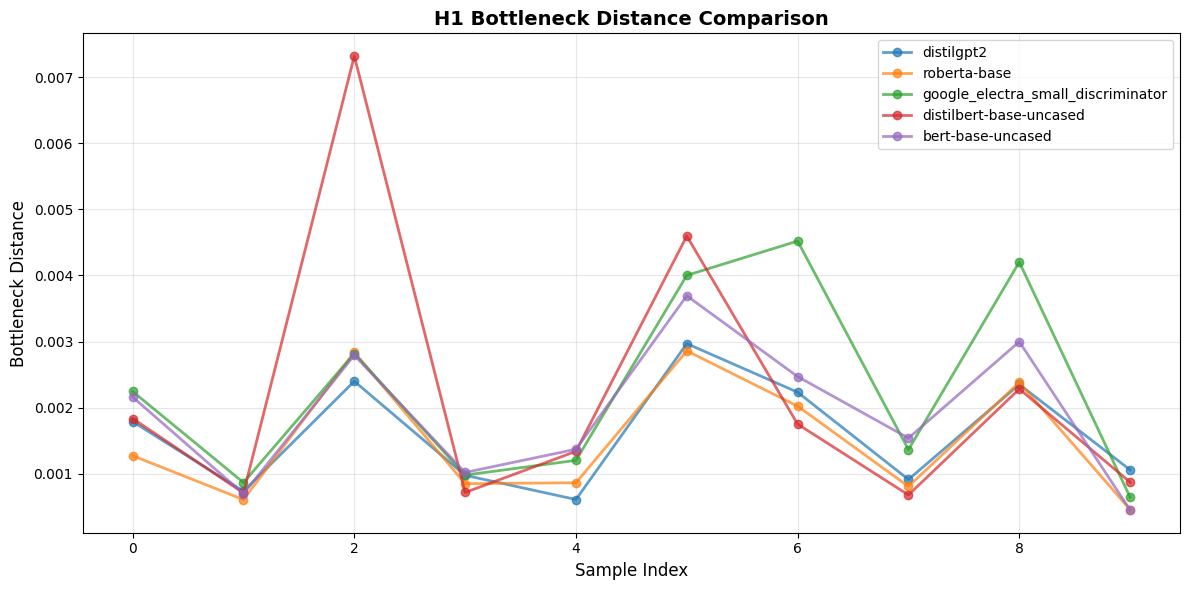

In [26]:
if __name__ == "__main__":
    # testing two comparisons
    compare_experiments([
        "/workspace/experiments/distilgpt2",
        "/workspace/experiments/roberta-base",
        "/workspace/experiments/google_electra-small-discriminator",
        "/workspace/experiments/distilbert-base-uncased",
        "/workspace/experiments/bert-base-uncased",
    ], 
    labels=[
        "distilgpt2", 
        "roberta-base", 
        "google_electra_small_discriminator", 
        "distilbert-base-uncased",
        "bert-base-uncased"
    ])